# MLP
Experiments using MLP classifier to try and classify coughs as covid postive vs covid negative.

By settings random_state to some common value for both Mel Spectrogram and MFCC randomised search cross-val, we can ensure that both approaches are tested on the same architectures. This allows for better comparison between Mel Spectogram and MFCC for each model, whilst still enabling each model type to be compared.

## Installing Required Packages and Setting Random State

In [1]:
# standard imports
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt 
from scipy import stats
import os

# for creating representative sample of whole dataset
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import imblearn
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

# librosa and tensorflow for pre-processing and CNN
import librosa
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection

# visualisations
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
import librosa.display
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
# important definitions
parent_dir = os.path.dirname(os.getcwd())
random_state = 23

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7698815396954664353
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7105767015
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4979611204071144790
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:28:00.0, compute capability: 6.1"
]


## Sample Creation

In [4]:
# load metadata csv
metadata = pd.read_csv(f"{parent_dir}/coughvid-19/metadata_compiled.csv")

# select relevant columns for resampling later
metadata = metadata[['uuid', 'cough_detected', 'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status']]

# basic filtering
metadata = metadata[metadata['cough_detected'] >= 0.8]  # recommendation by dataset creators
metadata = metadata[metadata['status'] != 'symptomatic']  # no way of knowing whether symptomatic == covid positive or negative
metadata = metadata[metadata['status'].notna()] 
metadata.drop(columns=['cough_detected'], inplace=True) 

# fill in nulls with mean of stratum (only present in age column)
metadata["age"] = metadata.groupby(["gender", "respiratory_condition", "fever_muscle_pain"]).transform(lambda x: x.fillna(x.mean()))
# split age into bands for better stratified sampling
metadata.age = pd.cut(metadata.age, bins=10)

print("Class distribution before resampling")
print(metadata.status.value_counts())

metadata.head()

Class distribution before resampling
healthy     8300
COVID-19     699
Name: status, dtype: int64


C:\Users\danie\anaconda3\envs\ai_coursework_test\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  


uuid           age  gender  \
1   00039425-7f3a-42aa-ac13-834aaa2b6b92  (10.8, 20.6]    male   
3   0009eb28-d8be-4dc1-92bb-907e53bc5c7a  (30.4, 40.2]    male   
5   001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  (20.6, 30.4]    male   
10  0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952  (20.6, 30.4]  female   
11  00291cce-36a0-4a29-9e2d-c1d96ca17242  (10.8, 20.6]    male   

   respiratory_condition fever_muscle_pain   status  
1                  False             False  healthy  
3                   True             False  healthy  
5                  False             False  healthy  
10                 False             False  healthy  
11                 False             False  healthy

In [5]:
# split out positive and negative records to ensure all positive records are kept for training and testing
metadata_pos = metadata[metadata['status']=='COVID-19']
metadata_neg = metadata[metadata['status']=='healthy']

metadata_pos = metadata_pos.reset_index().drop(columns='index')
metadata_neg = metadata_neg.reset_index().drop(columns='index')

In [6]:
X_neg = metadata_neg.drop(columns=['status', 'uuid'])
y_neg = metadata_neg.status

overall_sample_size = 2500  # balance between training time, and ensuring that resampling doesn't create bias
n_positive = len(metadata_pos)

# create smaller sample of original data set
sss = StratifiedShuffleSplit(n_splits=1, test_size=(2500-n_positive)/len(y_neg), random_state=random_state)
splits = sss.split(X_neg, y_neg)
for i in splits:
    experiment_set_ind = i[1]

print(f"First 10 indeces in sample: {experiment_set_ind[:10]}\n")  # first 10 indices

negative_uuids = metadata_neg.uuid.values[experiment_set_ind]  # stratified sample of negative uuids n=2500-699
positive_uuids = metadata_pos.uuid.values 

First 10 indeces in sample: [8057 3985 5852 6820 6964 6854 2372 2792 3662 7901]



In [7]:
# select negative sample using uuids
metadata_reduced_negative = metadata[metadata['uuid'].isin(negative_uuids)]
# select positive sample using uuids
metadata_reduced_positive = metadata[metadata['uuid'].isin(positive_uuids)]

# separate out target
X_negative = metadata_reduced_negative[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_negative = metadata_reduced_negative['status']
X_positive = metadata_reduced_positive[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_positive = metadata_reduced_positive['status']

# aim to maximize number of positive cases in training data
# keep 50 in testing data
X_train_n, X_test_n , y_train_n, y_test_n = train_test_split(X_negative, y_negative, test_size=0.2495, random_state=random_state)
X_train_p, X_test_p , y_train_p, y_test_p = train_test_split(X_positive, y_positive, test_size=0.071, random_state=random_state)

X_train, y_train = pd.concat([X_train_p, X_train_n]), pd.concat([y_train_p, y_train_n])
X_test, y_test = pd.concat([X_test_p, X_test_n]), pd.concat([y_test_p, y_test_n])

print("Training set class balance BEFORE resampling:")
print(y_train.value_counts(), "\n")

print("Test set class balance BEFORE resampling:")
print(y_test.value_counts())


Training set class balance BEFORE resampling:
healthy     1351
COVID-19     649
Name: status, dtype: int64 

Test set class balance BEFORE resampling:
healthy     450
COVID-19     50
Name: status, dtype: int64


In [8]:
# balance the training set (and create balanced test set for optional use later)
# use recommended SMOTE methodology
oversample = imblearn.over_sampling.SMOTEN(sampling_strategy=1000/1351, random_state = random_state)  # desired_n/size of majority
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = random_state)
steps = [('o', oversample), ('u', undersample)]
rebalancing_pipeline = Pipeline(steps=steps)

X_train, y_train = rebalancing_pipeline.fit_resample(X_train, y_train)

print("Training set class balance AFTER resampling: ")
print(y_train.value_counts(), "\n")

Training set class balance AFTER resampling: 
COVID-19    1000
healthy     1000
Name: status, dtype: int64 



In [10]:
## create list of uuids
X_train_uuids = X_train.uuid.values
X_test_uuids = X_test.uuid.values

print(f"Re-balanced sample has {len(X_train_uuids) + len(y_test)} records from {len(negative_uuids) + len(positive_uuids)} originally.")

Re-balanced sample has 2500 records from 2500 originally.


## Load and Transform Data

In [11]:
# Load the data

PATH_TO_AUDIO = f'{parent_dir}/wav_recordings/'

def create_ds(uuid_list, audio_folder):
    """
    Returns: pandas dataframe; 
    Each dataframe has 3 columns - raw audio signal, sample rate, label (covid vs not covid)
    """
    signals = []
    labels = np.array([])
    input_len = 10*22050  # need to find justifiable length, also consider downsampling!

    for uuid in uuid_list:
        signal, _ = librosa.load(f'{audio_folder}{uuid}.wav')
        label = metadata[metadata['uuid'] == uuid]['status'].values[0]

        #signal = down_samp(signal)  # not a function (yet?)
        signal = signal[:input_len]
        zero_padding = np.zeros(input_len-len(signal))
        signal = np.append(signal, zero_padding)

        signals.append(signal)
        labels = np.append(labels, label)

    #ds = pd.DataFrame(data = data, columns=['audio', 'sample_rate', 'label'])

    return np.array(signals), labels


sample_rate = 22050.0  # checked all recordings so lets save some memory and time

train_signals, y_train = create_ds(X_train_uuids, PATH_TO_AUDIO)
test_signals, y_test = create_ds(X_test_uuids, PATH_TO_AUDIO)

In [12]:
train_signals, y_train = shuffle(train_signals, y_train, random_state = random_state)
test_signals, y_test = shuffle(test_signals, y_test, random_state = random_state)

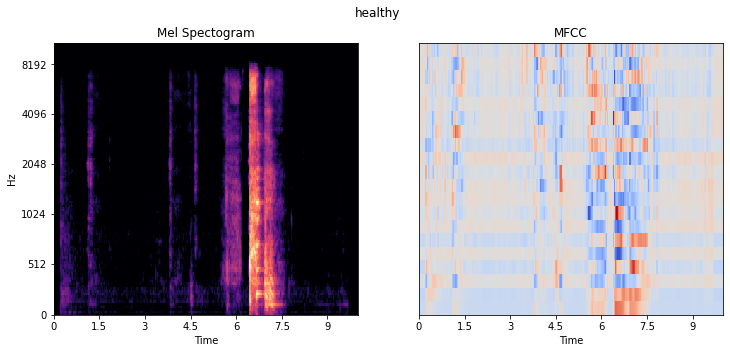

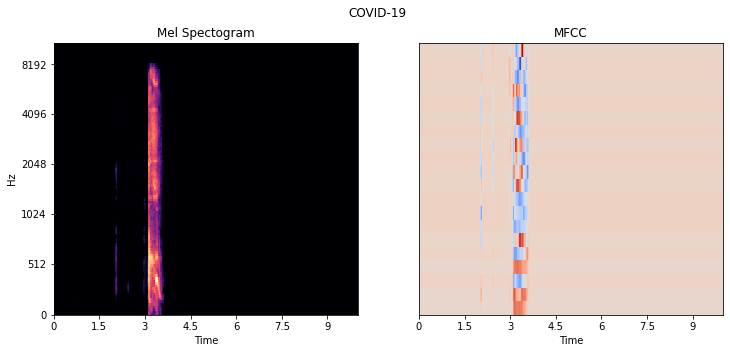

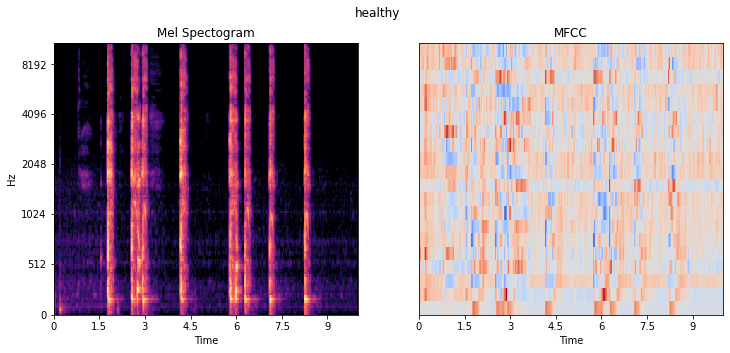

In [13]:
def get_mel_spectrogram(signal):
    sgram =librosa.stft(signal)

    sgram_mag, _= librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag)

    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref = np.min)

    return mel_sgram

def get_mfcc(signal, n_mfcc=20):
    """
        Return mfcc with x mfccs
    """
    mfcc = librosa.feature.mfcc(signal, n_mfcc=n_mfcc)
    mfcc = preprocessing.scale(mfcc, axis=1)
    return mfcc

# plot 3 mel spectograms to show that helper function works
for a in range(3):
    i = random.randint(0, len(train_signals))
    mel_sgram = get_mel_spectrogram(train_signals[i])
    mfcc = get_mfcc(train_signals[i])


    label = y_train[i]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    librosa.display.specshow(mel_sgram, x_axis='time', y_axis='mel', ax=ax1)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax2)


    fig.suptitle(label)
    ax1.set_title('Mel Spectogram')
    ax2.set_title('MFCC')
    #plt.colorbar(format='%+2.0f dB', ax=ax1)
    plt.show()



In [14]:
train_mel_spectrograms = []
test_mel_spectrograms = []

train_mfccs = []
test_mfccs = []

for signal in train_signals:
    mel_spect = get_mel_spectrogram(signal)
    train_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc(signal)
    train_mfccs.append(mfcc)


for signal in test_signals:
    mel_spect = get_mel_spectrogram(signal)
    test_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc(signal)
    test_mfccs.append(mfcc)

train_mel_spectrograms = np.array(train_mel_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
test_mfccs = np.array(test_mfccs)

# normalise (between 0 and 1)
train_mel_spectrograms = (train_mel_spectrograms - train_mel_spectrograms.min())/(train_mel_spectrograms.max() - train_mel_spectrograms.min())
test_mel_spectrograms = (test_mel_spectrograms - test_mel_spectrograms.min())/(test_mel_spectrograms.max() - test_mel_spectrograms.min())
train_mfccs = (train_mfccs - train_mfccs.min())/(train_mfccs.max() - train_mfccs.min())
test_mfccs = (test_mfccs - test_mfccs.min())/(test_mfccs.max() - test_mfccs.min())


In [15]:
#pre-process labels
def to_binary(label):
    if label == 'COVID-19':
        return 1
    else:
        return 0

y_train = np.array(list(map(to_binary, y_train)))
y_test = np.array(list(map(to_binary, y_test)))


## Mel Spectogram 

In [16]:
X_train = train_mel_spectrograms
X_test = test_mel_spectrograms

In [17]:
X_train.shape, X_test.shape

((2000, 128, 431), (500, 128, 431))

### Base Model

In [20]:
def build_mlp(n_hidden = 1,
    hidden_dim = 16,
    loss_func = 'binary_crossentropy',
    kernel_initialiser = 'he_normal',
    hidden_activation = 'leaky_relu',
    final_activation = 'sigmoid',
    input_shape = (128 ,431),
    optimiser = 'SGD',
    learning_rate = 0.0001):

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))

    if hidden_activation == 'leaky_relu':
        for layer in range(n_hidden):
            model.add(keras.layers.Dense(hidden_dim, kernel_initializer="he_normal"))
            keras.layers.LeakyReLU(alpha=0.2),
    elif hidden_activation == 'selu':
        for layer in range(n_hidden):
            model.add(keras.layers.Dense(hidden_dim, kernel_initializer="lecun_normal"))
    else:
        for layer in range(n_hidden):
            model.add(keras.layers.Dense(hidden_dim, activation=hidden_activation, kernel_initializer=kernel_initialiser))

    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)
    
    model.compile(loss = loss_func, optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

mlp = keras.wrappers.scikit_learn.KerasClassifier(build_mlp)



In [18]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [1, 2, 3],
    'hidden_dim' : [4, 8, 16, 32], #remove 64
    'batch_size' : [16, 32], #removed 64
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal', 'lecun_normal'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'leaky_relu'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['momentum', 'Adam', 'Adamax'] #, # removed SGD
}

rnd_search_cv = model_selection.RandomizedSearchCV(mlp, param_dist, n_iter=12, scoring=["roc_auc", "recall"], refit='roc_auc', 
                                                   cv=5, random_state = random_state, return_train_score = True)
rnd_search_cv.fit(X_train, y_train, epochs = 275)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 55168)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1765408   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,766,497
Trainable params: 1,766,497
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/275
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7032 - AUC: 0.5355
Epoch 2/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6605 - AUC: 0.6379
Epoch 3/275
160

1600/1600 [==============================] - 0s 245us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 151/275
1600/1600 [==============================] - 0s 257us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 152/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 153/275
1600/1600 [==============================] - 0s 245us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 154/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 155/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 156/275
1600/1600 [==============================] - 0s 255us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 157/275
1600/1600 [==============================] - 0s 254us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 158/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 159/275
1600/1600 [==============================] - 0s 253us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 24/275
1600/1600 [==============================] - 0s 255us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 25/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 26/275
1600/1600 [==============================] - 0s 258us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 27/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 28/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 29/275
1600/1600 [==============================] - 0s 256us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 30/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 31/275
1600/1600 [==============================] - 0s 258us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 32/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.57

1600/1600 [==============================] - 0s 256us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 181/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 182/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 183/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 184/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 185/275
1600/1600 [==============================] - 0s 256us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 186/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 187/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 188/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 189/275
1600/1600 [==============================] - 0s 253us/sample - l

1600/1600 [==============================] - 0s 235us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 54/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 55/275
1600/1600 [==============================] - 0s 236us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 56/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 57/275
1600/1600 [==============================] - 0s 235us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 58/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 59/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 60/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 61/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 62/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.72

1600/1600 [==============================] - 0s 233us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 211/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 212/275
1600/1600 [==============================] - 0s 231us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 213/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 214/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 215/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 216/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 217/275
1600/1600 [==============================] - 0s 231us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 218/275
1600/1600 [==============================] - 0s 232us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 219/275
1600/1600 [==============================] - 0s 233us/sample - l

1600/1600 [==============================] - 0s 249us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 85/275
1600/1600 [==============================] - 0s 260us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 86/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 87/275
1600/1600 [==============================] - 0s 257us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 88/275
1600/1600 [==============================] - 0s 247us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 89/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 90/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 91/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 92/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 93/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.59

1600/1600 [==============================] - 0s 252us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 164/275
1600/1600 [==============================] - 0s 258us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 165/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 166/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 167/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 168/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 169/275
1600/1600 [==============================] - 0s 258us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 170/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 171/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 172/275
1600/1600 [==============================] - 0s 248us/sample - l

1600/1600 [==============================] - 0s 250us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 0s 264us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 0s 250us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 41/275
1600/1600 [==============================] - 0s 254us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 42/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 43/275
1600/1600 [==============================] - 0s 261us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 44/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 45/275
1600/1600 [==============================] - 0s 252us/sample - loss: 7.67

1600/1600 [==============================] - 0s 245us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 194/275
1600/1600 [==============================] - 0s 260us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 0s 252us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 198/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 199/275
1600/1600 [==============================] - 0s 257us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 200/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 201/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 202/275
1600/1600 [==============================] - 0s 255us/sample - l

1600/1600 [==============================] - 0s 224us/sample - loss: 0.4547 - AUC: 0.8578
Epoch 67/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4165 - AUC: 0.8919
Epoch 68/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4336 - AUC: 0.8748
Epoch 69/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.4457 - AUC: 0.8658
Epoch 70/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4290 - AUC: 0.8783
Epoch 71/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4217 - AUC: 0.8853
Epoch 72/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4179 - AUC: 0.8880
Epoch 73/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4255 - AUC: 0.8812
Epoch 74/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4165 - AUC: 0.8879
Epoch 75/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.44

1600/1600 [==============================] - 0s 224us/sample - loss: 0.2468 - AUC: 0.9676
Epoch 224/275
1600/1600 [==============================] - 0s 222us/sample - loss: 0.2184 - AUC: 0.9793
Epoch 225/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2176 - AUC: 0.9808
Epoch 226/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2239 - AUC: 0.9762
Epoch 227/275
1600/1600 [==============================] - 0s 221us/sample - loss: 0.2347 - AUC: 0.9718
Epoch 228/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2356 - AUC: 0.9714
Epoch 229/275
1600/1600 [==============================] - 0s 222us/sample - loss: 0.2184 - AUC: 0.9794
Epoch 230/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2064 - AUC: 0.9845
Epoch 231/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2063 - AUC: 0.9840
Epoch 232/275
1600/1600 [==============================] - 0s 224us/sample - l

1600/1600 [==============================] - 0s 241us/sample - loss: 0.4198 - AUC: 0.8838
Epoch 98/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3969 - AUC: 0.9000
Epoch 99/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3792 - AUC: 0.9140
Epoch 100/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3846 - AUC: 0.9080
Epoch 101/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3776 - AUC: 0.9117
Epoch 102/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3746 - AUC: 0.9156
Epoch 103/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.3698 - AUC: 0.9190
Epoch 104/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3661 - AUC: 0.9236
Epoch 105/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3737 - AUC: 0.9137
Epoch 106/275
1600/1600 [==============================] - 0s 245us/sample - los

Epoch 176/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2891 - AUC: 0.9525
Epoch 177/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.3076 - AUC: 0.9421
Epoch 178/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2861 - AUC: 0.9522
Epoch 179/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2629 - AUC: 0.9664
Epoch 180/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2554 - AUC: 0.9703
Epoch 181/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2506 - AUC: 0.9718
Epoch 182/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.2603 - AUC: 0.9685
Epoch 183/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2680 - AUC: 0.9640
Epoch 184/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2613 - AUC: 0.9653
Epoch 185/275
1600/1600 [==============================] - 0s 23

1600/1600 [==============================] - 0s 231us/sample - loss: 0.4803 - AUC: 0.8422
Epoch 50/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5256 - AUC: 0.8132
Epoch 51/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4396 - AUC: 0.8726
Epoch 52/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4585 - AUC: 0.8567
Epoch 53/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4269 - AUC: 0.8828
Epoch 54/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4430 - AUC: 0.8681
Epoch 55/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4373 - AUC: 0.8713
Epoch 56/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4267 - AUC: 0.8824
Epoch 57/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4378 - AUC: 0.8743
Epoch 58/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.43

1600/1600 [==============================] - 0s 231us/sample - loss: 0.3316 - AUC: 0.9341
Epoch 129/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3881 - AUC: 0.9015
Epoch 130/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3025 - AUC: 0.9540
Epoch 131/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2905 - AUC: 0.9621
Epoch 132/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2979 - AUC: 0.9561
Epoch 133/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.2998 - AUC: 0.9551
Epoch 134/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3061 - AUC: 0.9510
Epoch 135/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3132 - AUC: 0.9449
Epoch 136/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3835 - AUC: 0.9050
Epoch 137/275
1600/1600 [==============================] - 0s 229us/sample - l

1600/1600 [==============================] - 1s 643us/sample - loss: 0.8033 - AUC: 0.5436
Epoch 2/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6750 - AUC: 0.6119
Epoch 3/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6684 - AUC: 0.6314
Epoch 4/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6396 - AUC: 0.6875
Epoch 5/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6141 - AUC: 0.7266
Epoch 6/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6085 - AUC: 0.7304
Epoch 7/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6127 - AUC: 0.7238
Epoch 8/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6132 - AUC: 0.7256
Epoch 9/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5998 - AUC: 0.7409
Epoch 10/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5812 - AUC

1600/1600 [==============================] - 0s 249us/sample - loss: 0.3067 - AUC: 0.9525
Epoch 160/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3486 - AUC: 0.9220
Epoch 161/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3799 - AUC: 0.9035
Epoch 162/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3428 - AUC: 0.9265
Epoch 163/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3031 - AUC: 0.9527
Epoch 164/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2991 - AUC: 0.9562
Epoch 165/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3175 - AUC: 0.9419
Epoch 166/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3093 - AUC: 0.9473
Epoch 167/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3094 - AUC: 0.9485
Epoch 168/275
1600/1600 [==============================] - 0s 238us/sample - l

1600/1600 [==============================] - 0s 228us/sample - loss: 0.5038 - AUC: 0.8290
Epoch 33/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5143 - AUC: 0.8176
Epoch 34/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4991 - AUC: 0.8322
Epoch 35/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4903 - AUC: 0.8423
Epoch 36/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5059 - AUC: 0.8259
Epoch 37/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.5233 - AUC: 0.8149
Epoch 38/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4765 - AUC: 0.8527
Epoch 39/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4877 - AUC: 0.8394
Epoch 40/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4735 - AUC: 0.8559
Epoch 41/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.49

1600/1600 [==============================] - 0s 230us/sample - loss: 0.2980 - AUC: 0.9492
Epoch 190/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.2855 - AUC: 0.9572
Epoch 191/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2893 - AUC: 0.9548
Epoch 192/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2801 - AUC: 0.9587
Epoch 193/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2909 - AUC: 0.9520
Epoch 194/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2627 - AUC: 0.9705
Epoch 195/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2602 - AUC: 0.9701
Epoch 196/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.2611 - AUC: 0.9690
Epoch 197/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2792 - AUC: 0.9586
Epoch 198/275
1600/1600 [==============================] - 0s 228us/sample - l

1600/1600 [==============================] - 0s 237us/sample - loss: 0.3960 - AUC: 0.8946
Epoch 63/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5141 - AUC: 0.8298
Epoch 64/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4455 - AUC: 0.8650
Epoch 65/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3989 - AUC: 0.8959
Epoch 66/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4205 - AUC: 0.8823
Epoch 67/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3834 - AUC: 0.9049
Epoch 68/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3884 - AUC: 0.9019
Epoch 69/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3821 - AUC: 0.9063
Epoch 70/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3914 - AUC: 0.8985
Epoch 71/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.37

1600/1600 [==============================] - 0s 239us/sample - loss: 0.1810 - AUC: 0.9793
Epoch 220/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1236 - AUC: 0.9920
Epoch 221/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.1089 - AUC: 0.9951
Epoch 222/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1382 - AUC: 0.9894
Epoch 223/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1308 - AUC: 0.9908
Epoch 224/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2891 - AUC: 0.9556
Epoch 225/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3988 - AUC: 0.9324
Epoch 226/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.1354 - AUC: 0.9894
Epoch 227/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.1232 - AUC: 0.9928
Epoch 228/275
1600/1600 [==============================] - 0s 251us/sample - l

1600/1600 [==============================] - 0s 225us/sample - loss: 0.3094 - AUC: 0.9428
Epoch 94/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.3626 - AUC: 0.9142
Epoch 95/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2977 - AUC: 0.9491
Epoch 96/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3098 - AUC: 0.9392
Epoch 97/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4313 - AUC: 0.8844
Epoch 98/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2880 - AUC: 0.9538
Epoch 99/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.3131 - AUC: 0.9389
Epoch 100/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3137 - AUC: 0.9384
Epoch 101/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3062 - AUC: 0.9415
Epoch 102/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.1585 - AUC: 0.9869
Epoch 173/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.1847 - AUC: 0.9796
Epoch 174/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.1717 - AUC: 0.9837
Epoch 175/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.1410 - AUC: 0.9907
Epoch 176/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.1443 - AUC: 0.9898
Epoch 177/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2000 - AUC: 0.9756
Epoch 178/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2801 - AUC: 0.9533
Epoch 179/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2136 - AUC: 0.9714
Epoch 180/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.1418 - AUC: 0.9900
Epoch 181/275
1600/1600 [==============================] - 0s 22

1600/1600 [==============================] - 0s 255us/sample - loss: 0.4317 - AUC: 0.8762
Epoch 46/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4497 - AUC: 0.8644
Epoch 47/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4502 - AUC: 0.8635
Epoch 48/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4282 - AUC: 0.8801
Epoch 49/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4464 - AUC: 0.8644
Epoch 50/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4468 - AUC: 0.8654
Epoch 51/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4334 - AUC: 0.8739
Epoch 52/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4762 - AUC: 0.8485
Epoch 53/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4114 - AUC: 0.8927
Epoch 54/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.48

1600/1600 [==============================] - 0s 243us/sample - loss: 0.1574 - AUC: 0.9852
Epoch 203/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1552 - AUC: 0.9855
Epoch 204/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1083 - AUC: 0.9952
Epoch 205/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.1406 - AUC: 0.9884
Epoch 206/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1010 - AUC: 0.9964
Epoch 207/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.0908 - AUC: 0.9976
Epoch 208/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.1065 - AUC: 0.9955
Epoch 209/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2010 - AUC: 0.9754
Epoch 210/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1358 - AUC: 0.9899
Epoch 211/275
1600/1600 [==============================] - 0s 245us/sample - l

1600/1600 [==============================] - 1s 847us/sample - loss: 0.7288 - AUC: 0.5693
Epoch 2/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.8380 - AUC: 0.5619
Epoch 3/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6482 - AUC: 0.6867
Epoch 4/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6057 - AUC: 0.7287
Epoch 5/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5921 - AUC: 0.7500
Epoch 6/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6095 - AUC: 0.7279
Epoch 7/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5835 - AUC: 0.7560
Epoch 8/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6008 - AUC: 0.7393
Epoch 9/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6074 - AUC: 0.7400
Epoch 10/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5525 - AUC

1600/1600 [==============================] - 0s 239us/sample - loss: 0.2771 - AUC: 0.9522
Epoch 160/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.1921 - AUC: 0.9796
Epoch 161/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.1976 - AUC: 0.9778
Epoch 162/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3148 - AUC: 0.9391
Epoch 163/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1654 - AUC: 0.9886
Epoch 164/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1712 - AUC: 0.9864
Epoch 165/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.1818 - AUC: 0.9825
Epoch 166/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2132 - AUC: 0.9722
Epoch 167/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2719 - AUC: 0.9539
Epoch 168/275
1600/1600 [==============================] - 0s 248us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.4823 - AUC: 0.8433
Epoch 33/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5036 - AUC: 0.8258
Epoch 34/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4641 - AUC: 0.8573
Epoch 35/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.4885 - AUC: 0.8375
Epoch 36/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4914 - AUC: 0.8366
Epoch 37/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4664 - AUC: 0.8543
Epoch 38/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4836 - AUC: 0.8409
Epoch 39/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4869 - AUC: 0.8389
Epoch 40/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4612 - AUC: 0.8574
Epoch 41/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.47

1600/1600 [==============================] - 0s 251us/sample - loss: 0.1106 - AUC: 0.9946
Epoch 190/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1383 - AUC: 0.9896
Epoch 191/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.1068 - AUC: 0.9954
Epoch 192/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1066 - AUC: 0.9951
Epoch 193/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1200 - AUC: 0.9927
Epoch 194/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1107 - AUC: 0.9941
Epoch 195/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.1569 - AUC: 0.9848
Epoch 196/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1245 - AUC: 0.9916
Epoch 197/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.0950 - AUC: 0.9966
Epoch 198/275
1600/1600 [==============================] - 0s 243us/sample - l

1600/1600 [==============================] - 1s 350us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 63/275
1600/1600 [==============================] - 1s 344us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 64/275
1600/1600 [==============================] - 1s 356us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 65/275
1600/1600 [==============================] - 1s 345us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 66/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 67/275
1600/1600 [==============================] - 1s 351us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 68/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 69/275
1600/1600 [==============================] - 1s 351us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 70/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 71/275
1600/1600 [==============================] - 1s 350us/sample - loss: 7.80

1600/1600 [==============================] - 1s 346us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 220/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 221/275
1600/1600 [==============================] - 1s 347us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 222/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 223/275
1600/1600 [==============================] - 1s 345us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 224/275
1600/1600 [==============================] - 1s 338us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 225/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 226/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 227/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 228/275
1600/1600 [==============================] - 1s 343us/sample - l

1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 94/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 95/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 96/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 1s 331us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7

Epoch 172/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 173/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 174/275
1600/1600 [==============================] - 1s 336us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 175/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 176/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 177/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 178/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 179/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 180/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 181/275
1600/1600 [==============================] - 1s 33

1600/1600 [==============================] - 1s 351us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 46/275
1600/1600 [==============================] - 1s 345us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 47/275
1600/1600 [==============================] - 1s 349us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 48/275
1600/1600 [==============================] - 1s 351us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 49/275
1600/1600 [==============================] - 1s 344us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 50/275
1600/1600 [==============================] - 1s 351us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 51/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 52/275
1600/1600 [==============================] - 1s 357us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 53/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 54/275
1600/1600 [==============================] - 1s 349us/sample - loss: 7.65

1600/1600 [==============================] - 1s 345us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 203/275
1600/1600 [==============================] - 1s 343us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 204/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 205/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 206/275
1600/1600 [==============================] - 1s 344us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 207/275
1600/1600 [==============================] - 1s 342us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 208/275
1600/1600 [==============================] - 1s 344us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 209/275
1600/1600 [==============================] - 1s 342us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 210/275
1600/1600 [==============================] - 1s 380us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 211/275
1600/1600 [==============================] - 1s 344us/sample - l

1600/1600 [==============================] - 2s 944us/sample - loss: 0.6996 - AUC: 0.5541
Epoch 2/275
1600/1600 [==============================] - 1s 326us/sample - loss: 0.6653 - AUC: 0.6302
Epoch 3/275
1600/1600 [==============================] - 1s 325us/sample - loss: 0.6756 - AUC: 0.6577
Epoch 4/275
1600/1600 [==============================] - 1s 326us/sample - loss: 0.7332 - AUC: 0.6604
Epoch 5/275
1600/1600 [==============================] - 1s 328us/sample - loss: 2.3283 - AUC: 0.6076
Epoch 6/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 7/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 8/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 9/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 10/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC

1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 160/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 161/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 162/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 163/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 164/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 165/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 166/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 167/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 168/275
1600/1600 [==============================] - 1s 333us/sample - l

1600/1600 [==============================] - 1s 341us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 33/275
1600/1600 [==============================] - 1s 349us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 34/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 35/275
1600/1600 [==============================] - 1s 350us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 36/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 1s 348us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 1s 343us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 1s 353us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 41/275
1600/1600 [==============================] - 1s 344us/sample - loss: 7.70

1600/1600 [==============================] - 1s 343us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 190/275
1600/1600 [==============================] - 1s 345us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 191/275
1600/1600 [==============================] - 1s 348us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 192/275
1600/1600 [==============================] - 1s 340us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 193/275
1600/1600 [==============================] - 1s 348us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 194/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 1s 348us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 1s 348us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 198/275
1600/1600 [==============================] - 1s 345us/sample - l

1600/1600 [==============================] - 0s 247us/sample - loss: 0.3766 - AUC: 0.9076
Epoch 62/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.4428 - AUC: 0.8681
Epoch 63/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4280 - AUC: 0.8786
Epoch 64/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4157 - AUC: 0.8849
Epoch 65/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4806 - AUC: 0.8516
Epoch 66/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4078 - AUC: 0.8900
Epoch 67/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4098 - AUC: 0.8876
Epoch 68/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3627 - AUC: 0.9159
Epoch 69/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3954 - AUC: 0.8962
Epoch 70/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.39

1600/1600 [==============================] - 0s 236us/sample - loss: 0.6605 - AUC: 0.8956
Epoch 219/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.1379 - AUC: 0.9887
Epoch 220/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.0955 - AUC: 0.9971
Epoch 221/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.0894 - AUC: 0.9975
Epoch 222/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2184 - AUC: 0.9698
Epoch 223/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.1514 - AUC: 0.9860
Epoch 224/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.1034 - AUC: 0.9947
Epoch 225/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.0794 - AUC: 0.9976
Epoch 226/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.1045 - AUC: 0.9941
Epoch 227/275
1600/1600 [==============================] - 0s 237us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 0.5995 - AUC: 0.7399
Epoch 13/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.5661 - AUC: 0.7732
Epoch 14/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5492 - AUC: 0.7911
Epoch 15/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5611 - AUC: 0.7753
Epoch 16/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.5465 - AUC: 0.7893
Epoch 17/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5658 - AUC: 0.7765
Epoch 18/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.5574 - AUC: 0.7814
Epoch 19/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5547 - AUC: 0.7821
Epoch 20/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5446 - AUC: 0.7930
Epoch 21/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.54

Epoch 170/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.1768 - AUC: 0.9804
Epoch 171/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.2020 - AUC: 0.9736
Epoch 172/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.1369 - AUC: 0.9901
Epoch 173/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.1103 - AUC: 0.9943
Epoch 174/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.1308 - AUC: 0.9902
Epoch 175/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.1874 - AUC: 0.9782
Epoch 176/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.1430 - AUC: 0.9875
Epoch 177/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.1753 - AUC: 0.9803
Epoch 178/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.1966 - AUC: 0.9757
Epoch 179/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 249us/sample - loss: 0.5341 - AUC: 0.8253
Epoch 43/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5336 - AUC: 0.8096
Epoch 44/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4615 - AUC: 0.8575
Epoch 45/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4324 - AUC: 0.8817
Epoch 46/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4368 - AUC: 0.8730
Epoch 47/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4441 - AUC: 0.8659
Epoch 48/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.4545 - AUC: 0.8577
Epoch 49/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5081 - AUC: 0.8337
Epoch 50/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4249 - AUC: 0.8830
Epoch 51/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.44

1600/1600 [==============================] - 0s 261us/sample - loss: 0.0847 - AUC: 0.9971
Epoch 200/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.0754 - AUC: 0.9984
Epoch 201/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.0751 - AUC: 0.9981
Epoch 202/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.1164 - AUC: 0.9916
Epoch 203/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.0741 - AUC: 0.9977
Epoch 204/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3481 - AUC: 0.9473
Epoch 205/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4301 - AUC: 0.9251
Epoch 206/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.0980 - AUC: 0.9966
Epoch 207/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.1051 - AUC: 0.9947
Epoch 208/275
1600/1600 [==============================] - 0s 253us/sample - l

1600/1600 [==============================] - 1s 925us/sample - loss: 1.3362 - AUC: 0.5149
Epoch 2/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6510 - AUC: 0.6620
Epoch 3/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6552 - AUC: 0.6667
Epoch 4/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6216 - AUC: 0.7144
Epoch 5/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.6356 - AUC: 0.6967
Epoch 6/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5967 - AUC: 0.7455
Epoch 7/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5759 - AUC: 0.7676
Epoch 8/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.6030 - AUC: 0.7378
Epoch 9/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6027 - AUC: 0.7449
Epoch 10/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5786 - AUC

1600/1600 [==============================] - 0s 233us/sample - loss: 0.2450 - AUC: 0.9649
Epoch 160/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.1957 - AUC: 0.9753
Epoch 161/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.1477 - AUC: 0.9878
Epoch 162/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2414 - AUC: 0.9648
Epoch 163/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.2507 - AUC: 0.9622
Epoch 164/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.2541 - AUC: 0.9607
Epoch 165/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.1477 - AUC: 0.9881
Epoch 166/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.1199 - AUC: 0.9937
Epoch 167/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.1765 - AUC: 0.9806
Epoch 168/275
1600/1600 [==============================] - 0s 234us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 0.4959 - AUC: 0.8327
Epoch 32/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4761 - AUC: 0.8472
Epoch 33/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4873 - AUC: 0.8372
Epoch 34/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4846 - AUC: 0.8415
Epoch 35/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5033 - AUC: 0.8297
Epoch 36/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4868 - AUC: 0.8379
Epoch 37/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4694 - AUC: 0.8537
Epoch 38/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4559 - AUC: 0.8610
Epoch 39/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4797 - AUC: 0.8434
Epoch 40/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.45

1600/1600 [==============================] - 0s 246us/sample - loss: 0.1689 - AUC: 0.9829
Epoch 189/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1131 - AUC: 0.9946
Epoch 190/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.0984 - AUC: 0.9962
Epoch 191/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.1226 - AUC: 0.9920
Epoch 192/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.2804 - AUC: 0.9570
Epoch 193/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.1091 - AUC: 0.9947
Epoch 194/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1198 - AUC: 0.9928
Epoch 195/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2197 - AUC: 0.9716
Epoch 196/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.1073 - AUC: 0.9942
Epoch 197/275
1600/1600 [==============================] - 0s 259us/sample - l

1600/1600 [==============================] - 0s 241us/sample - loss: 0.4825 - AUC: 0.8434
Epoch 64/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4096 - AUC: 0.8909
Epoch 65/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4028 - AUC: 0.8964
Epoch 66/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4076 - AUC: 0.8937
Epoch 67/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4336 - AUC: 0.8750
Epoch 68/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4100 - AUC: 0.8918
Epoch 69/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3911 - AUC: 0.9060
Epoch 70/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3906 - AUC: 0.9042
Epoch 71/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3972 - AUC: 0.9005
Epoch 72/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.40

1600/1600 [==============================] - 0s 242us/sample - loss: 0.2167 - AUC: 0.9785
Epoch 221/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1993 - AUC: 0.9850
Epoch 222/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1996 - AUC: 0.9859
Epoch 223/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2253 - AUC: 0.9745
Epoch 224/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2056 - AUC: 0.9819
Epoch 225/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2496 - AUC: 0.9627
Epoch 226/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.1961 - AUC: 0.9848
Epoch 227/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2062 - AUC: 0.9804
Epoch 228/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2118 - AUC: 0.9798
Epoch 229/275
1600/1600 [==============================] - 0s 243us/sample - l

1600/1600 [==============================] - 0s 229us/sample - loss: 0.3886 - AUC: 0.9039
Epoch 96/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.4695 - AUC: 0.8564
Epoch 97/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3902 - AUC: 0.9038
Epoch 98/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3674 - AUC: 0.9197
Epoch 99/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3511 - AUC: 0.9295
Epoch 100/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3776 - AUC: 0.9087
Epoch 101/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.3793 - AUC: 0.9084
Epoch 102/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.4308 - AUC: 0.8757
Epoch 103/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3745 - AUC: 0.9114
Epoch 104/275
1600/1600 [==============================] - 0s 231us/sample - loss:

Epoch 174/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2469 - AUC: 0.9730
Epoch 175/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2449 - AUC: 0.9759
Epoch 176/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.2588 - AUC: 0.9678
Epoch 177/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.2491 - AUC: 0.9719
Epoch 178/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2645 - AUC: 0.9629
Epoch 179/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2680 - AUC: 0.9613
Epoch 180/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2879 - AUC: 0.9506
Epoch 181/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.2548 - AUC: 0.9672
Epoch 182/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2555 - AUC: 0.9665
Epoch 183/275
1600/1600 [==============================] - 0s 22

1600/1600 [==============================] - 0s 241us/sample - loss: 0.4636 - AUC: 0.8538
Epoch 49/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4512 - AUC: 0.8636
Epoch 50/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4484 - AUC: 0.8658
Epoch 51/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4256 - AUC: 0.8845
Epoch 52/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4831 - AUC: 0.8425
Epoch 53/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4502 - AUC: 0.8645
Epoch 54/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.4652 - AUC: 0.8512
Epoch 55/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4355 - AUC: 0.8735
Epoch 56/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4382 - AUC: 0.8718
Epoch 57/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.42

1600/1600 [==============================] - 0s 244us/sample - loss: 0.1929 - AUC: 0.9866
Epoch 206/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1938 - AUC: 0.9856
Epoch 207/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.1892 - AUC: 0.9872
Epoch 208/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2226 - AUC: 0.9733
Epoch 209/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2371 - AUC: 0.9681
Epoch 210/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.1980 - AUC: 0.9841
Epoch 211/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1882 - AUC: 0.9866
Epoch 212/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.1879 - AUC: 0.9869
Epoch 213/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1984 - AUC: 0.9831
Epoch 214/275
1600/1600 [==============================] - 0s 258us/sample - l

1600/1600 [==============================] - 0s 252us/sample - loss: 0.3798 - AUC: 0.9112
Epoch 81/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4374 - AUC: 0.8746
Epoch 82/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3764 - AUC: 0.9120
Epoch 83/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3813 - AUC: 0.9067
Epoch 84/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3656 - AUC: 0.9191
Epoch 85/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3602 - AUC: 0.9227
Epoch 86/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3661 - AUC: 0.9184
Epoch 87/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3819 - AUC: 0.9066
Epoch 88/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3815 - AUC: 0.9059
Epoch 89/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.35

1600/1600 [==============================] - 0s 253us/sample - loss: 0.3103 - AUC: 0.9433
Epoch 160/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3624 - AUC: 0.9146
Epoch 161/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2575 - AUC: 0.9717
Epoch 162/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2734 - AUC: 0.9637
Epoch 163/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2546 - AUC: 0.9721
Epoch 164/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.2694 - AUC: 0.9649
Epoch 165/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2702 - AUC: 0.9637
Epoch 166/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2779 - AUC: 0.9588
Epoch 167/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3020 - AUC: 0.9451
Epoch 168/275
1600/1600 [==============================] - 0s 241us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 0.4604 - AUC: 0.8599
Epoch 34/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4546 - AUC: 0.8654
Epoch 35/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5145 - AUC: 0.8235
Epoch 36/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4713 - AUC: 0.8541
Epoch 37/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4741 - AUC: 0.8494
Epoch 38/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4856 - AUC: 0.8426
Epoch 39/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4756 - AUC: 0.8470
Epoch 40/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5158 - AUC: 0.8237
Epoch 41/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4458 - AUC: 0.8697
Epoch 42/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.49

1600/1600 [==============================] - 0s 246us/sample - loss: 0.2538 - AUC: 0.9648
Epoch 191/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.2416 - AUC: 0.9699
Epoch 192/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2690 - AUC: 0.9558
Epoch 193/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2156 - AUC: 0.9803
Epoch 194/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2277 - AUC: 0.9748
Epoch 195/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.1998 - AUC: 0.9863
Epoch 196/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2145 - AUC: 0.9814
Epoch 197/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2178 - AUC: 0.9791
Epoch 198/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.2172 - AUC: 0.9791
Epoch 199/275
1600/1600 [==============================] - 0s 240us/sample - l

1600/1600 [==============================] - 1s 340us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 64/275
1600/1600 [==============================] - 1s 332us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 65/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 66/275
1600/1600 [==============================] - 1s 337us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 67/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 68/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 69/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 70/275
1600/1600 [==============================] - 1s 336us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 71/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 72/275
1600/1600 [==============================] - 1s 336us/sample - loss: 7.80

1600/1600 [==============================] - 1s 334us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 221/275
1600/1600 [==============================] - 1s 340us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 222/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 223/275
1600/1600 [==============================] - 1s 335us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 224/275
1600/1600 [==============================] - 1s 343us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 225/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 226/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 227/275
1600/1600 [==============================] - 1s 332us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 228/275
1600/1600 [==============================] - 1s 342us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 229/275
1600/1600 [==============================] - 1s 330us/sample - l

1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 95/275
1600/1600 [==============================] - 1s 327us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 96/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 1s 336us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 103/275
1600/1600 [==============================] - 1s 326us/sample - loss: 

1600/1600 [==============================] - 1s 327us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 251/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 252/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 253/275
1600/1600 [==============================] - 1s 331us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 254/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 255/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 256/275
1600/1600 [==============================] - 1s 331us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 257/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 258/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 259/275
1600/1600 [==============================] - 1s 329us/sample - l

1600/1600 [==============================] - 1s 326us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 125/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 126/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 127/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 128/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 129/275
1600/1600 [==============================] - 1s 324us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 130/275
1600/1600 [==============================] - 1s 325us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 131/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 132/275
1600/1600 [==============================] - 1s 325us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 133/275
1600/1600 [==============================] - 1s 326us/sample - l

1600/1600 [==============================] - 1s 750us/sample - loss: 7.7198 - AUC: 0.4987
Epoch 2/275
1600/1600 [==============================] - 1s 313us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 3/275
1600/1600 [==============================] - 0s 310us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 4/275
1600/1600 [==============================] - 1s 313us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 5/275
1600/1600 [==============================] - 0s 311us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 6/275
1600/1600 [==============================] - 0s 312us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 7/275
1600/1600 [==============================] - 0s 312us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 8/275
1600/1600 [==============================] - 0s 311us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 9/275
1600/1600 [==============================] - 1s 313us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 10/275
1600/1600 [==============================] - 0s 312us/sample - loss: 7.7800 - AUC

1600/1600 [==============================] - 0s 310us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 159/275
1600/1600 [==============================] - 0s 311us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 160/275
1600/1600 [==============================] - 0s 312us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 161/275
1600/1600 [==============================] - 0s 311us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 162/275
1600/1600 [==============================] - 0s 310us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 163/275
1600/1600 [==============================] - 0s 309us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 164/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 165/275
1600/1600 [==============================] - 0s 312us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 166/275
1600/1600 [==============================] - 1s 313us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 167/275
1600/1600 [==============================] - 0s 310us/sample - l

1600/1600 [==============================] - 1s 324us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 32/275
1600/1600 [==============================] - 1s 340us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 33/275
1600/1600 [==============================] - 1s 331us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 34/275
1600/1600 [==============================] - 1s 337us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 35/275
1600/1600 [==============================] - 1s 340us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 36/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 1s 327us/sample - loss: 7.70

1600/1600 [==============================] - 1s 324us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 189/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 190/275
1600/1600 [==============================] - 1s 324us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 191/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 192/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 193/275
1600/1600 [==============================] - 1s 331us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 194/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 1s 332us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 1s 325us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.4764 - AUC: 0.8494
Epoch 62/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4704 - AUC: 0.8530
Epoch 63/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4688 - AUC: 0.8523
Epoch 64/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4793 - AUC: 0.8415
Epoch 65/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4554 - AUC: 0.8653
Epoch 66/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4602 - AUC: 0.8602
Epoch 67/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4513 - AUC: 0.8660
Epoch 68/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4598 - AUC: 0.8617
Epoch 69/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4533 - AUC: 0.8650
Epoch 70/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.46

1600/1600 [==============================] - 0s 249us/sample - loss: 0.2198 - AUC: 0.9768
Epoch 219/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1962 - AUC: 0.9856
Epoch 220/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.1984 - AUC: 0.9859
Epoch 221/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1949 - AUC: 0.9868
Epoch 222/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.2024 - AUC: 0.9849
Epoch 223/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1886 - AUC: 0.9890
Epoch 224/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1993 - AUC: 0.9854
Epoch 225/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.1873 - AUC: 0.9882
Epoch 226/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.1929 - AUC: 0.9870
Epoch 227/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 229us/sample - loss: 0.4189 - AUC: 0.8923
Epoch 93/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4176 - AUC: 0.8948
Epoch 94/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4191 - AUC: 0.8918
Epoch 95/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4077 - AUC: 0.9015
Epoch 96/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3991 - AUC: 0.9103
Epoch 97/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4044 - AUC: 0.9022
Epoch 98/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3960 - AUC: 0.9111
Epoch 99/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4296 - AUC: 0.8804
Epoch 100/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4005 - AUC: 0.9031
Epoch 101/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.

Epoch 171/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2394 - AUC: 0.9794
Epoch 172/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2581 - AUC: 0.9699
Epoch 173/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2456 - AUC: 0.9767
Epoch 174/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2417 - AUC: 0.9763
Epoch 175/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2430 - AUC: 0.9762
Epoch 176/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2435 - AUC: 0.9756
Epoch 177/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2397 - AUC: 0.9761
Epoch 178/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2402 - AUC: 0.9764
Epoch 179/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2482 - AUC: 0.9696
Epoch 180/275
1600/1600 [==============================] - 0s 22

1600/1600 [==============================] - 0s 236us/sample - loss: 0.5197 - AUC: 0.8093
Epoch 45/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5094 - AUC: 0.8222
Epoch 46/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4942 - AUC: 0.8304
Epoch 47/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4932 - AUC: 0.8345
Epoch 48/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4906 - AUC: 0.8353
Epoch 49/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4825 - AUC: 0.8436
Epoch 50/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4980 - AUC: 0.8285
Epoch 51/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4844 - AUC: 0.8400
Epoch 52/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4895 - AUC: 0.8358
Epoch 53/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.47

1600/1600 [==============================] - 0s 234us/sample - loss: 0.2302 - AUC: 0.9782
Epoch 202/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.2260 - AUC: 0.9776
Epoch 203/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.2121 - AUC: 0.9836
Epoch 204/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.2165 - AUC: 0.9837
Epoch 205/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.2341 - AUC: 0.9748
Epoch 206/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.2183 - AUC: 0.9810
Epoch 207/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.2185 - AUC: 0.9815
Epoch 208/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.2008 - AUC: 0.9886
Epoch 209/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.2507 - AUC: 0.9661
Epoch 210/275
1600/1600 [==============================] - 0s 234us/sample - l

1600/1600 [==============================] - 1s 661us/sample - loss: 0.7526 - AUC: 0.4893
Epoch 2/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6934 - AUC: 0.4969
Epoch 3/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6929 - AUC: 0.5273
Epoch 4/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6923 - AUC: 0.5733
Epoch 5/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6916 - AUC: 0.5903
Epoch 6/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6868 - AUC: 0.5902
Epoch 7/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6866 - AUC: 0.5898
Epoch 8/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6774 - AUC: 0.6503
Epoch 9/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6768 - AUC: 0.6375
Epoch 10/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6693 - AUC

1600/1600 [==============================] - 0s 256us/sample - loss: 0.3157 - AUC: 0.9450
Epoch 160/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3027 - AUC: 0.9547
Epoch 161/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3010 - AUC: 0.9561
Epoch 162/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3129 - AUC: 0.9470
Epoch 163/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2973 - AUC: 0.9567
Epoch 164/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3031 - AUC: 0.9527
Epoch 165/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3031 - AUC: 0.9535
Epoch 166/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.3234 - AUC: 0.9402
Epoch 167/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2894 - AUC: 0.9609
Epoch 168/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 231us/sample - loss: 0.5261 - AUC: 0.8125
Epoch 33/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5162 - AUC: 0.8235
Epoch 34/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.5412 - AUC: 0.7972
Epoch 35/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5113 - AUC: 0.8262
Epoch 36/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5074 - AUC: 0.8319
Epoch 37/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5103 - AUC: 0.8281
Epoch 38/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5043 - AUC: 0.8328
Epoch 39/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.5100 - AUC: 0.8265
Epoch 40/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5033 - AUC: 0.8332
Epoch 41/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.49

1600/1600 [==============================] - 0s 230us/sample - loss: 0.3140 - AUC: 0.9492
Epoch 190/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2975 - AUC: 0.9596
Epoch 191/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3027 - AUC: 0.9546
Epoch 192/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.2999 - AUC: 0.9543
Epoch 193/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2977 - AUC: 0.9581
Epoch 194/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2968 - AUC: 0.9590
Epoch 195/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2889 - AUC: 0.9620
Epoch 196/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2856 - AUC: 0.9652
Epoch 197/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2924 - AUC: 0.9598
Epoch 198/275
1600/1600 [==============================] - 0s 228us/sample - l

1600/1600 [==============================] - 0s 308us/sample - loss: 0.4885 - AUC: 0.8399
Epoch 65/275
1600/1600 [==============================] - 0s 310us/sample - loss: 0.4956 - AUC: 0.8328
Epoch 66/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.4995 - AUC: 0.8291
Epoch 67/275
1600/1600 [==============================] - 0s 308us/sample - loss: 0.4928 - AUC: 0.8363
Epoch 68/275
1600/1600 [==============================] - 0s 312us/sample - loss: 0.5159 - AUC: 0.8162
Epoch 69/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.4881 - AUC: 0.8390
Epoch 70/275
1600/1600 [==============================] - 0s 309us/sample - loss: 0.4835 - AUC: 0.8428
Epoch 71/275
1600/1600 [==============================] - 0s 308us/sample - loss: 0.4796 - AUC: 0.8470
Epoch 72/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.4752 - AUC: 0.8515
Epoch 73/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.48

1600/1600 [==============================] - 0s 309us/sample - loss: 0.3143 - AUC: 0.9478
Epoch 222/275
1600/1600 [==============================] - 0s 308us/sample - loss: 0.3177 - AUC: 0.9444
Epoch 223/275
1600/1600 [==============================] - 0s 305us/sample - loss: 0.3201 - AUC: 0.9445
Epoch 224/275
1600/1600 [==============================] - 0s 308us/sample - loss: 0.3099 - AUC: 0.9510
Epoch 225/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.3174 - AUC: 0.9447
Epoch 226/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.3112 - AUC: 0.9473
Epoch 227/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.3088 - AUC: 0.9499
Epoch 228/275
1600/1600 [==============================] - 0s 308us/sample - loss: 0.3099 - AUC: 0.9498
Epoch 229/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.3133 - AUC: 0.9457
Epoch 230/275
1600/1600 [==============================] - 0s 307us/sample - l

1600/1600 [==============================] - 1s 324us/sample - loss: 0.4130 - AUC: 0.8942
Epoch 97/275
1600/1600 [==============================] - 1s 319us/sample - loss: 0.4121 - AUC: 0.8947
Epoch 98/275
1600/1600 [==============================] - 1s 325us/sample - loss: 0.4242 - AUC: 0.8849
Epoch 99/275
1600/1600 [==============================] - 1s 321us/sample - loss: 0.4109 - AUC: 0.8949
Epoch 100/275
1600/1600 [==============================] - 1s 325us/sample - loss: 0.4171 - AUC: 0.8903
Epoch 101/275
1600/1600 [==============================] - 1s 321us/sample - loss: 0.4127 - AUC: 0.8924
Epoch 102/275
1600/1600 [==============================] - 1s 327us/sample - loss: 0.4215 - AUC: 0.8856
Epoch 103/275
1600/1600 [==============================] - 1s 324us/sample - loss: 0.4166 - AUC: 0.8891
Epoch 104/275
1600/1600 [==============================] - 1s 320us/sample - loss: 0.4054 - AUC: 0.8965
Epoch 105/275
1600/1600 [==============================] - 1s 323us/sample - loss

Epoch 175/275
1600/1600 [==============================] - 1s 331us/sample - loss: 0.3039 - AUC: 0.9484
Epoch 176/275
1600/1600 [==============================] - 1s 319us/sample - loss: 0.2931 - AUC: 0.9550
Epoch 177/275
1600/1600 [==============================] - 1s 324us/sample - loss: 0.2977 - AUC: 0.9527
Epoch 178/275
1600/1600 [==============================] - 1s 318us/sample - loss: 0.2846 - AUC: 0.9591
Epoch 179/275
1600/1600 [==============================] - 1s 323us/sample - loss: 0.2818 - AUC: 0.9606
Epoch 180/275
1600/1600 [==============================] - 1s 318us/sample - loss: 0.2822 - AUC: 0.9612
Epoch 181/275
1600/1600 [==============================] - 1s 324us/sample - loss: 0.2967 - AUC: 0.9519
Epoch 182/275
1600/1600 [==============================] - 1s 318us/sample - loss: 0.2867 - AUC: 0.9575
Epoch 183/275
1600/1600 [==============================] - 1s 324us/sample - loss: 0.2892 - AUC: 0.9566
Epoch 184/275
1600/1600 [==============================] - 1s 31

Epoch 50/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6906 - AUC: 0.5037
Epoch 51/275
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6906 - AUC: 0.5037
Epoch 52/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6907 - AUC: 0.5037
Epoch 53/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6906 - AUC: 0.5037
Epoch 54/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6906 - AUC: 0.5037
Epoch 55/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6906 - AUC: 0.4932
Epoch 56/275
1600/1600 [==============================] - 1s 313us/sample - loss: 0.6906 - AUC: 0.5037
Epoch 57/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6907 - AUC: 0.4825
Epoch 58/275
1600/1600 [==============================] - 0s 312us/sample - loss: 0.6906 - AUC: 0.4899
Epoch 59/275
1600/1600 [==============================] - 0s 309us/sample

1600/1600 [==============================] - 1s 313us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 208/275
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 209/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 210/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6901 - AUC: 0.5044
Epoch 211/275
1600/1600 [==============================] - 0s 310us/sample - loss: 0.6901 - AUC: 0.5044
Epoch 212/275
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 213/275
1600/1600 [==============================] - 1s 313us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 214/275
1600/1600 [==============================] - 1s 313us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 215/275
1600/1600 [==============================] - 0s 310us/sample - loss: 0.6902 - AUC: 0.5044
Epoch 216/275
1600/1600 [==============================] - 0s 310us/sample - l

1600/1600 [==============================] - 1s 313us/sample - loss: 0.4807 - AUC: 0.8532
Epoch 83/275
1600/1600 [==============================] - 1s 314us/sample - loss: 0.4779 - AUC: 0.8560
Epoch 84/275
1600/1600 [==============================] - 0s 312us/sample - loss: 0.4757 - AUC: 0.8568
Epoch 85/275
1600/1600 [==============================] - 1s 314us/sample - loss: 0.4869 - AUC: 0.8470
Epoch 86/275
1600/1600 [==============================] - 1s 315us/sample - loss: 0.4717 - AUC: 0.8597
Epoch 87/275
1600/1600 [==============================] - 0s 312us/sample - loss: 0.4778 - AUC: 0.8543
Epoch 88/275
1600/1600 [==============================] - 1s 313us/sample - loss: 0.4733 - AUC: 0.8574
Epoch 89/275
1600/1600 [==============================] - 1s 314us/sample - loss: 0.4682 - AUC: 0.8614
Epoch 90/275
1600/1600 [==============================] - 1s 313us/sample - loss: 0.4678 - AUC: 0.8612
Epoch 91/275
1600/1600 [==============================] - 1s 313us/sample - loss: 0.47

1600/1600 [==============================] - 1s 324us/sample - loss: 0.3815 - AUC: 0.9142
Epoch 162/275
1600/1600 [==============================] - 1s 321us/sample - loss: 0.3826 - AUC: 0.9132
Epoch 163/275
1600/1600 [==============================] - 1s 321us/sample - loss: 0.3853 - AUC: 0.9093
Epoch 164/275
1600/1600 [==============================] - 1s 322us/sample - loss: 0.3860 - AUC: 0.9089
Epoch 165/275
1600/1600 [==============================] - 1s 317us/sample - loss: 0.3945 - AUC: 0.9045
Epoch 166/275
1600/1600 [==============================] - 1s 318us/sample - loss: 0.3738 - AUC: 0.9162
Epoch 167/275
1600/1600 [==============================] - 1s 323us/sample - loss: 0.3782 - AUC: 0.9131
Epoch 168/275
1600/1600 [==============================] - 1s 320us/sample - loss: 0.3878 - AUC: 0.9087
Epoch 169/275
1600/1600 [==============================] - 1s 316us/sample - loss: 0.3753 - AUC: 0.9171
Epoch 170/275
1600/1600 [==============================] - 1s 318us/sample - l

1600/1600 [==============================] - 0s 300us/sample - loss: 0.5281 - AUC: 0.8079
Epoch 36/275
1600/1600 [==============================] - 0s 301us/sample - loss: 0.5199 - AUC: 0.8154
Epoch 37/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.5220 - AUC: 0.8124
Epoch 38/275
1600/1600 [==============================] - 0s 302us/sample - loss: 0.5170 - AUC: 0.8132
Epoch 39/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.5143 - AUC: 0.8173
Epoch 40/275
1600/1600 [==============================] - 0s 304us/sample - loss: 0.5188 - AUC: 0.8103
Epoch 41/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.5072 - AUC: 0.8239
Epoch 42/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.5082 - AUC: 0.8230
Epoch 43/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.5294 - AUC: 0.7991
Epoch 44/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.51

1600/1600 [==============================] - 0s 305us/sample - loss: 0.2830 - AUC: 0.9423
Epoch 193/275
1600/1600 [==============================] - 0s 304us/sample - loss: 0.2805 - AUC: 0.9424
Epoch 194/275
1600/1600 [==============================] - 0s 306us/sample - loss: 0.2908 - AUC: 0.9401
Epoch 195/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.2792 - AUC: 0.9447
Epoch 196/275
1600/1600 [==============================] - 0s 304us/sample - loss: 0.3056 - AUC: 0.9346
Epoch 197/275
1600/1600 [==============================] - 0s 304us/sample - loss: 0.2869 - AUC: 0.9425
Epoch 198/275
1600/1600 [==============================] - 0s 303us/sample - loss: 0.2857 - AUC: 0.9423
Epoch 199/275
1600/1600 [==============================] - 0s 304us/sample - loss: 0.2861 - AUC: 0.9428
Epoch 200/275
1600/1600 [==============================] - 0s 308us/sample - loss: 0.2829 - AUC: 0.9436
Epoch 201/275
1600/1600 [==============================] - 0s 301us/sample - l

1600/1600 [==============================] - 1s 315us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 66/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 67/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 68/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 69/275
1600/1600 [==============================] - 1s 317us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 70/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 71/275
1600/1600 [==============================] - 1s 313us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 72/275
1600/1600 [==============================] - 1s 317us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 73/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 74/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.80

1600/1600 [==============================] - 1s 313us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 223/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 224/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 225/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 226/275
1600/1600 [==============================] - 1s 315us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 227/275
1600/1600 [==============================] - 1s 315us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 228/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 229/275
1600/1600 [==============================] - 1s 315us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 230/275
1600/1600 [==============================] - 1s 314us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 231/275
1600/1600 [==============================] - 1s 314us/sample - l

1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 1s 325us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 1s 324us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 1s 324us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 103/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 104/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 105/275
1600/1600 [==============================] - 1s 323us/sample - loss

Epoch 175/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 176/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 177/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 178/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 179/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 180/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 181/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 182/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 183/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 184/275
1600/1600 [==============================] - 1s 32

1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 49/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 50/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 51/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 52/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 53/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 54/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 55/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 56/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 57/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.65

1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 206/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 207/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 208/275
1600/1600 [==============================] - 1s 315us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 209/275
1600/1600 [==============================] - 1s 317us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 210/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 211/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 212/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 213/275
1600/1600 [==============================] - 1s 316us/sample - loss: 7.6570 - AUC: 0.5000
Epoch 214/275
1600/1600 [==============================] - 1s 316us/sample - l

1600/1600 [==============================] - 1s 761us/sample - loss: 7.5489 - AUC: 0.4976
Epoch 2/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 3/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 4/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 5/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 6/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 7/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 8/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 9/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 10/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC

1600/1600 [==============================] - 1s 320us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 160/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 161/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 162/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 163/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 164/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 165/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 166/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 167/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5995 - AUC: 0.5000
Epoch 168/275
1600/1600 [==============================] - 1s 319us/sample - l

1600/1600 [==============================] - 1s 326us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 33/275
1600/1600 [==============================] - 1s 336us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 34/275
1600/1600 [==============================] - 1s 327us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 35/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 36/275
1600/1600 [==============================] - 1s 330us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 1s 340us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 1s 328us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 41/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.70

1600/1600 [==============================] - 1s 334us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 190/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 191/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 192/275
1600/1600 [==============================] - 1s 327us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 193/275
1600/1600 [==============================] - 1s 339us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 194/275
1600/1600 [==============================] - 1s 326us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 1s 338us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 1s 329us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 1s 338us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 198/275
1600/1600 [==============================] - 1s 328us/sample - l

1600/1600 [==============================] - 0s 243us/sample - loss: 0.6728 - AUC: 0.7063
Epoch 63/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6730 - AUC: 0.7001
Epoch 64/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6723 - AUC: 0.7040
Epoch 65/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6714 - AUC: 0.7073
Epoch 66/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6710 - AUC: 0.7094
Epoch 67/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6702 - AUC: 0.7103
Epoch 68/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6704 - AUC: 0.7067
Epoch 69/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6698 - AUC: 0.7107
Epoch 70/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6690 - AUC: 0.7133
Epoch 71/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.66

1600/1600 [==============================] - 0s 233us/sample - loss: 0.5811 - AUC: 0.8149
Epoch 220/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5803 - AUC: 0.8154
Epoch 221/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.5821 - AUC: 0.8135
Epoch 222/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5792 - AUC: 0.8158
Epoch 223/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5791 - AUC: 0.8146
Epoch 224/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5808 - AUC: 0.8135
Epoch 225/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5777 - AUC: 0.8177
Epoch 226/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5763 - AUC: 0.8182
Epoch 227/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5800 - AUC: 0.8132
Epoch 228/275
1600/1600 [==============================] - 0s 233us/sample - l

1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 94/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 95/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 96/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 173/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 174/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 175/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 176/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 177/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 178/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 179/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 180/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 181/275
1600/1600 [==============================] - 0s 22

1600/1600 [==============================] - 0s 229us/sample - loss: 0.5429 - AUC: 0.7899
Epoch 46/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5447 - AUC: 0.7897
Epoch 47/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.5346 - AUC: 0.8005
Epoch 48/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.5320 - AUC: 0.8027
Epoch 49/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5305 - AUC: 0.8011
Epoch 50/275
1600/1600 [==============================] - 0s 229us/sample - loss: 1.0613 - AUC: 0.6255
Epoch 51/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6930 - AUC: 0.5093
Epoch 52/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6911 - AUC: 0.5452
Epoch 53/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.6803 - AUC: 0.7223
Epoch 54/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.67

1600/1600 [==============================] - 0s 229us/sample - loss: 0.6937 - AUC: 0.5000
Epoch 203/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6937 - AUC: 0.5000
Epoch 204/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6937 - AUC: 0.5000
Epoch 205/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6937 - AUC: 0.5000
Epoch 206/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.6936 - AUC: 0.5000
Epoch 207/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.6936 - AUC: 0.5000
Epoch 208/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6936 - AUC: 0.5000
Epoch 209/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6936 - AUC: 0.5000
Epoch 210/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6936 - AUC: 0.5000
Epoch 211/275
1600/1600 [==============================] - 0s 230us/sample - l

1600/1600 [==============================] - 1s 650us/sample - loss: 0.6938 - AUC: 0.4889
Epoch 2/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6932 - AUC: 0.5045
Epoch 3/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 4/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 5/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 6/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 7/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 8/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 9/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 10/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6929 - AUC

1600/1600 [==============================] - 0s 243us/sample - loss: 0.6738 - AUC: 0.8011
Epoch 160/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6736 - AUC: 0.8007
Epoch 161/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6733 - AUC: 0.8051
Epoch 162/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6730 - AUC: 0.8026
Epoch 163/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6728 - AUC: 0.8041
Epoch 164/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6728 - AUC: 0.8006
Epoch 165/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6723 - AUC: 0.8053
Epoch 166/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6721 - AUC: 0.8054
Epoch 167/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6718 - AUC: 0.8036
Epoch 168/275
1600/1600 [==============================] - 0s 258us/sample - l

1600/1600 [==============================] - 0s 262us/sample - loss: 0.6929 - AUC: 0.5897
Epoch 33/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6928 - AUC: 0.5860
Epoch 34/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6928 - AUC: 0.5892
Epoch 35/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6928 - AUC: 0.5923
Epoch 36/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6928 - AUC: 0.5894
Epoch 37/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6927 - AUC: 0.5920
Epoch 38/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6927 - AUC: 0.6020
Epoch 39/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6926 - AUC: 0.6092
Epoch 40/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6925 - AUC: 0.6042
Epoch 41/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.69

1600/1600 [==============================] - 0s 242us/sample - loss: 0.5436 - AUC: 0.8119
Epoch 190/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5456 - AUC: 0.8077
Epoch 191/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5401 - AUC: 0.8119
Epoch 192/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5453 - AUC: 0.8046
Epoch 193/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5450 - AUC: 0.7947
Epoch 194/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5440 - AUC: 0.8033
Epoch 195/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5566 - AUC: 0.7871
Epoch 196/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5387 - AUC: 0.8075
Epoch 197/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5349 - AUC: 0.8108
Epoch 198/275
1600/1600 [==============================] - 0s 257us/sample - l

1600/1600 [==============================] - 1s 343us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 65/275
1600/1600 [==============================] - 1s 338us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 66/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 67/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 68/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 69/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 70/275
1600/1600 [==============================] - 1s 346us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 71/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 72/275
1600/1600 [==============================] - 1s 341us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 73/275
1600/1600 [==============================] - 1s 337us/sample - loss: 7.57

1600/1600 [==============================] - 1s 343us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 222/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 223/275
1600/1600 [==============================] - 1s 340us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 224/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 225/275
1600/1600 [==============================] - 1s 343us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 226/275
1600/1600 [==============================] - 1s 333us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 227/275
1600/1600 [==============================] - 1s 345us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 228/275
1600/1600 [==============================] - 1s 343us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 229/275
1600/1600 [==============================] - 1s 334us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 230/275
1600/1600 [==============================] - 1s 341us/sample - l

1600/1600 [==============================] - 1s 319us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 103/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 104/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 105/275
1600/1600 [==============================] - 1s 321us/sample - loss

Epoch 175/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 176/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 177/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 178/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 179/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 180/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 181/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 182/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 183/275
1600/1600 [==============================] - 1s 327us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 184/275
1600/1600 [==============================] - 1s 32

1600/1600 [==============================] - 1s 320us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 50/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 51/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 52/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 53/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 54/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 55/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 56/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 57/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 58/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.72

1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 207/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 208/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 209/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 210/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 211/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 212/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 213/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 214/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 215/275
1600/1600 [==============================] - 1s 318us/sample - l

1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 82/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 83/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 84/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 85/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 86/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 87/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 88/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 89/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 90/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.78

1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 161/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 162/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 163/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 164/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 165/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 166/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 167/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 168/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 169/275
1600/1600 [==============================] - 1s 320us/sample - l

1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 35/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 36/275
1600/1600 [==============================] - 1s 322us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 1s 318us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 41/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 42/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 43/275
1600/1600 [==============================] - 1s 319us/sample - loss: 7.70

1600/1600 [==============================] - 1s 320us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 192/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 193/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 194/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 1s 321us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 198/275
1600/1600 [==============================] - 1s 323us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 199/275
1600/1600 [==============================] - 1s 320us/sample - loss: 7.7050 - AUC: 0.5000
Epoch 200/275
1600/1600 [==============================] - 1s 323us/sample - l

2000/2000 [==============================] - 1s 254us/sample - loss: 0.4066 - AUC: 0.8950
Epoch 67/275
2000/2000 [==============================] - 1s 253us/sample - loss: 0.4559 - AUC: 0.8601
Epoch 68/275
2000/2000 [==============================] - 1s 255us/sample - loss: 0.4457 - AUC: 0.8647
Epoch 69/275
2000/2000 [==============================] - 1s 255us/sample - loss: 0.4182 - AUC: 0.8835
Epoch 70/275
2000/2000 [==============================] - 1s 253us/sample - loss: 0.4134 - AUC: 0.8905
Epoch 71/275
2000/2000 [==============================] - 1s 253us/sample - loss: 0.4446 - AUC: 0.8660
Epoch 72/275
2000/2000 [==============================] - 1s 252us/sample - loss: 0.4280 - AUC: 0.8776
Epoch 73/275
2000/2000 [==============================] - 1s 252us/sample - loss: 0.4013 - AUC: 0.8967
Epoch 74/275
2000/2000 [==============================] - 1s 251us/sample - loss: 0.4497 - AUC: 0.8641
Epoch 75/275
2000/2000 [==============================] - 1s 251us/sample - loss: 0.39

2000/2000 [==============================] - 1s 253us/sample - loss: 0.1990 - AUC: 0.9857
Epoch 224/275
2000/2000 [==============================] - 0s 250us/sample - loss: 0.2352 - AUC: 0.9692
Epoch 225/275
2000/2000 [==============================] - 1s 252us/sample - loss: 0.2417 - AUC: 0.9653
Epoch 226/275
2000/2000 [==============================] - 1s 253us/sample - loss: 0.1924 - AUC: 0.9867
Epoch 227/275
2000/2000 [==============================] - 1s 251us/sample - loss: 0.1997 - AUC: 0.9827
Epoch 228/275
2000/2000 [==============================] - 1s 253us/sample - loss: 0.1980 - AUC: 0.9831
Epoch 229/275
2000/2000 [==============================] - 1s 254us/sample - loss: 0.1941 - AUC: 0.9858
Epoch 230/275
2000/2000 [==============================] - 1s 252us/sample - loss: 0.1962 - AUC: 0.9852
Epoch 231/275
2000/2000 [==============================] - 1s 254us/sample - loss: 0.2378 - AUC: 0.9682
Epoch 232/275
2000/2000 [==============================] - 1s 253us/sample - l

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000220AEA06BC8>,
                   n_iter=12,
                   param_distributions={'batch_size': [16, 32],
                                        'final_activation': ['sigmoid',
                                                             'hard_sigmoid'],
                                        'hidden_activation': ['relu', 'elu',
                                                              'selu',
                                                              'leaky_relu'],
                                        'hidden_dim': [4, 8, 16, 32],
                                        'input_shape': [(128, 431)],
                                        'kernel_initialiser': ['he_normal',
                                                               'lecun_normal'],
                                        'loss_func': ['binary_crossentropy'],
           

In [19]:
rnd_search_cv.best_params_

{'optimiser': 'Adamax',
 'n_hidden': 1,
 'loss_func': 'binary_crossentropy',
 'kernel_initialiser': 'lecun_normal',
 'input_shape': (128, 431),
 'hidden_dim': 32,
 'hidden_activation': 'leaky_relu',
 'final_activation': 'sigmoid',
 'batch_size': 32}

In [22]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([110.10596561]),
 'std_fit_time': array([0.49909302]),
 'mean_score_time': array([0.39089179]),
 'std_score_time': array([0.09832636]),
 'param_optimiser': masked_array(data=['Adamax'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_hidden': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_loss_func': masked_array(data=['binary_crossentropy'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['lecun_normal'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_input_shape': masked_array(data=[(128, 431)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_dim': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(

Training performance is excellent but val is significantly worse - suggests overfitting. Experiment with a regularisation technique.

### Regularised Model
Make some changes to parameter distribution informed by base model (i.e. optimiser)

In [25]:
def build_dropout_mlp(n_hidden = 1,
    hidden_dim = 16,
    loss_func = 'binary_crossentropy',
    kernel_initialiser = 'he_normal',
    hidden_activation = 'leaky_relu',
    final_activation = 'sigmoid',
    input_shape = (128, 431),
    dropout = False,
    dropout_p = 0.3,
    optimiser = 'SGD',
    learning_rate = 0.0001):

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))

    if hidden_activation == 'leaky_relu':
        model.add(keras.layers.Dense(hidden_dim, kernel_initializer="he_normal"))
        keras.layers.LeakyReLU(alpha=0.2)
    elif hidden_activation == 'selu':
        model.add(keras.layers.Dense(hidden_dim, kernel_initializer="lecun_normal"))
    else:
        model.add(keras.layers.Dense(hidden_dim, activation=hidden_activation, kernel_initializer=kernel_initialiser))

    if dropout:
        model.add(keras.layers.Dropout(dropout_p)) 

    if n_hidden > 1:
        for layer in range(n_hidden - 1):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Dense(hidden_dim, kernel_initializer="he_normal"))
                keras.layers.LeakyReLU(alpha=0.2)
            elif hidden_activation == 'selu':
                model.add(keras.layers.Dense(hidden_dim, kernel_initializer="lecun_normal"))
            else:
                model.add(keras.layers.Dense(hidden_dim, activation=hidden_activation, kernel_initializer=kernel_initialiser))

            if dropout:
                model.add(keras.layers.Dropout(dropout_p))

    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)
    
    model.compile(loss = loss_func, optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

mlp = keras.wrappers.scikit_learn.KerasClassifier(build_dropout_mlp)



In [28]:
param_dist = {
    'n_hidden' : [1, 2, 3],
    'hidden_dim' : [4, 8, 16, 32],
    'batch_size' : [32], 
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal', 'lecun_normal'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'leaky_relu'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'input_shape' : [X_train[0].shape],
    'dropout' : [True, False],
    'optimiser' : ['Adamax']
}

rnd_search_cv_2 = model_selection.RandomizedSearchCV(mlp, param_dist, n_iter=12, scoring=["roc_auc", "recall"], refit='roc_auc', 
                                                   cv=5, random_state = random_state, return_train_score = True)
rnd_search_cv_2.fit(X_train, y_train, epochs = 275)

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_92 (Flatten)         (None, 55168)             0         
_________________________________________________________________
dense_234 (Dense)            (None, 8)                 441352    
_________________________________________________________________
dense_235 (Dense)            (None, 1)                 9         
Total params: 441,361
Trainable params: 441,361
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/275
1600/1600 [==============================] - 1s 653us/sample - loss: 0.6926 - AUC: 0.5486
Epoch 2/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6701 - AUC: 0.6364
Epoch 3/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.6626 - AUC: 0.6514
Epoch 4/275
1600/1600 [=====================

1600/1600 [==============================] - 0s 224us/sample - loss: 0.5603 - AUC: 0.7894
Epoch 74/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.5427 - AUC: 0.7983
Epoch 75/275
1600/1600 [==============================] - 0s 222us/sample - loss: 0.5388 - AUC: 0.8008
Epoch 76/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.5374 - AUC: 0.8018
Epoch 77/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.5377 - AUC: 0.8006
Epoch 78/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.5371 - AUC: 0.8020
Epoch 79/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.5376 - AUC: 0.8011
Epoch 80/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.5355 - AUC: 0.8034
Epoch 81/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.5368 - AUC: 0.8027
Epoch 82/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.53

1600/1600 [==============================] - 0s 227us/sample - loss: 0.4639 - AUC: 0.8479
Epoch 231/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4728 - AUC: 0.8372
Epoch 232/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.4580 - AUC: 0.8523
Epoch 233/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.4615 - AUC: 0.8489
Epoch 234/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.4621 - AUC: 0.8486
Epoch 235/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4554 - AUC: 0.8536
Epoch 236/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4558 - AUC: 0.8544
Epoch 237/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4550 - AUC: 0.8532
Epoch 238/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4556 - AUC: 0.8526
Epoch 239/275
1600/1600 [==============================] - 0s 225us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.5077 - AUC: 0.8217
Epoch 106/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5044 - AUC: 0.8235
Epoch 107/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5013 - AUC: 0.8246
Epoch 108/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5049 - AUC: 0.8240
Epoch 109/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5002 - AUC: 0.8276
Epoch 110/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5013 - AUC: 0.8256
Epoch 111/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4941 - AUC: 0.8334
Epoch 112/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4943 - AUC: 0.8318
Epoch 113/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4976 - AUC: 0.8262
Epoch 114/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 250us/sample - loss: 0.4029 - AUC: 0.8915
Epoch 262/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4021 - AUC: 0.8926
Epoch 263/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4051 - AUC: 0.8913
Epoch 264/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3999 - AUC: 0.8942
Epoch 265/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4119 - AUC: 0.8842
Epoch 266/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4119 - AUC: 0.8833
Epoch 267/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4114 - AUC: 0.8829
Epoch 268/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3992 - AUC: 0.8937
Epoch 269/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3952 - AUC: 0.8977
Epoch 270/275
1600/1600 [==============================] - 0s 238us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.5267 - AUC: 0.8069
Epoch 59/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5296 - AUC: 0.8055
Epoch 60/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5241 - AUC: 0.8095
Epoch 61/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5229 - AUC: 0.8092
Epoch 62/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5290 - AUC: 0.7995
Epoch 63/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5304 - AUC: 0.7986
Epoch 64/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5217 - AUC: 0.8105
Epoch 65/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5237 - AUC: 0.8065
Epoch 66/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5182 - AUC: 0.8112
Epoch 67/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.52

1600/1600 [==============================] - 0s 247us/sample - loss: 0.4329 - AUC: 0.8735
Epoch 216/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4325 - AUC: 0.8738
Epoch 217/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4324 - AUC: 0.8734
Epoch 218/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4327 - AUC: 0.8730
Epoch 219/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4327 - AUC: 0.8735
Epoch 220/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4325 - AUC: 0.8735
Epoch 221/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4322 - AUC: 0.8738
Epoch 222/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4326 - AUC: 0.8735
Epoch 223/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.4329 - AUC: 0.8733
Epoch 224/275
1600/1600 [==============================] - 0s 242us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.5233 - AUC: 0.8112
Epoch 91/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5314 - AUC: 0.8026
Epoch 92/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5248 - AUC: 0.8082
Epoch 93/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5201 - AUC: 0.8160
Epoch 94/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.5248 - AUC: 0.8106
Epoch 95/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5179 - AUC: 0.8165
Epoch 96/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5162 - AUC: 0.8178
Epoch 97/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5165 - AUC: 0.8180
Epoch 98/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5173 - AUC: 0.8159
Epoch 99/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.51

Epoch 169/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4713 - AUC: 0.8423
Epoch 170/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4715 - AUC: 0.8447
Epoch 171/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4672 - AUC: 0.8454
Epoch 172/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4744 - AUC: 0.8426
Epoch 173/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4629 - AUC: 0.8501
Epoch 174/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4655 - AUC: 0.8486
Epoch 175/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4689 - AUC: 0.8440
Epoch 176/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4623 - AUC: 0.8503
Epoch 177/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4641 - AUC: 0.8483
Epoch 178/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 244us/sample - loss: 0.6590 - AUC: 0.6882
Epoch 44/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6538 - AUC: 0.7040
Epoch 45/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6568 - AUC: 0.6994
Epoch 46/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.6571 - AUC: 0.6882
Epoch 47/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6579 - AUC: 0.6837
Epoch 48/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6475 - AUC: 0.7248
Epoch 49/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6467 - AUC: 0.7273
Epoch 50/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6516 - AUC: 0.6997
Epoch 51/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6433 - AUC: 0.7366
Epoch 52/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.64

1600/1600 [==============================] - 0s 253us/sample - loss: 0.5866 - AUC: 0.8292
Epoch 201/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5870 - AUC: 0.8297
Epoch 202/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5901 - AUC: 0.8220
Epoch 203/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5889 - AUC: 0.8227
Epoch 204/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5894 - AUC: 0.8208
Epoch 205/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5856 - AUC: 0.8290
Epoch 206/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5882 - AUC: 0.8242
Epoch 207/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5857 - AUC: 0.8275
Epoch 208/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5863 - AUC: 0.8279
Epoch 209/275
1600/1600 [==============================] - 0s 239us/sample - l

1600/1600 [==============================] - 1s 669us/sample - loss: 7.3959 - AUC: 0.5011
Epoch 2/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.5022 - AUC: 0.5039
Epoch 3/275
1600/1600 [==============================] - 0s 250us/sample - loss: 7.5015 - AUC: 0.5020
Epoch 4/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.5009 - AUC: 0.5033
Epoch 5/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5006 - AUC: 0.5033
Epoch 6/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.5005 - AUC: 0.5039
Epoch 7/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.5004 - AUC: 0.5045
Epoch 8/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5004 - AUC: 0.5045
Epoch 9/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.5004 - AUC: 0.5045
Epoch 10/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.5004 - AUC

1600/1600 [==============================] - 0s 254us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 160/275
1600/1600 [==============================] - 0s 254us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 161/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 162/275
1600/1600 [==============================] - 0s 292us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 163/275
1600/1600 [==============================] - 0s 306us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 164/275
1600/1600 [==============================] - 0s 275us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 165/275
1600/1600 [==============================] - 0s 273us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 166/275
1600/1600 [==============================] - 0s 279us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 167/275
1600/1600 [==============================] - 0s 284us/sample - loss: 7.5004 - AUC: 0.5051
Epoch 168/275
1600/1600 [==============================] - 0s 294us/sample - l

1600/1600 [==============================] - 0s 230us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 33/275
1600/1600 [==============================] - 0s 229us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 34/275
1600/1600 [==============================] - 0s 229us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 35/275
1600/1600 [==============================] - 0s 231us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 36/275
1600/1600 [==============================] - 0s 231us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 0s 229us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 0s 230us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 0s 230us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 0s 232us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 41/275
1600/1600 [==============================] - 0s 230us/sample - loss: 7.57

1600/1600 [==============================] - 0s 234us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 190/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 191/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 192/275
1600/1600 [==============================] - 0s 232us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 193/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 194/275
1600/1600 [==============================] - 0s 231us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 0s 234us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 0s 233us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 0s 232us/sample - loss: 7.5708 - AUC: 0.5000
Epoch 198/275
1600/1600 [==============================] - 0s 231us/sample - l

1600/1600 [==============================] - 0s 236us/sample - loss: 0.5149 - AUC: 0.8161
Epoch 63/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5056 - AUC: 0.8132
Epoch 64/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5019 - AUC: 0.8225
Epoch 65/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5216 - AUC: 0.8085
Epoch 66/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5049 - AUC: 0.8251
Epoch 67/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5243 - AUC: 0.8130
Epoch 68/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5486 - AUC: 0.8186
Epoch 69/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4927 - AUC: 0.8245
Epoch 70/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4931 - AUC: 0.8254
Epoch 71/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.48

1600/1600 [==============================] - 0s 231us/sample - loss: 0.3792 - AUC: 0.9089
Epoch 220/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3793 - AUC: 0.9089
Epoch 221/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.3792 - AUC: 0.9087
Epoch 222/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3793 - AUC: 0.9087
Epoch 223/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3793 - AUC: 0.9086
Epoch 224/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3792 - AUC: 0.9087
Epoch 225/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3793 - AUC: 0.9088
Epoch 226/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3790 - AUC: 0.9089
Epoch 227/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.3791 - AUC: 0.9088
Epoch 228/275
1600/1600 [==============================] - 0s 232us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 94/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 95/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 96/275
1600/1600 [==============================] - 0s 242us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 0s 261us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 0s 255us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 0s 249us/sample - loss: 7

Epoch 172/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 173/275
1600/1600 [==============================] - 0s 258us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 174/275
1600/1600 [==============================] - 0s 260us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 175/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 176/275
1600/1600 [==============================] - 0s 256us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 177/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 178/275
1600/1600 [==============================] - 0s 248us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 179/275
1600/1600 [==============================] - 0s 258us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 180/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 181/275
1600/1600 [==============================] - 0s 25

1600/1600 [==============================] - 0s 246us/sample - loss: 7.5988 - AUC: 0.5007
Epoch 46/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5987 - AUC: 0.5013
Epoch 47/275
1600/1600 [==============================] - 0s 261us/sample - loss: 7.5986 - AUC: 0.5013
Epoch 48/275
1600/1600 [==============================] - 0s 243us/sample - loss: 7.5985 - AUC: 0.5013
Epoch 49/275
1600/1600 [==============================] - 0s 256us/sample - loss: 7.5984 - AUC: 0.5013
Epoch 50/275
1600/1600 [==============================] - 0s 243us/sample - loss: 7.5983 - AUC: 0.5013
Epoch 51/275
1600/1600 [==============================] - 0s 245us/sample - loss: 7.5981 - AUC: 0.5013
Epoch 52/275
1600/1600 [==============================] - 0s 259us/sample - loss: 7.5980 - AUC: 0.5013
Epoch 53/275
1600/1600 [==============================] - 0s 243us/sample - loss: 7.5979 - AUC: 0.5013
Epoch 54/275
1600/1600 [==============================] - 0s 254us/sample - loss: 7.59

1600/1600 [==============================] - 0s 258us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 203/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 204/275
1600/1600 [==============================] - 0s 252us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 205/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 206/275
1600/1600 [==============================] - 0s 244us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 207/275
1600/1600 [==============================] - 0s 264us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 208/275
1600/1600 [==============================] - 0s 243us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 209/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 210/275
1600/1600 [==============================] - 0s 251us/sample - loss: 7.5968 - AUC: 0.5050
Epoch 211/275
1600/1600 [==============================] - 0s 243us/sample - l

1600/1600 [==============================] - 1s 729us/sample - loss: 6.5642 - AUC: 0.5026
Epoch 2/275
1600/1600 [==============================] - 0s 244us/sample - loss: 6.7609 - AUC: 0.4983
Epoch 3/275
1600/1600 [==============================] - 0s 257us/sample - loss: 6.5962 - AUC: 0.5064
Epoch 4/275
1600/1600 [==============================] - 0s 258us/sample - loss: 6.7252 - AUC: 0.5076
Epoch 5/275
1600/1600 [==============================] - 0s 250us/sample - loss: 6.9995 - AUC: 0.4906
Epoch 6/275
1600/1600 [==============================] - 0s 248us/sample - loss: 6.8420 - AUC: 0.5016
Epoch 7/275
1600/1600 [==============================] - 0s 245us/sample - loss: 6.6570 - AUC: 0.5120
Epoch 8/275
1600/1600 [==============================] - 0s 251us/sample - loss: 6.7960 - AUC: 0.5008
Epoch 9/275
1600/1600 [==============================] - 0s 257us/sample - loss: 6.6696 - AUC: 0.5128
Epoch 10/275
1600/1600 [==============================] - 0s 254us/sample - loss: 7.1785 - AUC

1600/1600 [==============================] - 0s 243us/sample - loss: 7.0041 - AUC: 0.5008
Epoch 160/275
1600/1600 [==============================] - 0s 256us/sample - loss: 7.1204 - AUC: 0.5008
Epoch 161/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.0975 - AUC: 0.4976
Epoch 162/275
1600/1600 [==============================] - 0s 246us/sample - loss: 7.1292 - AUC: 0.4883
Epoch 163/275
1600/1600 [==============================] - 0s 253us/sample - loss: 7.1061 - AUC: 0.4927
Epoch 164/275
1600/1600 [==============================] - 0s 243us/sample - loss: 7.0332 - AUC: 0.4892
Epoch 165/275
1600/1600 [==============================] - 0s 255us/sample - loss: 6.8008 - AUC: 0.5081
Epoch 166/275
1600/1600 [==============================] - 0s 251us/sample - loss: 6.9055 - AUC: 0.5034
Epoch 167/275
1600/1600 [==============================] - 0s 246us/sample - loss: 6.9502 - AUC: 0.5048
Epoch 168/275
1600/1600 [==============================] - 0s 256us/sample - l

Epoch 30/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6917 - AUC: 0.5515
Epoch 31/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6890 - AUC: 0.5604
Epoch 32/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6819 - AUC: 0.5738
Epoch 33/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6839 - AUC: 0.5734
Epoch 34/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6831 - AUC: 0.5627
Epoch 35/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6854 - AUC: 0.5645
Epoch 36/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6826 - AUC: 0.5750
Epoch 37/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6807 - AUC: 0.5663
Epoch 38/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.6767 - AUC: 0.5876
Epoch 39/275
1600/1600 [==============================] - 0s 244us/sample

1600/1600 [==============================] - 0s 249us/sample - loss: 0.5860 - AUC: 0.7721
Epoch 188/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5883 - AUC: 0.7552
Epoch 189/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5817 - AUC: 0.7731
Epoch 190/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6099 - AUC: 0.7594
Epoch 191/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5954 - AUC: 0.7552
Epoch 192/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5882 - AUC: 0.7654
Epoch 193/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5603 - AUC: 0.7801
Epoch 194/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6140 - AUC: 0.7482
Epoch 195/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5694 - AUC: 0.7608
Epoch 196/275
1600/1600 [==============================] - 0s 245us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 5.1565 - AUC: 0.5072
Epoch 59/275
1600/1600 [==============================] - 0s 253us/sample - loss: 5.5367 - AUC: 0.4993
Epoch 60/275
1600/1600 [==============================] - 0s 252us/sample - loss: 5.1981 - AUC: 0.5024
Epoch 61/275
1600/1600 [==============================] - 0s 254us/sample - loss: 4.8371 - AUC: 0.5028
Epoch 62/275
1600/1600 [==============================] - 0s 246us/sample - loss: 5.0262 - AUC: 0.5400
Epoch 63/275
1600/1600 [==============================] - 0s 253us/sample - loss: 4.9366 - AUC: 0.5227
Epoch 64/275
1600/1600 [==============================] - 0s 253us/sample - loss: 4.1781 - AUC: 0.5310
Epoch 65/275
1600/1600 [==============================] - 0s 252us/sample - loss: 3.9145 - AUC: 0.5416
Epoch 66/275
1600/1600 [==============================] - 0s 254us/sample - loss: 3.7302 - AUC: 0.5391
Epoch 67/275
1600/1600 [==============================] - 0s 249us/sample - loss: 3.08

1600/1600 [==============================] - 0s 256us/sample - loss: 3.0219 - AUC: 0.5841
Epoch 216/275
1600/1600 [==============================] - 0s 245us/sample - loss: 2.8635 - AUC: 0.6035
Epoch 217/275
1600/1600 [==============================] - 0s 249us/sample - loss: 2.8861 - AUC: 0.5676
Epoch 218/275
1600/1600 [==============================] - 0s 255us/sample - loss: 2.8779 - AUC: 0.5877
Epoch 219/275
1600/1600 [==============================] - 0s 246us/sample - loss: 2.3171 - AUC: 0.5746
Epoch 220/275
1600/1600 [==============================] - 0s 255us/sample - loss: 2.4658 - AUC: 0.5812
Epoch 221/275
1600/1600 [==============================] - 0s 248us/sample - loss: 2.6844 - AUC: 0.5837
Epoch 222/275
1600/1600 [==============================] - 0s 248us/sample - loss: 2.3039 - AUC: 0.5669
Epoch 223/275
1600/1600 [==============================] - 0s 251us/sample - loss: 1.3686 - AUC: 0.6133
Epoch 224/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 233us/sample - loss: 0.6277 - AUC: 0.7225
Epoch 87/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6085 - AUC: 0.7301
Epoch 88/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.7314 - AUC: 0.6992
Epoch 89/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6625 - AUC: 0.6996
Epoch 90/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6242 - AUC: 0.7127
Epoch 91/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6067 - AUC: 0.7376
Epoch 92/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6125 - AUC: 0.7239
Epoch 93/275
1600/1600 [==============================] - 0s 232us/sample - loss: 3.8502 - AUC: 0.5414
Epoch 94/275
1600/1600 [==============================] - 0s 234us/sample - loss: 2.5059 - AUC: 0.5958
Epoch 95/275
1600/1600 [==============================] - 0s 235us/sample - loss: 1.08

1600/1600 [==============================] - 0s 232us/sample - loss: 0.5916 - AUC: 0.7625
Epoch 166/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5941 - AUC: 0.7720
Epoch 167/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5878 - AUC: 0.7664
Epoch 168/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5933 - AUC: 0.7648
Epoch 169/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5892 - AUC: 0.7577
Epoch 170/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5930 - AUC: 0.7539
Epoch 171/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5834 - AUC: 0.7640
Epoch 172/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5739 - AUC: 0.7761
Epoch 173/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5860 - AUC: 0.7608
Epoch 174/275
1600/1600 [==============================] - 0s 231us/sample - l

Epoch 36/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6357 - AUC: 0.6908
Epoch 37/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.6350 - AUC: 0.6958
Epoch 38/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.6427 - AUC: 0.6726
Epoch 39/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6357 - AUC: 0.6870
Epoch 40/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.6340 - AUC: 0.6942
Epoch 41/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6402 - AUC: 0.7015
Epoch 42/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.6330 - AUC: 0.6926
Epoch 43/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6245 - AUC: 0.7020
Epoch 44/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6338 - AUC: 0.6845
Epoch 45/275
1600/1600 [==============================] - 0s 232us/sample

1600/1600 [==============================] - 0s 234us/sample - loss: 1.8600 - AUC: 0.6553
Epoch 194/275
1600/1600 [==============================] - 0s 233us/sample - loss: 1.3884 - AUC: 0.6643
Epoch 195/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6330 - AUC: 0.7592
Epoch 196/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5793 - AUC: 0.7879
Epoch 197/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5790 - AUC: 0.8039
Epoch 198/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5685 - AUC: 0.7885
Epoch 199/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.5582 - AUC: 0.7968
Epoch 200/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5686 - AUC: 0.7879
Epoch 201/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5592 - AUC: 0.7930
Epoch 202/275
1600/1600 [==============================] - 0s 233us/sample - l

1600/1600 [==============================] - 0s 250us/sample - loss: 0.5400 - AUC: 0.7990
Epoch 65/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5379 - AUC: 0.7977
Epoch 66/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5536 - AUC: 0.7849
Epoch 67/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.5483 - AUC: 0.7906
Epoch 68/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5632 - AUC: 0.7788
Epoch 69/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5307 - AUC: 0.8031
Epoch 70/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5481 - AUC: 0.7886
Epoch 71/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5640 - AUC: 0.7779
Epoch 72/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5452 - AUC: 0.7946
Epoch 73/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.54

1600/1600 [==============================] - 0s 244us/sample - loss: 0.4229 - AUC: 0.8899
Epoch 222/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3958 - AUC: 0.9119
Epoch 223/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4053 - AUC: 0.9027
Epoch 224/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4636 - AUC: 0.8555
Epoch 225/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3984 - AUC: 0.9071
Epoch 226/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3885 - AUC: 0.9119
Epoch 227/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3978 - AUC: 0.9032
Epoch 228/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3995 - AUC: 0.9032
Epoch 229/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3908 - AUC: 0.9071
Epoch 230/275
1600/1600 [==============================] - 0s 243us/sample - l

1600/1600 [==============================] - 0s 243us/sample - loss: 0.4839 - AUC: 0.8463
Epoch 93/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5129 - AUC: 0.8202
Epoch 94/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5324 - AUC: 0.8036
Epoch 95/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4785 - AUC: 0.8514
Epoch 96/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4953 - AUC: 0.8401
Epoch 97/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4858 - AUC: 0.8459
Epoch 98/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4905 - AUC: 0.8445
Epoch 99/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4815 - AUC: 0.8509
Epoch 100/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4971 - AUC: 0.8325
Epoch 101/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.

Epoch 171/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4296 - AUC: 0.8890
Epoch 172/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4407 - AUC: 0.8787
Epoch 173/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4252 - AUC: 0.8925
Epoch 174/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4178 - AUC: 0.8969
Epoch 175/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4425 - AUC: 0.8736
Epoch 176/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4320 - AUC: 0.8836
Epoch 177/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4148 - AUC: 0.8967
Epoch 178/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4238 - AUC: 0.8900
Epoch 179/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4119 - AUC: 0.9004
Epoch 180/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 229us/sample - loss: 0.5228 - AUC: 0.8131
Epoch 43/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5173 - AUC: 0.8189
Epoch 44/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.5444 - AUC: 0.7959
Epoch 45/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.5036 - AUC: 0.8330
Epoch 46/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.5298 - AUC: 0.8132
Epoch 47/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.5450 - AUC: 0.8041
Epoch 48/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.5306 - AUC: 0.8097
Epoch 49/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.5164 - AUC: 0.8248
Epoch 50/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4921 - AUC: 0.8400
Epoch 51/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.49

1600/1600 [==============================] - 0s 233us/sample - loss: 0.3384 - AUC: 0.9330
Epoch 200/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.3550 - AUC: 0.9241
Epoch 201/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3799 - AUC: 0.9101
Epoch 202/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3636 - AUC: 0.9188
Epoch 203/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.3606 - AUC: 0.9221
Epoch 204/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3403 - AUC: 0.9340
Epoch 205/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.3052 - AUC: 0.9549
Epoch 206/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3895 - AUC: 0.9017
Epoch 207/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3180 - AUC: 0.9461
Epoch 208/275
1600/1600 [==============================] - 0s 230us/sample - l

1600/1600 [==============================] - 1s 680us/sample - loss: 0.7720 - AUC: 0.5030
Epoch 2/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6972 - AUC: 0.5563
Epoch 3/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6907 - AUC: 0.5668
Epoch 4/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6886 - AUC: 0.5779
Epoch 5/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6697 - AUC: 0.6170
Epoch 6/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6786 - AUC: 0.6011
Epoch 7/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6822 - AUC: 0.5962
Epoch 8/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6712 - AUC: 0.6196
Epoch 9/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6796 - AUC: 0.5990
Epoch 10/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6730 - AUC

1600/1600 [==============================] - 0s 248us/sample - loss: 0.4866 - AUC: 0.8363
Epoch 160/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4695 - AUC: 0.8591
Epoch 161/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4850 - AUC: 0.8467
Epoch 162/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4844 - AUC: 0.8387
Epoch 163/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4911 - AUC: 0.8343
Epoch 164/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4876 - AUC: 0.8450
Epoch 165/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4870 - AUC: 0.8473
Epoch 166/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4777 - AUC: 0.8468
Epoch 167/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4890 - AUC: 0.8365
Epoch 168/275
1600/1600 [==============================] - 0s 244us/sample - l

Epoch 30/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5661 - AUC: 0.7820
Epoch 31/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5697 - AUC: 0.7826
Epoch 32/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5562 - AUC: 0.7927
Epoch 33/275
1600/1600 [==============================] - 0s 269us/sample - loss: 0.5823 - AUC: 0.7671
Epoch 34/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5774 - AUC: 0.7751
Epoch 35/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5480 - AUC: 0.7942
Epoch 36/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5819 - AUC: 0.7693
Epoch 37/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5992 - AUC: 0.7627
Epoch 38/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5870 - AUC: 0.7710
Epoch 39/275
1600/1600 [==============================] - 0s 244us/sample

1600/1600 [==============================] - 0s 244us/sample - loss: 0.3679 - AUC: 0.9196
Epoch 188/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3567 - AUC: 0.9274
Epoch 189/275
1600/1600 [==============================] - 0s 266us/sample - loss: 0.3694 - AUC: 0.9176
Epoch 190/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3970 - AUC: 0.8987
Epoch 191/275
1600/1600 [==============================] - 0s 275us/sample - loss: 0.3658 - AUC: 0.9226
Epoch 192/275
1600/1600 [==============================] - 0s 267us/sample - loss: 0.3452 - AUC: 0.9397
Epoch 193/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.3555 - AUC: 0.9292
Epoch 194/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3594 - AUC: 0.9254
Epoch 195/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3715 - AUC: 0.9144
Epoch 196/275
1600/1600 [==============================] - 0s 264us/sample - l

1600/1600 [==============================] - 0s 264us/sample - loss: 0.3633 - AUC: 0.9228
Epoch 60/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.3946 - AUC: 0.8981
Epoch 61/275
1600/1600 [==============================] - 0s 266us/sample - loss: 0.3795 - AUC: 0.9081
Epoch 62/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3677 - AUC: 0.9148
Epoch 63/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3728 - AUC: 0.9125
Epoch 64/275
1600/1600 [==============================] - 0s 274us/sample - loss: 0.4615 - AUC: 0.8615
Epoch 65/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4085 - AUC: 0.8893
Epoch 66/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3602 - AUC: 0.9196
Epoch 67/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3737 - AUC: 0.9089
Epoch 68/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.40

1600/1600 [==============================] - 0s 247us/sample - loss: 0.1116 - AUC: 0.9933
Epoch 217/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.1656 - AUC: 0.9817
Epoch 218/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.0834 - AUC: 0.9975
Epoch 219/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.0907 - AUC: 0.9963
Epoch 220/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.0711 - AUC: 0.9987
Epoch 221/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.0925 - AUC: 0.9960
Epoch 222/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.1665 - AUC: 0.9822
Epoch 223/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.0987 - AUC: 0.9950
Epoch 224/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.0740 - AUC: 0.9983
Epoch 225/275
1600/1600 [==============================] - 0s 252us/sample - l

1600/1600 [==============================] - 0s 237us/sample - loss: 0.3047 - AUC: 0.9484
Epoch 89/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3131 - AUC: 0.9442
Epoch 90/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.3122 - AUC: 0.9428
Epoch 91/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.3289 - AUC: 0.9318
Epoch 92/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3183 - AUC: 0.9389
Epoch 93/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.3109 - AUC: 0.9420
Epoch 94/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.3134 - AUC: 0.9417
Epoch 95/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3176 - AUC: 0.9385
Epoch 96/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.2949 - AUC: 0.9522
Epoch 97/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.37

1600/1600 [==============================] - 0s 237us/sample - loss: 0.1820 - AUC: 0.9817
Epoch 168/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.1592 - AUC: 0.9883
Epoch 169/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2218 - AUC: 0.9693
Epoch 170/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.1472 - AUC: 0.9904
Epoch 171/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2003 - AUC: 0.9748
Epoch 172/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.1651 - AUC: 0.9858
Epoch 173/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3820 - AUC: 0.9220
Epoch 174/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.1636 - AUC: 0.9860
Epoch 175/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.1852 - AUC: 0.9795
Epoch 176/275
1600/1600 [==============================] - 0s 237us/sample - l

1600/1600 [==============================] - 0s 258us/sample - loss: 0.4612 - AUC: 0.8549
Epoch 40/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5391 - AUC: 0.8107
Epoch 41/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4288 - AUC: 0.8804
Epoch 42/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4196 - AUC: 0.8900
Epoch 43/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.4514 - AUC: 0.8622
Epoch 44/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4326 - AUC: 0.8755
Epoch 45/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4180 - AUC: 0.8862
Epoch 46/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4307 - AUC: 0.8794
Epoch 47/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4631 - AUC: 0.8533
Epoch 48/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.42

1600/1600 [==============================] - 0s 258us/sample - loss: 0.1958 - AUC: 0.9765
Epoch 197/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.0910 - AUC: 0.9971
Epoch 198/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.1009 - AUC: 0.9953
Epoch 199/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.1295 - AUC: 0.9905
Epoch 200/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.1428 - AUC: 0.9875
Epoch 201/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.1151 - AUC: 0.9928
Epoch 202/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.0946 - AUC: 0.9964
Epoch 203/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.1047 - AUC: 0.9944
Epoch 204/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.0876 - AUC: 0.9969
Epoch 205/275
1600/1600 [==============================] - 0s 261us/sample - l

1600/1600 [==============================] - 0s 269us/sample - loss: 0.4445 - AUC: 0.8716
Epoch 69/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3881 - AUC: 0.9029
Epoch 70/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.3602 - AUC: 0.9205
Epoch 71/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4036 - AUC: 0.8916
Epoch 72/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.4009 - AUC: 0.8944
Epoch 73/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.3864 - AUC: 0.9014
Epoch 74/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3541 - AUC: 0.9246
Epoch 75/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.3691 - AUC: 0.9125
Epoch 76/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4519 - AUC: 0.8684
Epoch 77/275
1600/1600 [==============================] - 0s 266us/sample - loss: 0.38

1600/1600 [==============================] - 0s 250us/sample - loss: 0.0744 - AUC: 0.9983
Epoch 226/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.0712 - AUC: 0.9983
Epoch 227/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.0565 - AUC: 0.9995
Epoch 228/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.0565 - AUC: 0.9995
Epoch 229/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.0607 - AUC: 0.9992
Epoch 230/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.1280 - AUC: 0.9903
Epoch 231/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.0666 - AUC: 0.9986
Epoch 232/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.0973 - AUC: 0.9947
Epoch 233/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.0677 - AUC: 0.9983
Epoch 234/275
1600/1600 [==============================] - 0s 266us/sample - l

1600/1600 [==============================] - 0s 291us/sample - loss: 0.5712 - AUC: 0.7802
Epoch 20/275
1600/1600 [==============================] - 0s 272us/sample - loss: 0.5132 - AUC: 0.8199
Epoch 21/275
1600/1600 [==============================] - 0s 278us/sample - loss: 0.4847 - AUC: 0.8403
Epoch 22/275
1600/1600 [==============================] - 0s 279us/sample - loss: 0.5323 - AUC: 0.8036
Epoch 23/275
1600/1600 [==============================] - 0s 278us/sample - loss: 0.5349 - AUC: 0.8041
Epoch 24/275
1600/1600 [==============================] - 0s 284us/sample - loss: 0.4916 - AUC: 0.8359
Epoch 25/275
1600/1600 [==============================] - 0s 269us/sample - loss: 0.4959 - AUC: 0.8312
Epoch 26/275
1600/1600 [==============================] - 0s 284us/sample - loss: 0.5431 - AUC: 0.7993
Epoch 27/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.5733 - AUC: 0.7909
Epoch 28/275
1600/1600 [==============================] - 0s 278us/sample - loss: 0.51

1600/1600 [==============================] - 0s 269us/sample - loss: 0.1150 - AUC: 0.9939
Epoch 177/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.1188 - AUC: 0.9933
Epoch 178/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.1362 - AUC: 0.9890
Epoch 179/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.1007 - AUC: 0.9964
Epoch 180/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.1324 - AUC: 0.9899
Epoch 181/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.2588 - AUC: 0.9621
Epoch 182/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.2294 - AUC: 0.9690
Epoch 183/275
1600/1600 [==============================] - 0s 270us/sample - loss: 0.0937 - AUC: 0.9968
Epoch 184/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2145 - AUC: 0.9723
Epoch 185/275
1600/1600 [==============================] - 0s 264us/sample - l

1600/1600 [==============================] - 0s 254us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 50/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 51/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 52/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 53/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 54/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 55/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 56/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 57/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 58/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.69

1600/1600 [==============================] - 0s 251us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 207/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 208/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 209/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 210/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 211/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 212/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 213/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 214/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6930 - AUC: 0.5000
Epoch 215/275
1600/1600 [==============================] - 0s 259us/sample - l

1600/1600 [==============================] - 1s 675us/sample - loss: 0.6962 - AUC: 0.4986
Epoch 2/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 3/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 4/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 5/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 6/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 7/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 8/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 9/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 10/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6931 - AUC

1600/1600 [==============================] - 0s 254us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 160/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 161/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 162/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 163/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 164/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 165/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 166/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 167/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 168/275
1600/1600 [==============================] - 0s 256us/sample - l

1600/1600 [==============================] - 0s 257us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 33/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 34/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6932 - AUC: 0.5000
Epoch 35/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 36/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 37/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 38/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 39/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 40/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 41/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.69

1600/1600 [==============================] - 0s 259us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 190/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 191/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 192/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 193/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6932 - AUC: 0.5000s - loss: 0.6930 - AUC:
Epoch 194/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 195/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 196/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 197/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 198/275
1600/1600 [==============================

1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 63/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 64/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 65/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 66/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 67/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 68/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 69/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 70/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 71/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.69

1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 220/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 221/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 222/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 223/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 224/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 225/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 226/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 227/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 228/275
1600/1600 [==============================] - 0s 237us/sample - l

1600/1600 [==============================] - 0s 242us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 94/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 95/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 96/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 97/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 98/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 99/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 100/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 101/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 102/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0

1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 250/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 251/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 252/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 253/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 254/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 255/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 256/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 257/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6931 - AUC: 0.5000
Epoch 258/275
1600/1600 [==============================] - 0s 239us/sample - l

1600/1600 [==============================] - 0s 279us/sample - loss: 0.2415 - AUC: 0.9694
Epoch 123/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.2038 - AUC: 0.9843
Epoch 124/275
1600/1600 [==============================] - 0s 274us/sample - loss: 0.2162 - AUC: 0.9784
Epoch 125/275
1600/1600 [==============================] - 0s 277us/sample - loss: 0.2467 - AUC: 0.9654
Epoch 126/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.2174 - AUC: 0.9772
Epoch 127/275
1600/1600 [==============================] - 0s 274us/sample - loss: 0.2104 - AUC: 0.9792
Epoch 128/275
1600/1600 [==============================] - 0s 267us/sample - loss: 0.2146 - AUC: 0.9774
Epoch 129/275
1600/1600 [==============================] - 0s 276us/sample - loss: 0.2108 - AUC: 0.9786
Epoch 130/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.2118 - AUC: 0.9785
Epoch 131/275
1600/1600 [==============================] - 0s 277us/sample - l

1600/1600 [==============================] - 1s 744us/sample - loss: 0.7314 - AUC: 0.5483
Epoch 2/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.6647 - AUC: 0.6338
Epoch 3/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.6379 - AUC: 0.6872
Epoch 4/275
1600/1600 [==============================] - 0s 294us/sample - loss: 0.6526 - AUC: 0.6584
Epoch 5/275
1600/1600 [==============================] - 0s 273us/sample - loss: 0.6198 - AUC: 0.7209
Epoch 6/275
1600/1600 [==============================] - 0s 274us/sample - loss: 0.6154 - AUC: 0.7178
Epoch 7/275
1600/1600 [==============================] - 0s 277us/sample - loss: 0.5951 - AUC: 0.7483
Epoch 8/275
1600/1600 [==============================] - 0s 277us/sample - loss: 0.6216 - AUC: 0.7066
Epoch 9/275
1600/1600 [==============================] - 0s 269us/sample - loss: 0.5879 - AUC: 0.7615
Epoch 10/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.5994 - AUC

1600/1600 [==============================] - 0s 271us/sample - loss: 0.1376 - AUC: 0.9938
Epoch 160/275
1600/1600 [==============================] - 0s 279us/sample - loss: 0.1220 - AUC: 0.9969
Epoch 161/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.1153 - AUC: 0.9966
Epoch 162/275
1600/1600 [==============================] - 0s 281us/sample - loss: 0.1297 - AUC: 0.9947
Epoch 163/275
1600/1600 [==============================] - 0s 266us/sample - loss: 0.1528 - AUC: 0.9889
Epoch 164/275
1600/1600 [==============================] - 0s 275us/sample - loss: 0.1115 - AUC: 0.9970
Epoch 165/275
1600/1600 [==============================] - 0s 271us/sample - loss: 0.1134 - AUC: 0.9967
Epoch 166/275
1600/1600 [==============================] - 0s 273us/sample - loss: 0.1127 - AUC: 0.9966
Epoch 167/275
1600/1600 [==============================] - 0s 269us/sample - loss: 0.1145 - AUC: 0.9969
Epoch 168/275
1600/1600 [==============================] - 0s 266us/sample - l

Epoch 31/275
1600/1600 [==============================] - 0s 274us/sample - loss: 0.4993 - AUC: 0.8347
Epoch 32/275
1600/1600 [==============================] - 0s 271us/sample - loss: 0.5055 - AUC: 0.8239
Epoch 33/275
1600/1600 [==============================] - 0s 267us/sample - loss: 0.5079 - AUC: 0.8217
Epoch 34/275
1600/1600 [==============================] - 0s 271us/sample - loss: 0.5082 - AUC: 0.8215
Epoch 35/275
1600/1600 [==============================] - 0s 283us/sample - loss: 0.4985 - AUC: 0.8301
Epoch 36/275
1600/1600 [==============================] - 0s 267us/sample - loss: 0.4948 - AUC: 0.8322
Epoch 37/275
1600/1600 [==============================] - 0s 281us/sample - loss: 0.4844 - AUC: 0.8406
Epoch 38/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.4895 - AUC: 0.8339
Epoch 39/275
1600/1600 [==============================] - 0s 284us/sample - loss: 0.4833 - AUC: 0.8406
Epoch 40/275
1600/1600 [==============================] - 0s 274us/sample

1600/1600 [==============================] - 0s 277us/sample - loss: 0.1604 - AUC: 0.9891
Epoch 189/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.1236 - AUC: 0.9971
Epoch 190/275
1600/1600 [==============================] - 0s 278us/sample - loss: 0.1659 - AUC: 0.9879
Epoch 191/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.1232 - AUC: 0.9967
Epoch 192/275
1600/1600 [==============================] - 0s 281us/sample - loss: 0.1211 - AUC: 0.9973
Epoch 193/275
1600/1600 [==============================] - 0s 278us/sample - loss: 0.1194 - AUC: 0.9978
Epoch 194/275
1600/1600 [==============================] - 0s 273us/sample - loss: 0.1157 - AUC: 0.9984
Epoch 195/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.1146 - AUC: 0.9976
Epoch 196/275
1600/1600 [==============================] - 0s 267us/sample - loss: 0.1091 - AUC: 0.9988
Epoch 197/275
1600/1600 [==============================] - 0s 282us/sample - l

1600/1600 [==============================] - 0s 280us/sample - loss: 0.4306 - AUC: 0.8797
Epoch 61/275
1600/1600 [==============================] - 0s 276us/sample - loss: 0.4225 - AUC: 0.8865
Epoch 62/275
1600/1600 [==============================] - 0s 271us/sample - loss: 0.4452 - AUC: 0.8667
Epoch 63/275
1600/1600 [==============================] - 0s 274us/sample - loss: 0.4310 - AUC: 0.8775
Epoch 64/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.4485 - AUC: 0.8643
Epoch 65/275
1600/1600 [==============================] - 0s 283us/sample - loss: 0.4248 - AUC: 0.8801
Epoch 66/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.4145 - AUC: 0.8884
Epoch 67/275
1600/1600 [==============================] - 0s 276us/sample - loss: 0.4281 - AUC: 0.8783
Epoch 68/275
1600/1600 [==============================] - 0s 273us/sample - loss: 0.4167 - AUC: 0.8874
Epoch 69/275
1600/1600 [==============================] - 0s 279us/sample - loss: 0.39

1600/1600 [==============================] - 0s 282us/sample - loss: 0.0886 - AUC: 0.9984
Epoch 217/275
1600/1600 [==============================] - 0s 273us/sample - loss: 0.0794 - AUC: 0.9990
Epoch 218/275
1600/1600 [==============================] - 0s 275us/sample - loss: 0.0769 - AUC: 0.9994
Epoch 219/275
1600/1600 [==============================] - 0s 269us/sample - loss: 0.0826 - AUC: 0.9990
Epoch 220/275
1600/1600 [==============================] - 0s 289us/sample - loss: 0.0874 - AUC: 0.9980
Epoch 221/275
1600/1600 [==============================] - 0s 269us/sample - loss: 0.0674 - AUC: 0.9998
Epoch 222/275
1600/1600 [==============================] - 0s 286us/sample - loss: 0.0697 - AUC: 0.9997
Epoch 223/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.0647 - AUC: 0.9998
Epoch 224/275
1600/1600 [==============================] - 0s 278us/sample - loss: 0.0669 - AUC: 0.9998
Epoch 225/275
1600/1600 [==============================] - 0s 279us/sample - l

Epoch 10/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.5905 - AUC: 0.7514
Epoch 11/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.6075 - AUC: 0.7260
Epoch 12/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5849 - AUC: 0.7557
Epoch 13/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.5896 - AUC: 0.7507
Epoch 14/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5854 - AUC: 0.7533
Epoch 15/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.5757 - AUC: 0.7644
Epoch 16/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.5526 - AUC: 0.7929
Epoch 17/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.5879 - AUC: 0.7502
Epoch 18/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.5532 - AUC: 0.7933s - loss: 0.5656 - AUC: 
Epoch 19/275
1600/1600 [=========================

1600/1600 [==============================] - 0s 266us/sample - loss: 0.3610 - AUC: 0.9161
Epoch 90/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3401 - AUC: 0.9289
Epoch 91/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.3148 - AUC: 0.9439
Epoch 92/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.3216 - AUC: 0.9386
Epoch 93/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3190 - AUC: 0.9404
Epoch 94/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.3138 - AUC: 0.9430
Epoch 95/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.3096 - AUC: 0.9434
Epoch 96/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.3183 - AUC: 0.9394
Epoch 97/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3594 - AUC: 0.9176
Epoch 98/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.30

1600/1600 [==============================] - 0s 271us/sample - loss: 0.1286 - AUC: 0.9968
Epoch 169/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.1266 - AUC: 0.9968
Epoch 170/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.1253 - AUC: 0.9967
Epoch 171/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.1488 - AUC: 0.9918
Epoch 172/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.1240 - AUC: 0.9967
Epoch 173/275
1600/1600 [==============================] - 0s 266us/sample - loss: 0.1287 - AUC: 0.9958
Epoch 174/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.1231 - AUC: 0.9964
Epoch 175/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.1373 - AUC: 0.9942
Epoch 176/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.1227 - AUC: 0.9965
Epoch 177/275
1600/1600 [==============================] - 0s 258us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.5055 - AUC: 0.8280
Epoch 42/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.5146 - AUC: 0.8171
Epoch 43/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5017 - AUC: 0.8299
Epoch 44/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5011 - AUC: 0.8338
Epoch 45/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5048 - AUC: 0.8283
Epoch 46/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4976 - AUC: 0.8339
Epoch 47/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5094 - AUC: 0.8195
Epoch 48/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4941 - AUC: 0.8354
Epoch 49/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5089 - AUC: 0.8205
Epoch 50/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.50

1600/1600 [==============================] - 0s 248us/sample - loss: 0.3283 - AUC: 0.9370
Epoch 199/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3056 - AUC: 0.9513
Epoch 200/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3068 - AUC: 0.9545
Epoch 201/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3003 - AUC: 0.9572
Epoch 202/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.3030 - AUC: 0.9542
Epoch 203/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3010 - AUC: 0.9558
Epoch 204/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2986 - AUC: 0.9578
Epoch 205/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.2954 - AUC: 0.9608
Epoch 206/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3027 - AUC: 0.9534
Epoch 207/275
1600/1600 [==============================] - 0s 258us/sample - l

1600/1600 [==============================] - 1s 655us/sample - loss: 0.7193 - AUC: 0.5207
Epoch 2/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6950 - AUC: 0.5322
Epoch 3/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6928 - AUC: 0.5454
Epoch 4/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6927 - AUC: 0.5188
Epoch 5/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6922 - AUC: 0.5315
Epoch 6/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6910 - AUC: 0.5425
Epoch 7/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6895 - AUC: 0.5782
Epoch 8/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6887 - AUC: 0.5771
Epoch 9/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6879 - AUC: 0.5716
Epoch 10/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6857 - AUC

1600/1600 [==============================] - 0s 253us/sample - loss: 0.4981 - AUC: 0.8000
Epoch 160/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4861 - AUC: 0.8201
Epoch 161/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4843 - AUC: 0.8188
Epoch 162/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4822 - AUC: 0.8208
Epoch 163/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4876 - AUC: 0.8164
Epoch 164/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4847 - AUC: 0.8171
Epoch 165/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4802 - AUC: 0.8210
Epoch 166/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4807 - AUC: 0.8207
Epoch 167/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4832 - AUC: 0.8230
Epoch 168/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 236us/sample - loss: 0.5445 - AUC: 0.7890
Epoch 33/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5474 - AUC: 0.7870
Epoch 34/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5185 - AUC: 0.8218
Epoch 35/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5262 - AUC: 0.8080
Epoch 36/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5156 - AUC: 0.8223
Epoch 37/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5109 - AUC: 0.8257
Epoch 38/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5124 - AUC: 0.8231
Epoch 39/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5318 - AUC: 0.7994
Epoch 40/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5369 - AUC: 0.7989
Epoch 41/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.51

1600/1600 [==============================] - 0s 239us/sample - loss: 0.3411 - AUC: 0.9405
Epoch 190/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3450 - AUC: 0.9361
Epoch 191/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3394 - AUC: 0.9411
Epoch 192/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3342 - AUC: 0.9464
Epoch 193/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3333 - AUC: 0.9446
Epoch 194/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3326 - AUC: 0.9455
Epoch 195/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3343 - AUC: 0.9449
Epoch 196/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3379 - AUC: 0.9414
Epoch 197/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3431 - AUC: 0.9341
Epoch 198/275
1600/1600 [==============================] - 0s 238us/sample - l

1600/1600 [==============================] - 0s 232us/sample - loss: 0.5132 - AUC: 0.8305
Epoch 63/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5110 - AUC: 0.8314
Epoch 64/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5208 - AUC: 0.8187
Epoch 65/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5114 - AUC: 0.8310
Epoch 66/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5067 - AUC: 0.8359
Epoch 67/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5179 - AUC: 0.8235
Epoch 68/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5062 - AUC: 0.8362
Epoch 69/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.5128 - AUC: 0.8288
Epoch 70/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5074 - AUC: 0.8338
Epoch 71/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.50

1600/1600 [==============================] - 0s 234us/sample - loss: 0.4153 - AUC: 0.8930
Epoch 220/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.3997 - AUC: 0.9055
Epoch 221/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4052 - AUC: 0.9033
Epoch 222/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4035 - AUC: 0.9042
Epoch 223/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3980 - AUC: 0.9079
Epoch 224/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4041 - AUC: 0.9021
Epoch 225/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.4084 - AUC: 0.8999
Epoch 226/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3934 - AUC: 0.9130
Epoch 227/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4102 - AUC: 0.8954
Epoch 228/275
1600/1600 [==============================] - 0s 231us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 0.4666 - AUC: 0.8560
Epoch 94/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4395 - AUC: 0.8821
Epoch 95/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4443 - AUC: 0.8759
Epoch 96/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.4459 - AUC: 0.8740
Epoch 97/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4484 - AUC: 0.8714
Epoch 98/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4369 - AUC: 0.8831
Epoch 99/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4331 - AUC: 0.8855
Epoch 100/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4257 - AUC: 0.8942
Epoch 101/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4306 - AUC: 0.8870
Epoch 102/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3603 - AUC: 0.9279
Epoch 173/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3650 - AUC: 0.9241
Epoch 174/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3552 - AUC: 0.9329
Epoch 175/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3693 - AUC: 0.9224
Epoch 176/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3692 - AUC: 0.9194
Epoch 177/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.3763 - AUC: 0.9117
Epoch 178/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3642 - AUC: 0.9246
Epoch 179/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3487 - AUC: 0.9360
Epoch 180/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3795 - AUC: 0.9118
Epoch 181/275
1600/1600 [==============================] - 0s 25

1600/1600 [==============================] - 0s 264us/sample - loss: 0.6623 - AUC: 0.6883
Epoch 41/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6482 - AUC: 0.6978
Epoch 42/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6385 - AUC: 0.7127
Epoch 43/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5980 - AUC: 0.7391
Epoch 44/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6104 - AUC: 0.7298
Epoch 45/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.5982 - AUC: 0.7417
Epoch 46/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6218 - AUC: 0.7131
Epoch 47/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6184 - AUC: 0.7218
Epoch 48/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6101 - AUC: 0.7303
Epoch 49/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.58

1600/1600 [==============================] - 0s 260us/sample - loss: 0.4271 - AUC: 0.8810
Epoch 198/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4360 - AUC: 0.8768
Epoch 199/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4391 - AUC: 0.8718
Epoch 200/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4236 - AUC: 0.8845
Epoch 201/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4510 - AUC: 0.8655
Epoch 202/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4088 - AUC: 0.8935
Epoch 203/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4141 - AUC: 0.8864
Epoch 204/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4142 - AUC: 0.8879
Epoch 205/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.4229 - AUC: 0.8847
Epoch 206/275
1600/1600 [==============================] - 0s 255us/sample - l

1600/1600 [==============================] - 0s 250us/sample - loss: 0.5705 - AUC: 0.7731
Epoch 66/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.5631 - AUC: 0.7741
Epoch 67/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.5940 - AUC: 0.7438
Epoch 68/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.5808 - AUC: 0.7547
Epoch 69/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5983 - AUC: 0.7489
Epoch 70/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5842 - AUC: 0.7565
Epoch 71/275
1600/1600 [==============================] - 0s 270us/sample - loss: 0.5578 - AUC: 0.7804
Epoch 72/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5664 - AUC: 0.7759
Epoch 73/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.5926 - AUC: 0.7496
Epoch 74/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.56

1600/1600 [==============================] - 0s 265us/sample - loss: 0.3744 - AUC: 0.9138
Epoch 223/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3826 - AUC: 0.9090
Epoch 224/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.3881 - AUC: 0.9040
Epoch 225/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3735 - AUC: 0.9139
Epoch 226/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.3941 - AUC: 0.9036
Epoch 227/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.3714 - AUC: 0.9171
Epoch 228/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4419 - AUC: 0.8810
Epoch 229/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.3716 - AUC: 0.9175
Epoch 230/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3730 - AUC: 0.9167
Epoch 231/275
1600/1600 [==============================] - 0s 268us/sample - l

1600/1600 [==============================] - 0s 256us/sample - loss: 0.4733 - AUC: 0.8546
Epoch 92/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4894 - AUC: 0.8472
Epoch 93/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4924 - AUC: 0.8373
Epoch 94/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.4724 - AUC: 0.8541
Epoch 95/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4667 - AUC: 0.8596
Epoch 96/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4553 - AUC: 0.8656
Epoch 97/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4927 - AUC: 0.8385
Epoch 98/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.4632 - AUC: 0.8587
Epoch 99/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4437 - AUC: 0.8723
Epoch 100/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5

Epoch 170/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3659 - AUC: 0.9190
Epoch 171/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3906 - AUC: 0.9040
Epoch 172/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.3635 - AUC: 0.9225
Epoch 173/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4432 - AUC: 0.8738
Epoch 174/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3662 - AUC: 0.9191
Epoch 175/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.3728 - AUC: 0.9161
Epoch 176/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3514 - AUC: 0.9271
Epoch 177/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3584 - AUC: 0.9213
Epoch 178/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3992 - AUC: 0.8995
Epoch 179/275
1600/1600 [==============================] - 0s 25

1600/1600 [==============================] - 0s 258us/sample - loss: 0.6134 - AUC: 0.7313
Epoch 39/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5951 - AUC: 0.7472
Epoch 40/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5970 - AUC: 0.7452
Epoch 41/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.6123 - AUC: 0.7334
Epoch 42/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6223 - AUC: 0.7235
Epoch 43/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6075 - AUC: 0.7257
Epoch 44/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6069 - AUC: 0.7398
Epoch 45/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5907 - AUC: 0.7549
Epoch 46/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5759 - AUC: 0.7702
Epoch 47/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.58

1600/1600 [==============================] - 0s 247us/sample - loss: 0.4200 - AUC: 0.8858
Epoch 196/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.4041 - AUC: 0.8991
Epoch 197/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4064 - AUC: 0.8978
Epoch 198/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4418 - AUC: 0.8742
Epoch 199/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4208 - AUC: 0.8875
Epoch 200/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4566 - AUC: 0.8617
Epoch 201/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4242 - AUC: 0.8852
Epoch 202/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4351 - AUC: 0.8772
Epoch 203/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.4392 - AUC: 0.8721
Epoch 204/275
1600/1600 [==============================] - 0s 250us/sample - l

1600/1600 [==============================] - 0s 247us/sample - loss: 0.6050 - AUC: 0.7306
Epoch 64/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5934 - AUC: 0.7485
Epoch 65/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.5935 - AUC: 0.7474
Epoch 66/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5889 - AUC: 0.7509
Epoch 67/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5724 - AUC: 0.7669
Epoch 68/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5607 - AUC: 0.7791
Epoch 69/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.5893 - AUC: 0.7449
Epoch 70/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5744 - AUC: 0.7673
Epoch 71/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5754 - AUC: 0.7698
Epoch 72/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.59

1600/1600 [==============================] - 0s 254us/sample - loss: 0.4304 - AUC: 0.8779
Epoch 221/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4366 - AUC: 0.8737
Epoch 222/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4176 - AUC: 0.8890
Epoch 223/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.4279 - AUC: 0.8845
Epoch 224/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4194 - AUC: 0.8898
Epoch 225/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4244 - AUC: 0.8846
Epoch 226/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.4263 - AUC: 0.8853
Epoch 227/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4193 - AUC: 0.8867
Epoch 228/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4283 - AUC: 0.8834
Epoch 229/275
1600/1600 [==============================] - 0s 264us/sample - l

1600/1600 [==============================] - 0s 242us/sample - loss: 0.3889 - AUC: 0.9056
Epoch 96/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3865 - AUC: 0.9102
Epoch 97/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4308 - AUC: 0.8745
Epoch 98/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3887 - AUC: 0.9078
Epoch 99/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3759 - AUC: 0.9160
Epoch 100/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3764 - AUC: 0.9156
Epoch 101/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4109 - AUC: 0.8909
Epoch 102/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3724 - AUC: 0.9186
Epoch 103/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3681 - AUC: 0.9227
Epoch 104/275
1600/1600 [==============================] - 0s 246us/sample - loss:

Epoch 174/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2780 - AUC: 0.9633
Epoch 175/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3362 - AUC: 0.9266
Epoch 176/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2726 - AUC: 0.9640
Epoch 177/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2824 - AUC: 0.9588
Epoch 178/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2757 - AUC: 0.9638
Epoch 179/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2807 - AUC: 0.9583
Epoch 180/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2853 - AUC: 0.9565
Epoch 181/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2650 - AUC: 0.9681
Epoch 182/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2718 - AUC: 0.9655
Epoch 183/275
1600/1600 [==============================] - 0s 24

Epoch 49/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.5088 - AUC: 0.8214
Epoch 50/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4778 - AUC: 0.8431
Epoch 51/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4819 - AUC: 0.8408
Epoch 52/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4555 - AUC: 0.8629
Epoch 53/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4739 - AUC: 0.8466
Epoch 54/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4495 - AUC: 0.8679
Epoch 55/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4571 - AUC: 0.8630
Epoch 56/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4490 - AUC: 0.8669
Epoch 57/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4478 - AUC: 0.8702
Epoch 58/275
1600/1600 [==============================] - 0s 225us/sample

1600/1600 [==============================] - 0s 225us/sample - loss: 0.2226 - AUC: 0.9828
Epoch 207/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2499 - AUC: 0.9694
Epoch 208/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2340 - AUC: 0.9764
Epoch 209/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2447 - AUC: 0.9711
Epoch 210/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2313 - AUC: 0.9772
Epoch 211/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2872 - AUC: 0.9494
Epoch 212/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2354 - AUC: 0.9740
Epoch 213/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2501 - AUC: 0.9667
Epoch 214/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2339 - AUC: 0.9735
Epoch 215/275
1600/1600 [==============================] - 0s 225us/sample - l

1600/1600 [==============================] - 0s 226us/sample - loss: 0.4137 - AUC: 0.8878
Epoch 82/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4029 - AUC: 0.9002
Epoch 83/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4200 - AUC: 0.8842
Epoch 84/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3989 - AUC: 0.9000
Epoch 85/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4450 - AUC: 0.8637
Epoch 86/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4093 - AUC: 0.8917
Epoch 87/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3913 - AUC: 0.9098
Epoch 88/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.3791 - AUC: 0.9172
Epoch 89/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3785 - AUC: 0.9179
Epoch 90/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.39

1600/1600 [==============================] - 0s 226us/sample - loss: 0.3106 - AUC: 0.9463
Epoch 161/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.2850 - AUC: 0.9627
Epoch 162/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3024 - AUC: 0.9501
Epoch 163/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2947 - AUC: 0.9542
Epoch 164/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3454 - AUC: 0.9232
Epoch 165/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2726 - AUC: 0.9690
Epoch 166/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2943 - AUC: 0.9539
Epoch 167/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2859 - AUC: 0.9594
Epoch 168/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2783 - AUC: 0.9652
Epoch 169/275
1600/1600 [==============================] - 0s 223us/sample - l

1600/1600 [==============================] - 0s 223us/sample - loss: 0.4818 - AUC: 0.8439
Epoch 35/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4884 - AUC: 0.8382
Epoch 36/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4796 - AUC: 0.8449
Epoch 37/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4955 - AUC: 0.8351
Epoch 38/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4718 - AUC: 0.8520
Epoch 39/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4813 - AUC: 0.8431
Epoch 40/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.4961 - AUC: 0.8280
Epoch 41/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4691 - AUC: 0.8520
Epoch 42/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.4565 - AUC: 0.8649
Epoch 43/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.48

1600/1600 [==============================] - 0s 224us/sample - loss: 0.2861 - AUC: 0.9541
Epoch 192/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2487 - AUC: 0.9760
Epoch 193/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2627 - AUC: 0.9672
Epoch 194/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2564 - AUC: 0.9711
Epoch 195/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2558 - AUC: 0.9716
Epoch 196/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2721 - AUC: 0.9611
Epoch 197/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2413 - AUC: 0.9788
Epoch 198/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2635 - AUC: 0.9651
Epoch 199/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2793 - AUC: 0.9554
Epoch 200/275
1600/1600 [==============================] - 0s 226us/sample - l

1600/1600 [==============================] - 0s 238us/sample - loss: 0.4836 - AUC: 0.8400
Epoch 67/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4159 - AUC: 0.8911
Epoch 68/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4194 - AUC: 0.8882
Epoch 69/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4194 - AUC: 0.8892
Epoch 70/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4049 - AUC: 0.8985
Epoch 71/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4183 - AUC: 0.8883
Epoch 72/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4121 - AUC: 0.8923
Epoch 73/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4366 - AUC: 0.8761
Epoch 74/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4662 - AUC: 0.8560
Epoch 75/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.42

1600/1600 [==============================] - 0s 246us/sample - loss: 0.2158 - AUC: 0.9814
Epoch 224/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2203 - AUC: 0.9765
Epoch 225/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.2329 - AUC: 0.9721
Epoch 226/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2044 - AUC: 0.9828
Epoch 227/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2084 - AUC: 0.9827
Epoch 228/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1923 - AUC: 0.9888
Epoch 229/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2316 - AUC: 0.9719
Epoch 230/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2331 - AUC: 0.9707
Epoch 231/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2065 - AUC: 0.9835
Epoch 232/275
1600/1600 [==============================] - 0s 248us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.4124 - AUC: 0.8941
Epoch 98/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4099 - AUC: 0.8956
Epoch 99/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4042 - AUC: 0.9022
Epoch 100/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4104 - AUC: 0.8949
Epoch 101/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4050 - AUC: 0.8999
Epoch 102/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4200 - AUC: 0.8864
Epoch 103/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4057 - AUC: 0.9008
Epoch 104/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3994 - AUC: 0.9032
Epoch 105/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4216 - AUC: 0.8839
Epoch 106/275
1600/1600 [==============================] - 0s 249us/sample - los

Epoch 176/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3595 - AUC: 0.9186
Epoch 177/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3322 - AUC: 0.9355
Epoch 178/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3240 - AUC: 0.9395
Epoch 179/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3163 - AUC: 0.9459
Epoch 180/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3255 - AUC: 0.9393
Epoch 181/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3134 - AUC: 0.9461
Epoch 182/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3050 - AUC: 0.9546
Epoch 183/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3230 - AUC: 0.9401
Epoch 184/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3075 - AUC: 0.9521
Epoch 185/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 249us/sample - loss: 0.4979 - AUC: 0.8306
Epoch 50/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4909 - AUC: 0.8373
Epoch 51/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5022 - AUC: 0.8276
Epoch 52/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4902 - AUC: 0.8396
Epoch 53/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4878 - AUC: 0.8414
Epoch 54/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4848 - AUC: 0.8417
Epoch 55/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4762 - AUC: 0.8508
Epoch 56/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4828 - AUC: 0.8435
Epoch 57/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4781 - AUC: 0.8495
Epoch 58/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.46

1600/1600 [==============================] - 0s 237us/sample - loss: 0.2450 - AUC: 0.9732
Epoch 207/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.2536 - AUC: 0.9675
Epoch 208/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2656 - AUC: 0.9609
Epoch 209/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2353 - AUC: 0.9760
Epoch 210/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2334 - AUC: 0.9763
Epoch 211/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.2554 - AUC: 0.9647
Epoch 212/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2288 - AUC: 0.9790
Epoch 213/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2471 - AUC: 0.9691
Epoch 214/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2495 - AUC: 0.9674
Epoch 215/275
1600/1600 [==============================] - 0s 244us/sample - l

1600/1600 [==============================] - 1s 656us/sample - loss: 0.6869 - AUC: 0.5757
Epoch 2/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6565 - AUC: 0.6514
Epoch 3/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6645 - AUC: 0.6311
Epoch 4/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6553 - AUC: 0.6512
Epoch 5/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6251 - AUC: 0.7085
Epoch 6/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6315 - AUC: 0.6883
Epoch 7/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.6187 - AUC: 0.7114
Epoch 8/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6053 - AUC: 0.7322
Epoch 9/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6094 - AUC: 0.7255
Epoch 10/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5967 - AUC

1600/1600 [==============================] - 0s 255us/sample - loss: 0.3470 - AUC: 0.9284
Epoch 160/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3355 - AUC: 0.9364
Epoch 161/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3307 - AUC: 0.9408
Epoch 162/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3287 - AUC: 0.9425
Epoch 163/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3322 - AUC: 0.9398
Epoch 164/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3253 - AUC: 0.9429
Epoch 165/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3321 - AUC: 0.9373
Epoch 166/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3341 - AUC: 0.9353
Epoch 167/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3172 - AUC: 0.9472
Epoch 168/275
1600/1600 [==============================] - 0s 239us/sample - l

1600/1600 [==============================] - 0s 239us/sample - loss: 0.5217 - AUC: 0.8159
Epoch 33/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5216 - AUC: 0.8145
Epoch 34/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5291 - AUC: 0.8078
Epoch 35/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5321 - AUC: 0.8067
Epoch 36/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5149 - AUC: 0.8176
Epoch 37/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5099 - AUC: 0.8272
Epoch 38/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5155 - AUC: 0.8199
Epoch 39/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5180 - AUC: 0.8181
Epoch 40/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5031 - AUC: 0.8323
Epoch 41/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.50

1600/1600 [==============================] - 0s 249us/sample - loss: 0.2845 - AUC: 0.9531
Epoch 190/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2795 - AUC: 0.9570
Epoch 191/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2805 - AUC: 0.9594
Epoch 192/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2874 - AUC: 0.9526
Epoch 193/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2670 - AUC: 0.9636
Epoch 194/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2816 - AUC: 0.9547
Epoch 195/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2745 - AUC: 0.9599
Epoch 196/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2695 - AUC: 0.9606
Epoch 197/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2647 - AUC: 0.9655
Epoch 198/275
1600/1600 [==============================] - 0s 244us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.4828 - AUC: 0.8468
Epoch 63/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4675 - AUC: 0.8602
Epoch 64/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4767 - AUC: 0.8523
Epoch 65/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4903 - AUC: 0.8374
Epoch 66/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4638 - AUC: 0.8628
Epoch 67/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4693 - AUC: 0.8544
Epoch 68/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4681 - AUC: 0.8568
Epoch 69/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4772 - AUC: 0.8467
Epoch 70/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4672 - AUC: 0.8563
Epoch 71/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.46

1600/1600 [==============================] - 0s 251us/sample - loss: 0.2468 - AUC: 0.9717
Epoch 220/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2549 - AUC: 0.9679
Epoch 221/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2395 - AUC: 0.9747
Epoch 222/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.2633 - AUC: 0.9623
Epoch 223/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2507 - AUC: 0.9688
Epoch 224/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.2394 - AUC: 0.9748
Epoch 225/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2384 - AUC: 0.9745
Epoch 226/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2474 - AUC: 0.9684
Epoch 227/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.2377 - AUC: 0.9744
Epoch 228/275
1600/1600 [==============================] - 0s 247us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.6112 - AUC: 0.7169
Epoch 15/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6119 - AUC: 0.7286
Epoch 16/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6016 - AUC: 0.7309
Epoch 17/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.5993 - AUC: 0.7277
Epoch 18/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6103 - AUC: 0.7251
Epoch 19/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5894 - AUC: 0.7459
Epoch 20/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5841 - AUC: 0.7551
Epoch 21/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5791 - AUC: 0.7636
Epoch 22/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5843 - AUC: 0.7664
Epoch 23/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.57

Epoch 172/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4445 - AUC: 0.8591
Epoch 173/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4377 - AUC: 0.8666
Epoch 174/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4425 - AUC: 0.8599
Epoch 175/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4404 - AUC: 0.8606
Epoch 176/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4388 - AUC: 0.8618
Epoch 177/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4371 - AUC: 0.8628
Epoch 178/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4357 - AUC: 0.8643
Epoch 179/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4321 - AUC: 0.8687
Epoch 180/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4355 - AUC: 0.8651
Epoch 181/275
1600/1600 [==============================] - 0s 25

1600/1600 [==============================] - 0s 236us/sample - loss: 0.5892 - AUC: 0.7575
Epoch 46/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5890 - AUC: 0.7580
Epoch 47/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5886 - AUC: 0.7583
Epoch 48/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5882 - AUC: 0.7584
Epoch 49/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5882 - AUC: 0.7575
Epoch 50/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5878 - AUC: 0.7578
Epoch 51/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.5876 - AUC: 0.7573
Epoch 52/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5869 - AUC: 0.7590
Epoch 53/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5863 - AUC: 0.7592
Epoch 54/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.58

1600/1600 [==============================] - 0s 234us/sample - loss: 0.4800 - AUC: 0.8412
Epoch 203/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4764 - AUC: 0.8473
Epoch 204/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4780 - AUC: 0.8426
Epoch 205/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4787 - AUC: 0.8415
Epoch 206/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.4750 - AUC: 0.8459
Epoch 207/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.4750 - AUC: 0.8451
Epoch 208/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4747 - AUC: 0.8441
Epoch 209/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4764 - AUC: 0.8409
Epoch 210/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4754 - AUC: 0.8462
Epoch 211/275
1600/1600 [==============================] - 0s 235us/sample - l

1600/1600 [==============================] - 1s 690us/sample - loss: 0.7102 - AUC: 0.5241
Epoch 2/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6899 - AUC: 0.5497
Epoch 3/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6800 - AUC: 0.5961
Epoch 4/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.6740 - AUC: 0.6163
Epoch 5/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6616 - AUC: 0.6556
Epoch 6/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6532 - AUC: 0.6799
Epoch 7/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.6501 - AUC: 0.6712
Epoch 8/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6382 - AUC: 0.7117
Epoch 9/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.6333 - AUC: 0.7140
Epoch 10/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6296 - AUC

1600/1600 [==============================] - 0s 250us/sample - loss: 0.4798 - AUC: 0.8355
Epoch 160/275
1600/1600 [==============================] - 0s 270us/sample - loss: 0.4725 - AUC: 0.8435
Epoch 161/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4711 - AUC: 0.8443
Epoch 162/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.4711 - AUC: 0.8442
Epoch 163/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4699 - AUC: 0.8466
Epoch 164/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4728 - AUC: 0.8417
Epoch 165/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.4695 - AUC: 0.8461
Epoch 166/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4689 - AUC: 0.8462
Epoch 167/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.4694 - AUC: 0.8470
Epoch 168/275
1600/1600 [==============================] - 0s 253us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.5371 - AUC: 0.8024
Epoch 33/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5351 - AUC: 0.8052
Epoch 34/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.5347 - AUC: 0.8051
Epoch 35/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5311 - AUC: 0.8104
Epoch 36/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.5350 - AUC: 0.8040
Epoch 37/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.5359 - AUC: 0.8038
Epoch 38/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5312 - AUC: 0.8070
Epoch 39/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.5308 - AUC: 0.8084
Epoch 40/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5354 - AUC: 0.8017
Epoch 41/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.52

1600/1600 [==============================] - 0s 261us/sample - loss: 0.4281 - AUC: 0.8705
Epoch 190/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4283 - AUC: 0.8709
Epoch 191/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4284 - AUC: 0.8728
Epoch 192/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4264 - AUC: 0.8710
Epoch 193/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4207 - AUC: 0.8762
Epoch 194/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4302 - AUC: 0.8709
Epoch 195/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4164 - AUC: 0.8799
Epoch 196/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.4284 - AUC: 0.8704
Epoch 197/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4315 - AUC: 0.8704
Epoch 198/275
1600/1600 [==============================] - 0s 256us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 0.5631 - AUC: 0.7738
Epoch 63/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.5629 - AUC: 0.7743
Epoch 64/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5628 - AUC: 0.7742
Epoch 65/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.5627 - AUC: 0.7744
Epoch 66/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5627 - AUC: 0.7745
Epoch 67/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5628 - AUC: 0.7743
Epoch 68/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5626 - AUC: 0.7745
Epoch 69/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5625 - AUC: 0.7746
Epoch 70/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.5623 - AUC: 0.7749
Epoch 71/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.56

1600/1600 [==============================] - 0s 257us/sample - loss: 0.4713 - AUC: 0.8452
Epoch 220/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4730 - AUC: 0.8428
Epoch 221/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4686 - AUC: 0.8473
Epoch 222/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4691 - AUC: 0.8456
Epoch 223/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.4704 - AUC: 0.8432
Epoch 224/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4658 - AUC: 0.8485
Epoch 225/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.4656 - AUC: 0.8474
Epoch 226/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4676 - AUC: 0.8456
Epoch 227/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.4693 - AUC: 0.8530
Epoch 228/275
1600/1600 [==============================] - 0s 258us/sample - l

2000/2000 [==============================] - 1s 269us/sample - loss: 0.3848 - AUC: 0.9061
Epoch 95/275
2000/2000 [==============================] - 1s 265us/sample - loss: 0.3803 - AUC: 0.9112
Epoch 96/275
2000/2000 [==============================] - 1s 264us/sample - loss: 0.3723 - AUC: 0.9159
Epoch 97/275
2000/2000 [==============================] - 1s 266us/sample - loss: 0.3739 - AUC: 0.9154
Epoch 98/275
2000/2000 [==============================] - 1s 263us/sample - loss: 0.3590 - AUC: 0.9284
Epoch 99/275
2000/2000 [==============================] - 1s 268us/sample - loss: 0.3812 - AUC: 0.9077
Epoch 100/275
2000/2000 [==============================] - 1s 259us/sample - loss: 0.3640 - AUC: 0.9229
Epoch 101/275
2000/2000 [==============================] - 1s 269us/sample - loss: 0.3779 - AUC: 0.9100
Epoch 102/275
2000/2000 [==============================] - 1s 260us/sample - loss: 0.3774 - AUC: 0.9114
Epoch 103/275
2000/2000 [==============================] - 1s 269us/sample - loss: 

Epoch 173/275
2000/2000 [==============================] - 1s 264us/sample - loss: 0.2809 - AUC: 0.9610
Epoch 174/275
2000/2000 [==============================] - 1s 267us/sample - loss: 0.2937 - AUC: 0.9521
Epoch 175/275
2000/2000 [==============================] - 1s 265us/sample - loss: 0.2901 - AUC: 0.9545
Epoch 176/275
2000/2000 [==============================] - 1s 267us/sample - loss: 0.2960 - AUC: 0.9478
Epoch 177/275
2000/2000 [==============================] - 1s 259us/sample - loss: 0.2901 - AUC: 0.9528
Epoch 178/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.2645 - AUC: 0.9690
Epoch 179/275
2000/2000 [==============================] - 1s 259us/sample - loss: 0.3034 - AUC: 0.9448
Epoch 180/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.2848 - AUC: 0.9571
Epoch 181/275
2000/2000 [==============================] - 1s 257us/sample - loss: 0.2697 - AUC: 0.9656
Epoch 182/275
2000/2000 [==============================] - 1s 26

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002247405E908>,
                   n_iter=12,
                   param_distributions={'batch_size': [32],
                                        'dropout': [True, False],
                                        'final_activation': ['sigmoid',
                                                             'hard_sigmoid'],
                                        'hidden_activation': ['relu', 'elu',
                                                              'selu',
                                                              'leaky_relu'],
                                        'hidden_dim': [4, 8, 16, 32],
                                        'input_shape': [(128, 431)],
                                        'kernel_initialiser': ['he_normal',
                                                               'lecun_normal'],
                           

In [29]:
rnd_search_cv_2.best_params_

{'optimiser': 'Adamax',
 'n_hidden': 1,
 'loss_func': 'binary_crossentropy',
 'kernel_initialiser': 'he_normal',
 'input_shape': (128, 431),
 'hidden_dim': 16,
 'hidden_activation': 'selu',
 'final_activation': 'sigmoid',
 'dropout': False,
 'batch_size': 32}

In [ ]:
rnd_search_cv_2.cv_results_

- Went from hidden_dim of 32 to 16.
- Leaky Relu to selu

This model has higher recall for positive class, but dropout was False.

### Fine tuning 'regularised' model
comparing dropout vs non-dropout for prev model architecture

In [31]:
param_grid= {
    'n_hidden' : [1],
    'hidden_dim' : [16], #remove 64
    'batch_size' : [32], #removed 64
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'dropout' : [True, False],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adamax']
}

grid_search_1 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = 'roc_auc', cv=5,
                                            return_train_score = True)
grid_search_1.fit(X_train, y_train, epochs = 275)

Model: "sequential_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_153 (Flatten)        (None, 55168)             0         
_________________________________________________________________
dense_421 (Dense)            (None, 16)                882704    
_________________________________________________________________
dropout_35 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_422 (Dense)            (None, 1)                 17        
Total params: 882,721
Trainable params: 882,721
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/275
1600/1600 [==============================] - 1s 640us/sample - loss: 1.2635 - AUC: 0.5155
Epoch 2/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6813 - AUC: 0.6221
Epoch 3/275
1

1600/1600 [==============================] - 0s 251us/sample - loss: 0.3501 - AUC: 0.9235
Epoch 151/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3586 - AUC: 0.9209
Epoch 152/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3764 - AUC: 0.9067
Epoch 153/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3445 - AUC: 0.9289
Epoch 154/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3473 - AUC: 0.9258
Epoch 155/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3394 - AUC: 0.9338
Epoch 156/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3639 - AUC: 0.9148
Epoch 157/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3256 - AUC: 0.9400
Epoch 158/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.3359 - AUC: 0.9349
Epoch 159/275
1600/1600 [==============================] - 0s 244us/sample - l

1600/1600 [==============================] - 0s 254us/sample - loss: 0.5560 - AUC: 0.7849
Epoch 24/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.5442 - AUC: 0.7975
Epoch 25/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5532 - AUC: 0.7859
Epoch 26/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5577 - AUC: 0.7854
Epoch 27/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5759 - AUC: 0.7689
Epoch 28/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5253 - AUC: 0.8066
Epoch 29/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.5298 - AUC: 0.8051
Epoch 30/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5228 - AUC: 0.8128
Epoch 31/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5194 - AUC: 0.8144
Epoch 32/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.53

1600/1600 [==============================] - 0s 258us/sample - loss: 0.3165 - AUC: 0.9425
Epoch 181/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3252 - AUC: 0.9369
Epoch 182/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3211 - AUC: 0.9414
Epoch 183/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.3448 - AUC: 0.9244
Epoch 184/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3054 - AUC: 0.9504
Epoch 185/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3098 - AUC: 0.9466
Epoch 186/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3235 - AUC: 0.9403
Epoch 187/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.2938 - AUC: 0.9573
Epoch 188/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3465 - AUC: 0.9253s - loss: 0.2896 - AUC:
Epoch 189/275
1600/1600 [==============================

1600/1600 [==============================] - 0s 258us/sample - loss: 0.4752 - AUC: 0.8467
Epoch 54/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4665 - AUC: 0.8546
Epoch 55/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4866 - AUC: 0.8393
Epoch 56/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5000 - AUC: 0.8280
Epoch 57/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4572 - AUC: 0.8597
Epoch 58/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.4931 - AUC: 0.8362
Epoch 59/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4567 - AUC: 0.8636
Epoch 60/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4794 - AUC: 0.8436
Epoch 61/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.4469 - AUC: 0.8699
Epoch 62/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.45

1600/1600 [==============================] - 0s 248us/sample - loss: 0.3270 - AUC: 0.9361
Epoch 211/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.3031 - AUC: 0.9513
Epoch 212/275
1600/1600 [==============================] - 0s 264us/sample - loss: 0.2924 - AUC: 0.9562
Epoch 213/275
1600/1600 [==============================] - 0s 265us/sample - loss: 0.2960 - AUC: 0.9564
Epoch 214/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.2882 - AUC: 0.9597
Epoch 215/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.2868 - AUC: 0.9590
Epoch 216/275
1600/1600 [==============================] - 0s 266us/sample - loss: 0.2953 - AUC: 0.9530
Epoch 217/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3104 - AUC: 0.9443
Epoch 218/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.2756 - AUC: 0.9658
Epoch 219/275
1600/1600 [==============================] - 0s 258us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.4382 - AUC: 0.8747
Epoch 85/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4473 - AUC: 0.8685
Epoch 86/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4424 - AUC: 0.8716
Epoch 87/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4367 - AUC: 0.8771
Epoch 88/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4348 - AUC: 0.8777
Epoch 89/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4467 - AUC: 0.8699
Epoch 90/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4794 - AUC: 0.8457
Epoch 91/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4575 - AUC: 0.8615
Epoch 92/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4305 - AUC: 0.8817
Epoch 93/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.43

1600/1600 [==============================] - 0s 253us/sample - loss: 0.3557 - AUC: 0.9261
Epoch 164/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3589 - AUC: 0.9251
Epoch 165/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3565 - AUC: 0.9239
Epoch 166/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3678 - AUC: 0.9151
Epoch 167/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3655 - AUC: 0.9190
Epoch 168/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3476 - AUC: 0.9330
Epoch 169/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3666 - AUC: 0.9171
Epoch 170/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3716 - AUC: 0.9137
Epoch 171/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3814 - AUC: 0.9075
Epoch 172/275
1600/1600 [==============================] - 0s 251us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.5155 - AUC: 0.8163
Epoch 37/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5551 - AUC: 0.7901
Epoch 38/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.5308 - AUC: 0.8045
Epoch 39/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4837 - AUC: 0.8446
Epoch 40/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4934 - AUC: 0.8351
Epoch 41/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4798 - AUC: 0.8483
Epoch 42/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5022 - AUC: 0.8278
Epoch 43/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4929 - AUC: 0.8372
Epoch 44/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5092 - AUC: 0.8237
Epoch 45/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.47

1600/1600 [==============================] - 0s 250us/sample - loss: 0.3147 - AUC: 0.9423
Epoch 194/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3156 - AUC: 0.9429
Epoch 195/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3214 - AUC: 0.9396
Epoch 196/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3619 - AUC: 0.9156
Epoch 197/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2971 - AUC: 0.9523
Epoch 198/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3302 - AUC: 0.9331
Epoch 199/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.2965 - AUC: 0.9536
Epoch 200/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.2897 - AUC: 0.9557
Epoch 201/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3253 - AUC: 0.9363
Epoch 202/275
1600/1600 [==============================] - 0s 246us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 0.4246 - AUC: 0.8831
Epoch 69/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4188 - AUC: 0.8907
Epoch 70/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4529 - AUC: 0.8639
Epoch 71/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4402 - AUC: 0.8692
Epoch 72/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4311 - AUC: 0.8779
Epoch 73/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4455 - AUC: 0.8644
Epoch 74/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4118 - AUC: 0.8936
Epoch 75/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4098 - AUC: 0.8962
Epoch 76/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4033 - AUC: 0.9012
Epoch 77/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.43

1600/1600 [==============================] - 0s 265us/sample - loss: 0.2305 - AUC: 0.9763
Epoch 226/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.2822 - AUC: 0.9508
Epoch 227/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.2492 - AUC: 0.9659
Epoch 228/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.2550 - AUC: 0.9624
Epoch 229/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.2469 - AUC: 0.9669
Epoch 230/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.2339 - AUC: 0.9714
Epoch 231/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.2487 - AUC: 0.9644
Epoch 232/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2079 - AUC: 0.9853
Epoch 233/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2421 - AUC: 0.9679
Epoch 234/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 233us/sample - loss: 0.3664 - AUC: 0.9200
Epoch 101/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3619 - AUC: 0.9240
Epoch 102/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3450 - AUC: 0.9378
Epoch 103/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3483 - AUC: 0.9334
Epoch 104/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3481 - AUC: 0.9310
Epoch 105/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3504 - AUC: 0.9326
Epoch 106/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3477 - AUC: 0.9312
Epoch 107/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.3639 - AUC: 0.9196
Epoch 108/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.3664 - AUC: 0.9167
Epoch 109/275
1600/1600 [==============================] - 0s 229us/sample - l

1600/1600 [==============================] - 0s 235us/sample - loss: 0.1917 - AUC: 0.9845
Epoch 257/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.2124 - AUC: 0.9763
Epoch 258/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.1813 - AUC: 0.9879
Epoch 259/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.1730 - AUC: 0.9915
Epoch 260/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.1778 - AUC: 0.9895
Epoch 261/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.1705 - AUC: 0.9918
Epoch 262/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.1870 - AUC: 0.9860
Epoch 263/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.1738 - AUC: 0.9893
Epoch 264/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.1814 - AUC: 0.9866
Epoch 265/275
1600/1600 [==============================] - 0s 231us/sample - l

Epoch 53/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4915 - AUC: 0.8325
Epoch 54/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4374 - AUC: 0.8745
Epoch 55/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4448 - AUC: 0.8690
Epoch 56/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4232 - AUC: 0.8884
Epoch 57/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4211 - AUC: 0.8895
Epoch 58/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4432 - AUC: 0.8714
Epoch 59/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4475 - AUC: 0.8686
Epoch 60/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4376 - AUC: 0.8745
Epoch 61/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.4365 - AUC: 0.8746
Epoch 62/275
1600/1600 [==============================] - 0s 227us/sample

Epoch 132/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3181 - AUC: 0.9457
Epoch 133/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.3077 - AUC: 0.9537
Epoch 134/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3057 - AUC: 0.9549
Epoch 135/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3532 - AUC: 0.9220
Epoch 136/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3255 - AUC: 0.9393
Epoch 137/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3088 - AUC: 0.9512
Epoch 138/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3030 - AUC: 0.9540
Epoch 139/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3147 - AUC: 0.9470
Epoch 140/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3300 - AUC: 0.9345
Epoch 141/275
1600/1600 [==============================] - 0s 22

1600/1600 [==============================] - 0s 253us/sample - loss: 0.5944 - AUC: 0.7465
Epoch 7/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6112 - AUC: 0.7259
Epoch 8/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5769 - AUC: 0.7674
Epoch 9/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5797 - AUC: 0.7608
Epoch 10/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6236 - AUC: 0.7218
Epoch 11/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5933 - AUC: 0.7465
Epoch 12/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.5697 - AUC: 0.7734
Epoch 13/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5647 - AUC: 0.7747
Epoch 14/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5638 - AUC: 0.7751
Epoch 15/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5468 

1600/1600 [==============================] - 0s 250us/sample - loss: 0.2903 - AUC: 0.9563
Epoch 165/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3508 - AUC: 0.9202
Epoch 166/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2917 - AUC: 0.9546
Epoch 167/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.2785 - AUC: 0.9657
Epoch 168/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2818 - AUC: 0.9612
Epoch 169/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2841 - AUC: 0.9615
Epoch 170/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2737 - AUC: 0.9685
Epoch 171/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2884 - AUC: 0.9574
Epoch 172/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.2700 - AUC: 0.9708
Epoch 173/275
1600/1600 [==============================] - 0s 239us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.4838 - AUC: 0.8414
Epoch 39/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4640 - AUC: 0.8588
Epoch 40/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5041 - AUC: 0.8267
Epoch 41/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4774 - AUC: 0.8476
Epoch 42/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4664 - AUC: 0.8566
Epoch 43/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4594 - AUC: 0.8616
Epoch 44/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.4474 - AUC: 0.8709
Epoch 45/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4504 - AUC: 0.8714
Epoch 46/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4752 - AUC: 0.8485
Epoch 47/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.44

1600/1600 [==============================] - 0s 258us/sample - loss: 0.2671 - AUC: 0.9614
Epoch 196/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.2399 - AUC: 0.9738
Epoch 197/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.2613 - AUC: 0.9637
Epoch 198/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.2492 - AUC: 0.9717
Epoch 199/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.2489 - AUC: 0.9688
Epoch 200/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.2878 - AUC: 0.9495
Epoch 201/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2956 - AUC: 0.9460
Epoch 202/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.2523 - AUC: 0.9681
Epoch 203/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.2265 - AUC: 0.9802
Epoch 204/275
1600/1600 [==============================] - 0s 257us/sample - l

2000/2000 [==============================] - 1s 286us/sample - loss: 0.4596 - AUC: 0.8582
Epoch 69/275
2000/2000 [==============================] - 1s 274us/sample - loss: 0.4343 - AUC: 0.8801
Epoch 70/275
2000/2000 [==============================] - 1s 287us/sample - loss: 0.4441 - AUC: 0.8710
Epoch 71/275
2000/2000 [==============================] - 1s 276us/sample - loss: 0.4509 - AUC: 0.8665
Epoch 72/275
2000/2000 [==============================] - 1s 294us/sample - loss: 0.4671 - AUC: 0.8509
Epoch 73/275
2000/2000 [==============================] - 1s 295us/sample - loss: 0.4768 - AUC: 0.8454
Epoch 74/275
2000/2000 [==============================] - 1s 269us/sample - loss: 0.4457 - AUC: 0.8700
Epoch 75/275
2000/2000 [==============================] - 1s 278us/sample - loss: 0.4568 - AUC: 0.8578
Epoch 76/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.4382 - AUC: 0.8739
Epoch 77/275
2000/2000 [==============================] - 1s 280us/sample - loss: 0.44

2000/2000 [==============================] - 1s 272us/sample - loss: 0.3864 - AUC: 0.9051
Epoch 148/275
2000/2000 [==============================] - 1s 275us/sample - loss: 0.3830 - AUC: 0.9064
Epoch 149/275
2000/2000 [==============================] - 1s 268us/sample - loss: 0.3650 - AUC: 0.9202
Epoch 150/275
2000/2000 [==============================] - 1s 280us/sample - loss: 0.3516 - AUC: 0.9297
Epoch 151/275
2000/2000 [==============================] - 1s 272us/sample - loss: 0.3728 - AUC: 0.9139
Epoch 152/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.3750 - AUC: 0.9110
Epoch 153/275
2000/2000 [==============================] - 1s 280us/sample - loss: 0.3468 - AUC: 0.9336
Epoch 154/275
2000/2000 [==============================] - 1s 278us/sample - loss: 0.3545 - AUC: 0.9244
Epoch 155/275
2000/2000 [==============================] - 1s 277us/sample - loss: 0.3641 - AUC: 0.9176
Epoch 156/275
2000/2000 [==============================] - 1s 266us/sample - l

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002247405E908>,
             param_grid={'batch_size': [32], 'dropout': [True, False],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'], 'hidden_dim': [16],
                         'input_shape': [(128, 431)],
                         'kernel_initialiser': ['he_normal'],
                         'loss_func': ['binary_crossentropy'], 'n_hidden': [1],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [32]:
grid_search_1.best_params_

{'batch_size': 32,
 'dropout': True,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'hidden_dim': 16,
 'input_shape': (128, 431),
 'kernel_initialiser': 'he_normal',
 'loss_func': 'binary_crossentropy',
 'n_hidden': 1,
 'optimiser': 'Adamax'}

In [ ]:
grid_search_1.cv_results_

Marginally better AUC and higher recall for negative class (decreased recall for positive class however). Still appears to overfit - maybe dropout should be more aggressive?

In [38]:
# testing increased dropout p
param_grid= {
    'n_hidden' : [1],
    'hidden_dim' : [16], 
    'batch_size' : [32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'dropout' : [True],
    'dropout_p' : [0.3, 0.4, 0.5, 0.6],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adamax']
}

grid_search_2 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = 'roc_auc',
                                             cv=5, return_train_score=True)
grid_search_2.fit(X_train, y_train, epochs = 275)

Model: "sequential_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_176 (Flatten)        (None, 55168)             0         
_________________________________________________________________
dense_467 (Dense)            (None, 16)                882704    
_________________________________________________________________
dropout_53 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_468 (Dense)            (None, 1)                 17        
Total params: 882,721
Trainable params: 882,721
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/275
1600/1600 [==============================] - 1s 653us/sample - loss: 0.7747 - AUC: 0.5819
Epoch 2/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.8120 - AUC: 0.5774
Epoch 3/275
1

1600/1600 [==============================] - 0s 251us/sample - loss: 0.3467 - AUC: 0.9284
Epoch 151/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3463 - AUC: 0.9307
Epoch 152/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3488 - AUC: 0.9291
Epoch 153/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3327 - AUC: 0.9391
Epoch 154/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3904 - AUC: 0.9006
Epoch 155/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3421 - AUC: 0.9325
Epoch 156/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3500 - AUC: 0.9267
Epoch 157/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3450 - AUC: 0.9295
Epoch 158/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3377 - AUC: 0.9359
Epoch 159/275
1600/1600 [==============================] - 0s 244us/sample - l

1600/1600 [==============================] - 0s 249us/sample - loss: 0.5619 - AUC: 0.7759
Epoch 24/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5888 - AUC: 0.7600
Epoch 25/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5512 - AUC: 0.7884
Epoch 26/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5656 - AUC: 0.7779
Epoch 27/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5294 - AUC: 0.8080
Epoch 28/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5431 - AUC: 0.7947
Epoch 29/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5256 - AUC: 0.8070
Epoch 30/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5279 - AUC: 0.8062
Epoch 31/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5253 - AUC: 0.8073
Epoch 32/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.54

1600/1600 [==============================] - 0s 243us/sample - loss: 0.3298 - AUC: 0.9387
Epoch 181/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3237 - AUC: 0.9427
Epoch 182/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3345 - AUC: 0.9360
Epoch 183/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3475 - AUC: 0.9261
Epoch 184/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3295 - AUC: 0.9385
Epoch 185/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3537 - AUC: 0.9223
Epoch 186/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3453 - AUC: 0.9294
Epoch 187/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3281 - AUC: 0.9409
Epoch 188/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3138 - AUC: 0.9502
Epoch 189/275
1600/1600 [==============================] - 0s 249us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 0.4471 - AUC: 0.8686
Epoch 54/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4582 - AUC: 0.8587
Epoch 55/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4808 - AUC: 0.8418
Epoch 56/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.5234 - AUC: 0.8201
Epoch 57/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5065 - AUC: 0.8290
Epoch 58/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4606 - AUC: 0.8548
Epoch 59/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4326 - AUC: 0.8785
Epoch 60/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4661 - AUC: 0.8549
Epoch 61/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4655 - AUC: 0.8537
Epoch 62/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.44

1600/1600 [==============================] - 0s 241us/sample - loss: 0.2676 - AUC: 0.9669
Epoch 211/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2720 - AUC: 0.9638
Epoch 212/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2767 - AUC: 0.9604
Epoch 213/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2739 - AUC: 0.9656
Epoch 214/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2695 - AUC: 0.9664
Epoch 215/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.2828 - AUC: 0.9570
Epoch 216/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2870 - AUC: 0.9532
Epoch 217/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3218 - AUC: 0.9362
Epoch 218/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2743 - AUC: 0.9612
Epoch 219/275
1600/1600 [==============================] - 0s 254us/sample - l

1600/1600 [==============================] - 0s 239us/sample - loss: 0.4101 - AUC: 0.8971
Epoch 85/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4283 - AUC: 0.8797
Epoch 86/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4446 - AUC: 0.8694
Epoch 87/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4162 - AUC: 0.8912
Epoch 88/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4312 - AUC: 0.8780
Epoch 89/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4237 - AUC: 0.8846
Epoch 90/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4142 - AUC: 0.8933
Epoch 91/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4568 - AUC: 0.8604
Epoch 92/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4150 - AUC: 0.8902
Epoch 93/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.41

1600/1600 [==============================] - 0s 244us/sample - loss: 0.3586 - AUC: 0.9221
Epoch 164/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3443 - AUC: 0.9311
Epoch 165/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3413 - AUC: 0.9330
Epoch 166/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3591 - AUC: 0.9196
Epoch 167/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3804 - AUC: 0.9058
Epoch 168/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3658 - AUC: 0.9163
Epoch 169/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3535 - AUC: 0.9255
Epoch 170/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3201 - AUC: 0.9485
Epoch 171/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3567 - AUC: 0.9203
Epoch 172/275
1600/1600 [==============================] - 0s 252us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.5109 - AUC: 0.8245
Epoch 37/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5166 - AUC: 0.8154
Epoch 38/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5269 - AUC: 0.8104
Epoch 39/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5241 - AUC: 0.8080
Epoch 40/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5261 - AUC: 0.8119
Epoch 41/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4770 - AUC: 0.8506
Epoch 42/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5016 - AUC: 0.8293
Epoch 43/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4923 - AUC: 0.8389
Epoch 44/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5055 - AUC: 0.8254
Epoch 45/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.51

1600/1600 [==============================] - 0s 228us/sample - loss: 0.3066 - AUC: 0.9508
Epoch 194/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.3197 - AUC: 0.9403
Epoch 195/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2996 - AUC: 0.9557
Epoch 196/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3071 - AUC: 0.9488
Epoch 197/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2897 - AUC: 0.9576
Epoch 198/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.3095 - AUC: 0.9483
Epoch 199/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3082 - AUC: 0.9473
Epoch 200/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2831 - AUC: 0.9607
Epoch 201/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3242 - AUC: 0.9369
Epoch 202/275
1600/1600 [==============================] - 0s 226us/sample - l

1600/1600 [==============================] - 0s 247us/sample - loss: 0.4605 - AUC: 0.8572
Epoch 67/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4399 - AUC: 0.8716
Epoch 68/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4978 - AUC: 0.8335
Epoch 69/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4600 - AUC: 0.8549
Epoch 70/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4767 - AUC: 0.8476
Epoch 71/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4595 - AUC: 0.8538
Epoch 72/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4567 - AUC: 0.8603
Epoch 73/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4871 - AUC: 0.8344
Epoch 74/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4779 - AUC: 0.8469
Epoch 75/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.46

1600/1600 [==============================] - 0s 244us/sample - loss: 0.2763 - AUC: 0.9619
Epoch 224/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.2901 - AUC: 0.9554
Epoch 225/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.2972 - AUC: 0.9494
Epoch 226/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3064 - AUC: 0.9464
Epoch 227/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3012 - AUC: 0.9467
Epoch 228/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2908 - AUC: 0.9522
Epoch 229/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.2932 - AUC: 0.9520
Epoch 230/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3094 - AUC: 0.9420
Epoch 231/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2766 - AUC: 0.9624
Epoch 232/275
1600/1600 [==============================] - 0s 254us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 0.4858 - AUC: 0.8417
Epoch 98/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4340 - AUC: 0.8779
Epoch 99/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4205 - AUC: 0.8894
Epoch 100/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4291 - AUC: 0.8808
Epoch 101/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4206 - AUC: 0.8874
Epoch 102/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4370 - AUC: 0.8752
Epoch 103/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4462 - AUC: 0.8698
Epoch 104/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4152 - AUC: 0.8898
Epoch 105/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4054 - AUC: 0.8995
Epoch 106/275
1600/1600 [==============================] - 0s 253us/sample - los

Epoch 176/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3581 - AUC: 0.9243
Epoch 177/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3572 - AUC: 0.9236
Epoch 178/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3445 - AUC: 0.9316
Epoch 179/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3824 - AUC: 0.9079
Epoch 180/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3442 - AUC: 0.9314
Epoch 181/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3409 - AUC: 0.9321
Epoch 182/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3367 - AUC: 0.9375
Epoch 183/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3385 - AUC: 0.9352
Epoch 184/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3614 - AUC: 0.9208
Epoch 185/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 231us/sample - loss: 0.5157 - AUC: 0.8210
Epoch 50/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.4903 - AUC: 0.8354
Epoch 51/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5074 - AUC: 0.8243
Epoch 52/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.5134 - AUC: 0.8189
Epoch 53/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4784 - AUC: 0.8457
Epoch 54/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4881 - AUC: 0.8390
Epoch 55/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4863 - AUC: 0.8377
Epoch 56/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.4825 - AUC: 0.8434
Epoch 57/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.4784 - AUC: 0.8445
Epoch 58/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.50

1600/1600 [==============================] - 0s 230us/sample - loss: 0.3004 - AUC: 0.9502
Epoch 207/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2863 - AUC: 0.9583
Epoch 208/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.3075 - AUC: 0.9481
Epoch 209/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3017 - AUC: 0.9510
Epoch 210/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.3043 - AUC: 0.9485
Epoch 211/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3297 - AUC: 0.9354
Epoch 212/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2814 - AUC: 0.9603
Epoch 213/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3233 - AUC: 0.9382
Epoch 214/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3157 - AUC: 0.9410
Epoch 215/275
1600/1600 [==============================] - 0s 229us/sample - l

1600/1600 [==============================] - 1s 653us/sample - loss: 0.8452 - AUC: 0.5656
Epoch 2/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7582 - AUC: 0.6046
Epoch 3/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6472 - AUC: 0.6781
Epoch 4/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6780 - AUC: 0.6626
Epoch 5/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6283 - AUC: 0.7097
Epoch 6/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6383 - AUC: 0.7008
Epoch 7/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6147 - AUC: 0.7231
Epoch 8/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6179 - AUC: 0.7299
Epoch 9/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6120 - AUC: 0.7336
Epoch 10/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6641 - AUC

1600/1600 [==============================] - 0s 244us/sample - loss: 0.3561 - AUC: 0.9218
Epoch 160/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3813 - AUC: 0.9067
Epoch 161/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3630 - AUC: 0.9181
Epoch 162/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3575 - AUC: 0.9215
Epoch 163/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.3514 - AUC: 0.9252
Epoch 164/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3563 - AUC: 0.9224
Epoch 165/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3569 - AUC: 0.9205
Epoch 166/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3561 - AUC: 0.9239
Epoch 167/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3968 - AUC: 0.8969
Epoch 168/275
1600/1600 [==============================] - 0s 251us/sample - l

1600/1600 [==============================] - 0s 243us/sample - loss: 0.5460 - AUC: 0.7929
Epoch 33/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5201 - AUC: 0.8145
Epoch 34/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5359 - AUC: 0.8038
Epoch 35/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5572 - AUC: 0.7834
Epoch 36/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5176 - AUC: 0.8204
Epoch 37/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5267 - AUC: 0.8081
Epoch 38/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5217 - AUC: 0.8141
Epoch 39/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5159 - AUC: 0.8166
Epoch 40/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5083 - AUC: 0.8243
Epoch 41/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.50

1600/1600 [==============================] - 0s 258us/sample - loss: 0.3408 - AUC: 0.9335
Epoch 190/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3579 - AUC: 0.9212
Epoch 191/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3352 - AUC: 0.9370
Epoch 192/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3232 - AUC: 0.9448
Epoch 193/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3393 - AUC: 0.9349
Epoch 194/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3215 - AUC: 0.9446
Epoch 195/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3315 - AUC: 0.9364
Epoch 196/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3309 - AUC: 0.9394
Epoch 197/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3440 - AUC: 0.9277
Epoch 198/275
1600/1600 [==============================] - 0s 243us/sample - l

1600/1600 [==============================] - 0s 259us/sample - loss: 0.4885 - AUC: 0.8383
Epoch 63/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4805 - AUC: 0.8439
Epoch 64/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5057 - AUC: 0.8263
Epoch 65/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5512 - AUC: 0.8009
Epoch 66/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4706 - AUC: 0.8504
Epoch 67/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4875 - AUC: 0.8406
Epoch 68/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5001 - AUC: 0.8288
Epoch 69/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4603 - AUC: 0.8561
Epoch 70/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4806 - AUC: 0.8420
Epoch 71/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.48

1600/1600 [==============================] - 0s 243us/sample - loss: 0.3214 - AUC: 0.9415
Epoch 220/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3452 - AUC: 0.9272
Epoch 221/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3367 - AUC: 0.9298
Epoch 222/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3204 - AUC: 0.9418
Epoch 223/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3333 - AUC: 0.9329
Epoch 224/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3266 - AUC: 0.9381
Epoch 225/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3374 - AUC: 0.9297
Epoch 226/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3452 - AUC: 0.9263
Epoch 227/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3265 - AUC: 0.9357
Epoch 228/275
1600/1600 [==============================] - 0s 248us/sample - l

1600/1600 [==============================] - 0s 254us/sample - loss: 0.4620 - AUC: 0.8590
Epoch 94/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4492 - AUC: 0.8673
Epoch 95/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4266 - AUC: 0.8828
Epoch 96/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4344 - AUC: 0.8763
Epoch 97/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4315 - AUC: 0.8809
Epoch 98/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4471 - AUC: 0.8670
Epoch 99/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4688 - AUC: 0.8517
Epoch 100/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4498 - AUC: 0.8630
Epoch 101/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4376 - AUC: 0.8735
Epoch 102/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3652 - AUC: 0.9180
Epoch 173/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3556 - AUC: 0.9272
Epoch 174/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3828 - AUC: 0.9084
Epoch 175/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3716 - AUC: 0.9158
Epoch 176/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3433 - AUC: 0.9340
Epoch 177/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3664 - AUC: 0.9183
Epoch 178/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3953 - AUC: 0.9003
Epoch 179/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3502 - AUC: 0.9277
Epoch 180/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3529 - AUC: 0.9288
Epoch 181/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 246us/sample - loss: 0.5085 - AUC: 0.8214
Epoch 46/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.5041 - AUC: 0.8271
Epoch 47/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5188 - AUC: 0.8169
Epoch 48/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5291 - AUC: 0.8111
Epoch 49/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5126 - AUC: 0.8219
Epoch 50/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4932 - AUC: 0.8309
Epoch 51/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4802 - AUC: 0.8449
Epoch 52/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4891 - AUC: 0.8374
Epoch 53/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5165 - AUC: 0.8170
Epoch 54/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.53

1600/1600 [==============================] - 0s 227us/sample - loss: 0.3326 - AUC: 0.9351
Epoch 203/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3347 - AUC: 0.9336
Epoch 204/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3252 - AUC: 0.9406
Epoch 205/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3237 - AUC: 0.9408
Epoch 206/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.3657 - AUC: 0.9141
Epoch 207/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.3268 - AUC: 0.9378
Epoch 208/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.3735 - AUC: 0.9082
Epoch 209/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3274 - AUC: 0.9357
Epoch 210/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.3266 - AUC: 0.9357
Epoch 211/275
1600/1600 [==============================] - 0s 227us/sample - l

1600/1600 [==============================] - 1s 636us/sample - loss: 1.0038 - AUC: 0.5066
Epoch 2/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.7118 - AUC: 0.6053
Epoch 3/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.6538 - AUC: 0.6646
Epoch 4/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6594 - AUC: 0.6662
Epoch 5/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6295 - AUC: 0.7063
Epoch 6/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6453 - AUC: 0.6899
Epoch 7/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6375 - AUC: 0.7007
Epoch 8/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6626 - AUC: 0.6896
Epoch 9/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6496 - AUC: 0.7060
Epoch 10/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6494 - AUC

1600/1600 [==============================] - 0s 240us/sample - loss: 0.3825 - AUC: 0.9059
Epoch 160/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3704 - AUC: 0.9139
Epoch 161/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3936 - AUC: 0.8997
Epoch 162/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3997 - AUC: 0.8986
Epoch 163/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3778 - AUC: 0.9093
Epoch 164/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3501 - AUC: 0.9263
Epoch 165/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3976 - AUC: 0.8970
Epoch 166/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3569 - AUC: 0.9205
Epoch 167/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.3683 - AUC: 0.9161
Epoch 168/275
1600/1600 [==============================] - 0s 246us/sample - l

1600/1600 [==============================] - 0s 242us/sample - loss: 0.5286 - AUC: 0.8093
Epoch 33/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5408 - AUC: 0.7972
Epoch 34/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5599 - AUC: 0.7878
Epoch 35/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5492 - AUC: 0.7917
Epoch 36/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5293 - AUC: 0.8073
Epoch 37/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5347 - AUC: 0.8045
Epoch 38/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5048 - AUC: 0.8253
Epoch 39/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5599 - AUC: 0.7900
Epoch 40/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5443 - AUC: 0.7941
Epoch 41/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.52

1600/1600 [==============================] - 0s 238us/sample - loss: 0.3563 - AUC: 0.9199
Epoch 190/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3398 - AUC: 0.9302
Epoch 191/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3573 - AUC: 0.9199
Epoch 192/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3527 - AUC: 0.9232
Epoch 193/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3234 - AUC: 0.9410
Epoch 194/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3387 - AUC: 0.9293
Epoch 195/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3271 - AUC: 0.9367
Epoch 196/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3405 - AUC: 0.9299
Epoch 197/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3387 - AUC: 0.9299
Epoch 198/275
1600/1600 [==============================] - 0s 247us/sample - l

1600/1600 [==============================] - 0s 239us/sample - loss: 0.5153 - AUC: 0.8194
Epoch 59/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5109 - AUC: 0.8171
Epoch 60/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5033 - AUC: 0.8275
Epoch 61/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4941 - AUC: 0.8342
Epoch 62/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5345 - AUC: 0.8018
Epoch 63/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.5174 - AUC: 0.8134
Epoch 64/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4984 - AUC: 0.8350
Epoch 65/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5096 - AUC: 0.8220
Epoch 66/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4857 - AUC: 0.8398
Epoch 67/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.55

1600/1600 [==============================] - 0s 246us/sample - loss: 0.3754 - AUC: 0.9092
Epoch 216/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3750 - AUC: 0.9128
Epoch 217/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3566 - AUC: 0.9234
Epoch 218/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3742 - AUC: 0.9108
Epoch 219/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3583 - AUC: 0.9215
Epoch 220/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4062 - AUC: 0.8934
Epoch 221/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3632 - AUC: 0.9177
Epoch 222/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3773 - AUC: 0.9090
Epoch 223/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3862 - AUC: 0.9052
Epoch 224/275
1600/1600 [==============================] - 0s 239us/sample - l

1600/1600 [==============================] - 0s 241us/sample - loss: 0.4766 - AUC: 0.8445
Epoch 87/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4877 - AUC: 0.8412
Epoch 88/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4628 - AUC: 0.8591
Epoch 89/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4697 - AUC: 0.8540
Epoch 90/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4652 - AUC: 0.8577
Epoch 91/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4508 - AUC: 0.8689
Epoch 92/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.5091 - AUC: 0.8281
Epoch 93/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4925 - AUC: 0.8402
Epoch 94/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4821 - AUC: 0.8436
Epoch 95/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.48

1600/1600 [==============================] - 0s 252us/sample - loss: 0.4271 - AUC: 0.8816
Epoch 166/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4980 - AUC: 0.8419
Epoch 167/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4252 - AUC: 0.8826
Epoch 168/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.3740 - AUC: 0.9167
Epoch 169/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3971 - AUC: 0.8999
Epoch 170/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4318 - AUC: 0.8768
Epoch 171/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4371 - AUC: 0.8760
Epoch 172/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3787 - AUC: 0.9125
Epoch 173/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3880 - AUC: 0.9061
Epoch 174/275
1600/1600 [==============================] - 0s 238us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 0.5490 - AUC: 0.7901
Epoch 39/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.5740 - AUC: 0.7790
Epoch 40/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5422 - AUC: 0.7955
Epoch 41/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5895 - AUC: 0.7650
Epoch 42/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5673 - AUC: 0.7801
Epoch 43/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5197 - AUC: 0.8133
Epoch 44/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.5639 - AUC: 0.7903
Epoch 45/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5391 - AUC: 0.8031
Epoch 46/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5248 - AUC: 0.8099
Epoch 47/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.52

1600/1600 [==============================] - 0s 252us/sample - loss: 0.3679 - AUC: 0.9169
Epoch 196/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.3627 - AUC: 0.9204
Epoch 197/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3894 - AUC: 0.9026
Epoch 198/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3674 - AUC: 0.9176
Epoch 199/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.3527 - AUC: 0.9282
Epoch 200/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3643 - AUC: 0.9166
Epoch 201/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3835 - AUC: 0.9085
Epoch 202/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4011 - AUC: 0.8950
Epoch 203/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3576 - AUC: 0.9208
Epoch 204/275
1600/1600 [==============================] - 0s 238us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.5133 - AUC: 0.8236
Epoch 69/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5227 - AUC: 0.8155
Epoch 70/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5128 - AUC: 0.8229
Epoch 71/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4857 - AUC: 0.8377
Epoch 72/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4800 - AUC: 0.8437
Epoch 73/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4914 - AUC: 0.8350
Epoch 74/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4995 - AUC: 0.8320
Epoch 75/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5002 - AUC: 0.8313
Epoch 76/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5178 - AUC: 0.8204
Epoch 77/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.48

1600/1600 [==============================] - 0s 244us/sample - loss: 0.3619 - AUC: 0.9215
Epoch 226/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3495 - AUC: 0.9263
Epoch 227/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4286 - AUC: 0.8802
Epoch 228/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3502 - AUC: 0.9274
Epoch 229/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3462 - AUC: 0.9300
Epoch 230/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3496 - AUC: 0.9258
Epoch 231/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3584 - AUC: 0.9208
Epoch 232/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3663 - AUC: 0.9141
Epoch 233/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3609 - AUC: 0.9189
Epoch 234/275
1600/1600 [==============================] - 0s 241us/sample - l

1600/1600 [==============================] - 0s 242us/sample - loss: 0.4638 - AUC: 0.8596
Epoch 100/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4566 - AUC: 0.8613
Epoch 101/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4619 - AUC: 0.8561
Epoch 102/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4794 - AUC: 0.8512
Epoch 103/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4636 - AUC: 0.8596
Epoch 104/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4893 - AUC: 0.8415
Epoch 105/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4547 - AUC: 0.8627
Epoch 106/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4498 - AUC: 0.8690
Epoch 107/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4730 - AUC: 0.8493
Epoch 108/275
1600/1600 [==============================] - 0s 241us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.3717 - AUC: 0.9128
Epoch 256/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3613 - AUC: 0.9189
Epoch 257/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3463 - AUC: 0.9305
Epoch 258/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3516 - AUC: 0.9276
Epoch 259/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3383 - AUC: 0.9324
Epoch 260/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3346 - AUC: 0.9352
Epoch 261/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3746 - AUC: 0.9119
Epoch 262/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3470 - AUC: 0.9258
Epoch 263/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3257 - AUC: 0.9394
Epoch 264/275
1600/1600 [==============================] - 0s 253us/sample - l

2000/2000 [==============================] - 0s 240us/sample - loss: 0.4381 - AUC: 0.8731
Epoch 130/275
2000/2000 [==============================] - 0s 240us/sample - loss: 0.4916 - AUC: 0.8401
Epoch 131/275
2000/2000 [==============================] - 0s 240us/sample - loss: 0.4652 - AUC: 0.8568
Epoch 132/275
2000/2000 [==============================] - 0s 242us/sample - loss: 0.4522 - AUC: 0.8656
Epoch 133/275
2000/2000 [==============================] - 0s 239us/sample - loss: 0.4890 - AUC: 0.8426
Epoch 134/275
2000/2000 [==============================] - 0s 240us/sample - loss: 0.4393 - AUC: 0.8740
Epoch 135/275
2000/2000 [==============================] - 0s 239us/sample - loss: 0.4608 - AUC: 0.8598
Epoch 136/275
2000/2000 [==============================] - 0s 239us/sample - loss: 0.4274 - AUC: 0.8798
Epoch 137/275
2000/2000 [==============================] - 0s 240us/sample - loss: 0.4743 - AUC: 0.8509
Epoch 138/275
2000/2000 [==============================] - 0s 238us/sample - l

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000221ACB41548>,
             param_grid={'batch_size': [32], 'dropout': [True],
                         'dropout_p': [0.3, 0.4, 0.5, 0.6],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'], 'hidden_dim': [16],
                         'input_shape': [(128, 431)],
                         'kernel_initialiser': ['he_normal'],
                         'loss_func': ['binary_crossentropy'], 'n_hidden': [1],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [39]:
grid_search_2.best_params_

{'batch_size': 32,
 'dropout': True,
 'dropout_p': 0.6,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'hidden_dim': 16,
 'input_shape': (128, 431),
 'kernel_initialiser': 'he_normal',
 'loss_func': 'binary_crossentropy',
 'n_hidden': 1,
 'optimiser': 'Adamax'}

In [27]:
grid_search_2.cv_results_

{'mean_fit_time': array([109.43562775]),
 'std_fit_time': array([1.38166973]),
 'mean_score_time': array([0.34632068]),
 'std_score_time': array([0.00377146]),
 'param_batch_size': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout_p': masked_array(data=[0.6],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_dim': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_input_shape': masked_array(data=[(128, 431)],
             

### Fine tuning of favoured model
So far the first iteration on the base model (where regularisation was tried but was not favoured model by cv) has had the best recall for the positive class and a comparible AUC. So this is the model I am fine tuning.
- 1 vs 2 hidden layers
- 8 vs 16 hidden dim

In [41]:
param_grid= {
    'n_hidden' : [1,2],
    'hidden_dim' : [8,16], 
    'batch_size' : [32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adamax']
}

grid_search_3 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = 'roc_auc',
                                             cv=5, return_train_score=True)
grid_search_3.fit(X_train, y_train, epochs = 275)

Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_197 (Flatten)        (None, 55168)             0         
_________________________________________________________________
dense_509 (Dense)            (None, 8)                 441352    
_________________________________________________________________
dense_510 (Dense)            (None, 1)                 9         
Total params: 441,361
Trainable params: 441,361
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/275
1600/1600 [==============================] - 1s 656us/sample - loss: 0.7714 - AUC: 0.5275
Epoch 2/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6691 - AUC: 0.6177
Epoch 3/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.6566 - AUC: 0.6458
Epoch 4/275
1600/1600 [====================

1600/1600 [==============================] - 0s 249us/sample - loss: 0.4417 - AUC: 0.8760
Epoch 74/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4473 - AUC: 0.8702
Epoch 75/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4577 - AUC: 0.8601
Epoch 76/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4463 - AUC: 0.8693
Epoch 77/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4470 - AUC: 0.8712
Epoch 78/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4329 - AUC: 0.8824
Epoch 79/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4402 - AUC: 0.8759
Epoch 80/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4466 - AUC: 0.8645
Epoch 81/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4331 - AUC: 0.8813
Epoch 82/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.43

1600/1600 [==============================] - 0s 239us/sample - loss: 0.2662 - AUC: 0.9661
Epoch 231/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2591 - AUC: 0.9705
Epoch 232/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2587 - AUC: 0.9696
Epoch 233/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.2677 - AUC: 0.9651
Epoch 234/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2679 - AUC: 0.9642
Epoch 235/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2543 - AUC: 0.9718
Epoch 236/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2775 - AUC: 0.9578
Epoch 237/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.2533 - AUC: 0.9706
Epoch 238/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2573 - AUC: 0.9695
Epoch 239/275
1600/1600 [==============================] - 0s 246us/sample - l

1600/1600 [==============================] - 0s 249us/sample - loss: 0.4324 - AUC: 0.8770
Epoch 106/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3842 - AUC: 0.9172
Epoch 107/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3915 - AUC: 0.9079
Epoch 108/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3805 - AUC: 0.9207
Epoch 109/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.3836 - AUC: 0.9176
Epoch 110/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3922 - AUC: 0.9093
Epoch 111/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4123 - AUC: 0.8905
Epoch 112/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4005 - AUC: 0.9008
Epoch 113/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4103 - AUC: 0.8903
Epoch 114/275
1600/1600 [==============================] - 0s 236us/sample - l

1600/1600 [==============================] - 0s 236us/sample - loss: 0.2320 - AUC: 0.9767
Epoch 262/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2268 - AUC: 0.9804
Epoch 263/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2686 - AUC: 0.9580
Epoch 264/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2290 - AUC: 0.9782
Epoch 265/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2271 - AUC: 0.9780
Epoch 266/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2366 - AUC: 0.9733
Epoch 267/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2213 - AUC: 0.9821
Epoch 268/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.2445 - AUC: 0.9694
Epoch 269/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.2297 - AUC: 0.9761
Epoch 270/275
1600/1600 [==============================] - 0s 247us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.4714 - AUC: 0.8534
Epoch 59/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4673 - AUC: 0.8586
Epoch 60/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5067 - AUC: 0.8206
Epoch 61/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4796 - AUC: 0.8413
Epoch 62/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4618 - AUC: 0.8611
Epoch 63/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4770 - AUC: 0.8453
Epoch 64/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4729 - AUC: 0.8508
Epoch 65/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4502 - AUC: 0.8715
Epoch 66/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4678 - AUC: 0.8529
Epoch 67/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.45

1600/1600 [==============================] - 0s 224us/sample - loss: 0.2925 - AUC: 0.9531
Epoch 216/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2829 - AUC: 0.9590
Epoch 217/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2827 - AUC: 0.9586
Epoch 218/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2645 - AUC: 0.9717
Epoch 219/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2643 - AUC: 0.9687
Epoch 220/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2824 - AUC: 0.9585
Epoch 221/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2681 - AUC: 0.9675
Epoch 222/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.2952 - AUC: 0.9502
Epoch 223/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.2657 - AUC: 0.9682
Epoch 224/275
1600/1600 [==============================] - 0s 224us/sample - l

1600/1600 [==============================] - 0s 241us/sample - loss: 0.4129 - AUC: 0.8937
Epoch 91/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4038 - AUC: 0.8999
Epoch 92/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4186 - AUC: 0.8882
Epoch 93/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4211 - AUC: 0.8872
Epoch 94/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4038 - AUC: 0.8993
Epoch 95/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4140 - AUC: 0.8917
Epoch 96/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4064 - AUC: 0.8966
Epoch 97/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4101 - AUC: 0.8938
Epoch 98/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4065 - AUC: 0.8964
Epoch 99/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.39

Epoch 169/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3159 - AUC: 0.9462
Epoch 170/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3265 - AUC: 0.9388
Epoch 171/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3128 - AUC: 0.9477
Epoch 172/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.3176 - AUC: 0.9452
Epoch 173/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.2984 - AUC: 0.9586
Epoch 174/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3120 - AUC: 0.9475
Epoch 175/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3085 - AUC: 0.9501
Epoch 176/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3105 - AUC: 0.9486
Epoch 177/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3123 - AUC: 0.9470
Epoch 178/275
1600/1600 [==============================] - 0s 23

1600/1600 [==============================] - 0s 236us/sample - loss: 0.4892 - AUC: 0.8402
Epoch 44/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4901 - AUC: 0.8411
Epoch 45/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5009 - AUC: 0.8311
Epoch 46/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5630 - AUC: 0.7873
Epoch 47/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4768 - AUC: 0.8502
Epoch 48/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4753 - AUC: 0.8527
Epoch 49/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4647 - AUC: 0.8629
Epoch 50/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4665 - AUC: 0.8614
Epoch 51/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4596 - AUC: 0.8653
Epoch 52/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.46

1600/1600 [==============================] - 0s 249us/sample - loss: 0.3199 - AUC: 0.9409
Epoch 201/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2891 - AUC: 0.9606
Epoch 202/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.2838 - AUC: 0.9648
Epoch 203/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3569 - AUC: 0.9184
Epoch 204/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3115 - AUC: 0.9455
Epoch 205/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2800 - AUC: 0.9648
Epoch 206/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.2805 - AUC: 0.9648
Epoch 207/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2996 - AUC: 0.9545
Epoch 208/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.2808 - AUC: 0.9639
Epoch 209/275
1600/1600 [==============================] - 0s 237us/sample - l

1600/1600 [==============================] - 1s 638us/sample - loss: 0.8587 - AUC: 0.5073
Epoch 2/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6703 - AUC: 0.6203
Epoch 3/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6524 - AUC: 0.6591
Epoch 4/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6449 - AUC: 0.6673
Epoch 5/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6406 - AUC: 0.6794
Epoch 6/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6341 - AUC: 0.6827
Epoch 7/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6180 - AUC: 0.7125
Epoch 8/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.6250 - AUC: 0.7009
Epoch 9/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5988 - AUC: 0.7451
Epoch 10/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6134 - AUC

1600/1600 [==============================] - 0s 245us/sample - loss: 0.2635 - AUC: 0.9662
Epoch 160/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2892 - AUC: 0.9512
Epoch 161/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3182 - AUC: 0.9344
Epoch 162/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3250 - AUC: 0.9319
Epoch 163/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3082 - AUC: 0.9386
Epoch 164/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2737 - AUC: 0.9581
Epoch 165/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2920 - AUC: 0.9485
Epoch 166/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2556 - AUC: 0.9678
Epoch 167/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.2571 - AUC: 0.9663
Epoch 168/275
1600/1600 [==============================] - 0s 248us/sample - l

1600/1600 [==============================] - 0s 237us/sample - loss: 0.4873 - AUC: 0.8412
Epoch 33/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4996 - AUC: 0.8295
Epoch 34/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5082 - AUC: 0.8235
Epoch 35/275
1600/1600 [==============================] - 0s 237us/sample - loss: 0.4774 - AUC: 0.8504
Epoch 36/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4873 - AUC: 0.8406
Epoch 37/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.5032 - AUC: 0.8298
Epoch 38/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4944 - AUC: 0.8318
Epoch 39/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4755 - AUC: 0.8525
Epoch 40/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.4975 - AUC: 0.8306
Epoch 41/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.47

1600/1600 [==============================] - 0s 238us/sample - loss: 0.2438 - AUC: 0.9702
Epoch 190/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2489 - AUC: 0.9673
Epoch 191/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2549 - AUC: 0.9628
Epoch 192/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.2456 - AUC: 0.9671
Epoch 193/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2272 - AUC: 0.9761
Epoch 194/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.2199 - AUC: 0.9782
Epoch 195/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.2365 - AUC: 0.9721
Epoch 196/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2326 - AUC: 0.9713
Epoch 197/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2497 - AUC: 0.9640
Epoch 198/275
1600/1600 [==============================] - 0s 246us/sample - l

1600/1600 [==============================] - 0s 237us/sample - loss: 0.4518 - AUC: 0.8635
Epoch 63/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4591 - AUC: 0.8587
Epoch 64/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4368 - AUC: 0.8753
Epoch 65/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4232 - AUC: 0.8849
Epoch 66/275
1600/1600 [==============================] - 0s 271us/sample - loss: 0.4111 - AUC: 0.8954
Epoch 67/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4371 - AUC: 0.8718
Epoch 68/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4338 - AUC: 0.8772
Epoch 69/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4116 - AUC: 0.8954
Epoch 70/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4026 - AUC: 0.9010
Epoch 71/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.41

1600/1600 [==============================] - 0s 250us/sample - loss: 0.1517 - AUC: 0.9927
Epoch 220/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.1526 - AUC: 0.9926
Epoch 221/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.1606 - AUC: 0.9904
Epoch 222/275
1600/1600 [==============================] - 0s 236us/sample - loss: 0.1549 - AUC: 0.9910
Epoch 223/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1616 - AUC: 0.9892
Epoch 224/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1594 - AUC: 0.9899
Epoch 225/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1816 - AUC: 0.9827
Epoch 226/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1905 - AUC: 0.9802
Epoch 227/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1620 - AUC: 0.9883
Epoch 228/275
1600/1600 [==============================] - 0s 239us/sample - l

1600/1600 [==============================] - 0s 248us/sample - loss: 0.3823 - AUC: 0.9105
Epoch 94/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3765 - AUC: 0.9166
Epoch 95/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4034 - AUC: 0.8945
Epoch 96/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3778 - AUC: 0.9136
Epoch 97/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4063 - AUC: 0.8911
Epoch 98/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4062 - AUC: 0.8919
Epoch 99/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3814 - AUC: 0.9083
Epoch 100/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3620 - AUC: 0.9234
Epoch 101/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3709 - AUC: 0.9177
Epoch 102/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2900 - AUC: 0.9496
Epoch 173/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2610 - AUC: 0.9661
Epoch 174/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.2621 - AUC: 0.9652
Epoch 175/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3014 - AUC: 0.9444
Epoch 176/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2507 - AUC: 0.9689
Epoch 177/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.2943 - AUC: 0.9467
Epoch 178/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2602 - AUC: 0.9643
Epoch 179/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2379 - AUC: 0.9758
Epoch 180/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.2435 - AUC: 0.9724
Epoch 181/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 242us/sample - loss: 0.5155 - AUC: 0.8176
Epoch 46/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4872 - AUC: 0.8432
Epoch 47/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4862 - AUC: 0.8454
Epoch 48/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4856 - AUC: 0.8448
Epoch 49/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4846 - AUC: 0.8445
Epoch 50/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4792 - AUC: 0.8496
Epoch 51/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4846 - AUC: 0.8421
Epoch 52/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4826 - AUC: 0.8443
Epoch 53/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4716 - AUC: 0.8544
Epoch 54/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.47

1600/1600 [==============================] - 0s 242us/sample - loss: 0.1856 - AUC: 0.9836
Epoch 203/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2044 - AUC: 0.9776
Epoch 204/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.2285 - AUC: 0.9686
Epoch 205/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1867 - AUC: 0.9826
Epoch 206/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2212 - AUC: 0.9704
Epoch 207/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2143 - AUC: 0.9736
Epoch 208/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.1919 - AUC: 0.9814
Epoch 209/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.2192 - AUC: 0.9710
Epoch 210/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.1925 - AUC: 0.9805
Epoch 211/275
1600/1600 [==============================] - 0s 242us/sample - l

1600/1600 [==============================] - 1s 655us/sample - loss: 1.0838 - AUC: 0.5334
Epoch 2/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.6712 - AUC: 0.6240
Epoch 3/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.7398 - AUC: 0.6104
Epoch 4/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6326 - AUC: 0.6963
Epoch 5/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.6432 - AUC: 0.6896
Epoch 6/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6404 - AUC: 0.6972
Epoch 7/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.5907 - AUC: 0.7457
Epoch 8/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6074 - AUC: 0.7266
Epoch 9/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.6085 - AUC: 0.7293
Epoch 10/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.5895 - AUC

1600/1600 [==============================] - 0s 241us/sample - loss: 0.2942 - AUC: 0.9566
Epoch 160/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3251 - AUC: 0.9372
Epoch 161/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2891 - AUC: 0.9563
Epoch 162/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2962 - AUC: 0.9528
Epoch 163/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3056 - AUC: 0.9461
Epoch 164/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2816 - AUC: 0.9635
Epoch 165/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.3160 - AUC: 0.9417
Epoch 166/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3065 - AUC: 0.9443
Epoch 167/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3022 - AUC: 0.9477
Epoch 168/275
1600/1600 [==============================] - 0s 241us/sample - l

1600/1600 [==============================] - 0s 228us/sample - loss: 0.4772 - AUC: 0.8514
Epoch 34/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.5235 - AUC: 0.8106
Epoch 35/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4772 - AUC: 0.8484
Epoch 36/275
1600/1600 [==============================] - 0s 262us/sample - loss: 0.5106 - AUC: 0.8179
Epoch 37/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.4955 - AUC: 0.8294
Epoch 38/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5288 - AUC: 0.8042
Epoch 39/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4935 - AUC: 0.8332
Epoch 40/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4782 - AUC: 0.8459
Epoch 41/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4609 - AUC: 0.8643
Epoch 42/275
1600/1600 [==============================] - 0s 228us/sample - loss: 0.47

1600/1600 [==============================] - 0s 223us/sample - loss: 0.2656 - AUC: 0.9663
Epoch 191/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2620 - AUC: 0.9670
Epoch 192/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2598 - AUC: 0.9699
Epoch 193/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2547 - AUC: 0.9710
Epoch 194/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3067 - AUC: 0.9436
Epoch 195/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2865 - AUC: 0.9525
Epoch 196/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2437 - AUC: 0.9767
Epoch 197/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2455 - AUC: 0.9760
Epoch 198/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2411 - AUC: 0.9785
Epoch 199/275
1600/1600 [==============================] - 0s 223us/sample - l

1600/1600 [==============================] - 0s 253us/sample - loss: 0.4237 - AUC: 0.8869
Epoch 66/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4350 - AUC: 0.8770
Epoch 67/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4149 - AUC: 0.8948
Epoch 68/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4446 - AUC: 0.8694
Epoch 69/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4482 - AUC: 0.8657
Epoch 70/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4285 - AUC: 0.8820
Epoch 71/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4097 - AUC: 0.8978
Epoch 72/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4224 - AUC: 0.8836
Epoch 73/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4058 - AUC: 0.9002
Epoch 74/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.40

1600/1600 [==============================] - 0s 261us/sample - loss: 0.2316 - AUC: 0.9751
Epoch 223/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2891 - AUC: 0.9470
Epoch 224/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2325 - AUC: 0.9748
Epoch 225/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2504 - AUC: 0.9659
Epoch 226/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2341 - AUC: 0.9733
Epoch 227/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.2118 - AUC: 0.9844
Epoch 228/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.2037 - AUC: 0.9861
Epoch 229/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2596 - AUC: 0.9613
Epoch 230/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2167 - AUC: 0.9808
Epoch 231/275
1600/1600 [==============================] - 0s 242us/sample - l

1600/1600 [==============================] - 1s 526us/sample - loss: 0.3935 - AUC: 0.9048
Epoch 98/275
1600/1600 [==============================] - 1s 579us/sample - loss: 0.4209 - AUC: 0.8833
Epoch 99/275
1600/1600 [==============================] - 1s 563us/sample - loss: 0.4075 - AUC: 0.8916
Epoch 100/275
1600/1600 [==============================] - 1s 554us/sample - loss: 0.3911 - AUC: 0.9047
Epoch 101/275
1600/1600 [==============================] - 1s 551us/sample - loss: 0.4369 - AUC: 0.8733
Epoch 102/275
1600/1600 [==============================] - 1s 534us/sample - loss: 0.3810 - AUC: 0.9113
Epoch 103/275
1600/1600 [==============================] - 1s 552us/sample - loss: 0.3728 - AUC: 0.9181
Epoch 104/275
1600/1600 [==============================] - 1s 574us/sample - loss: 0.4013 - AUC: 0.8971
Epoch 105/275
1600/1600 [==============================] - 1s 524us/sample - loss: 0.3799 - AUC: 0.9117
Epoch 106/275
1600/1600 [==============================] - 1s 554us/sample - los

Epoch 176/275
1600/1600 [==============================] - 1s 566us/sample - loss: 0.3144 - AUC: 0.9404
Epoch 177/275
1600/1600 [==============================] - 1s 602us/sample - loss: 0.2853 - AUC: 0.9604
Epoch 178/275
1600/1600 [==============================] - 1s 544us/sample - loss: 0.3013 - AUC: 0.9480
Epoch 179/275
1600/1600 [==============================] - 1s 542us/sample - loss: 0.2694 - AUC: 0.9686
Epoch 180/275
1600/1600 [==============================] - 1s 554us/sample - loss: 0.3020 - AUC: 0.9463
Epoch 181/275
1600/1600 [==============================] - 1s 558us/sample - loss: 0.2787 - AUC: 0.9619
Epoch 182/275
1600/1600 [==============================] - 1s 544us/sample - loss: 0.3257 - AUC: 0.9333
Epoch 183/275
1600/1600 [==============================] - 1s 503us/sample - loss: 0.2931 - AUC: 0.9510
Epoch 184/275
1600/1600 [==============================] - 1s 533us/sample - loss: 0.2702 - AUC: 0.9668
Epoch 185/275
1600/1600 [==============================] - 1s 50

Epoch 51/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4582 - AUC: 0.8625
Epoch 52/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4619 - AUC: 0.8606
Epoch 53/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4492 - AUC: 0.8675
Epoch 54/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4496 - AUC: 0.8703
Epoch 55/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4392 - AUC: 0.8769
Epoch 56/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.4356 - AUC: 0.8821
Epoch 57/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.4526 - AUC: 0.8648
Epoch 58/275
1600/1600 [==============================] - 0s 227us/sample - loss: 0.4430 - AUC: 0.8736
Epoch 59/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.4855 - AUC: 0.8405
Epoch 60/275
1600/1600 [==============================] - 0s 226us/sample

1600/1600 [==============================] - 0s 225us/sample - loss: 0.2560 - AUC: 0.9646
Epoch 209/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2229 - AUC: 0.9807
Epoch 210/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2387 - AUC: 0.9735
Epoch 211/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2339 - AUC: 0.9746
Epoch 212/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2814 - AUC: 0.9505
Epoch 213/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2289 - AUC: 0.9770
Epoch 214/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.2329 - AUC: 0.9753
Epoch 215/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2396 - AUC: 0.9703
Epoch 216/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2374 - AUC: 0.9718
Epoch 217/275
1600/1600 [==============================] - 0s 224us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.3993 - AUC: 0.8957
Epoch 83/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4211 - AUC: 0.8794
Epoch 84/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4275 - AUC: 0.8771
Epoch 85/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.3923 - AUC: 0.9005
Epoch 86/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3669 - AUC: 0.9184
Epoch 87/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.3640 - AUC: 0.9223
Epoch 88/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3640 - AUC: 0.9193
Epoch 89/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3854 - AUC: 0.9042
Epoch 90/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3883 - AUC: 0.9010
Epoch 91/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.35

1600/1600 [==============================] - 0s 238us/sample - loss: 0.2226 - AUC: 0.9762
Epoch 162/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.2197 - AUC: 0.9778
Epoch 163/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.2256 - AUC: 0.9745
Epoch 164/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.2185 - AUC: 0.9755
Epoch 165/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.2067 - AUC: 0.9816
Epoch 166/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.2159 - AUC: 0.9774
Epoch 167/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.2333 - AUC: 0.9692
Epoch 168/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.2415 - AUC: 0.9660
Epoch 169/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.2097 - AUC: 0.9778
Epoch 170/275
1600/1600 [==============================] - 0s 245us/sample - l

1600/1600 [==============================] - 0s 239us/sample - loss: 0.4697 - AUC: 0.8581
Epoch 35/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5218 - AUC: 0.8112
Epoch 36/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4864 - AUC: 0.8385
Epoch 37/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4720 - AUC: 0.8534
Epoch 38/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4862 - AUC: 0.8393
Epoch 39/275
1600/1600 [==============================] - 0s 238us/sample - loss: 0.4644 - AUC: 0.8605
Epoch 40/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5168 - AUC: 0.8149
Epoch 41/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.4980 - AUC: 0.8323
Epoch 42/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.5056 - AUC: 0.8236
Epoch 43/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.49

1600/1600 [==============================] - 0s 241us/sample - loss: 0.1446 - AUC: 0.9929
Epoch 192/275
1600/1600 [==============================] - 0s 240us/sample - loss: 0.1497 - AUC: 0.9916
Epoch 193/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1472 - AUC: 0.9915
Epoch 194/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.1554 - AUC: 0.9901
Epoch 195/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.1513 - AUC: 0.9903
Epoch 196/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1461 - AUC: 0.9916
Epoch 197/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1564 - AUC: 0.9891
Epoch 198/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.2424 - AUC: 0.9630
Epoch 199/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.1866 - AUC: 0.9785
Epoch 200/275
1600/1600 [==============================] - 0s 241us/sample - l

1600/1600 [==============================] - 0s 246us/sample - loss: 0.4178 - AUC: 0.8894
Epoch 65/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4349 - AUC: 0.8728
Epoch 66/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4535 - AUC: 0.8600
Epoch 67/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4451 - AUC: 0.8680
Epoch 68/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4295 - AUC: 0.8758
Epoch 69/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5273 - AUC: 0.8221
Epoch 70/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.4455 - AUC: 0.8664
Epoch 71/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3933 - AUC: 0.9044
Epoch 72/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4059 - AUC: 0.8944
Epoch 73/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.45

1600/1600 [==============================] - 0s 254us/sample - loss: 0.1210 - AUC: 0.9948
Epoch 222/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1303 - AUC: 0.9931
Epoch 223/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1162 - AUC: 0.9957
Epoch 224/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.1331 - AUC: 0.9920
Epoch 225/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.1526 - AUC: 0.9872
Epoch 226/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1250 - AUC: 0.9940
Epoch 227/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.1161 - AUC: 0.9948
Epoch 228/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.1331 - AUC: 0.9915
Epoch 229/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.1090 - AUC: 0.9963
Epoch 230/275
1600/1600 [==============================] - 0s 242us/sample - l

1600/1600 [==============================] - 0s 257us/sample - loss: 0.3617 - AUC: 0.9189
Epoch 96/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.3567 - AUC: 0.9226
Epoch 97/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3754 - AUC: 0.9101
Epoch 98/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3810 - AUC: 0.9041
Epoch 99/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3604 - AUC: 0.9178
Epoch 100/275
1600/1600 [==============================] - 0s 273us/sample - loss: 0.3465 - AUC: 0.9281
Epoch 101/275
1600/1600 [==============================] - 0s 268us/sample - loss: 0.3818 - AUC: 0.9054
Epoch 102/275
1600/1600 [==============================] - 0s 267us/sample - loss: 0.3432 - AUC: 0.9288
Epoch 103/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.3344 - AUC: 0.9353
Epoch 104/275
1600/1600 [==============================] - 0s 262us/sample - loss:

Epoch 174/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2271 - AUC: 0.9703
Epoch 175/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2260 - AUC: 0.9717
Epoch 176/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.1952 - AUC: 0.9834
Epoch 177/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.2358 - AUC: 0.9673
Epoch 178/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2053 - AUC: 0.9782
Epoch 179/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.1901 - AUC: 0.9843
Epoch 180/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.2087 - AUC: 0.9765
Epoch 181/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2097 - AUC: 0.9763
Epoch 182/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.1821 - AUC: 0.9870
Epoch 183/275
1600/1600 [==============================] - 0s 22

1600/1600 [==============================] - 0s 259us/sample - loss: 0.4470 - AUC: 0.8705
Epoch 48/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.4705 - AUC: 0.8498
Epoch 49/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4844 - AUC: 0.8384
Epoch 50/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4543 - AUC: 0.8625
Epoch 51/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4814 - AUC: 0.8404
Epoch 52/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4358 - AUC: 0.8777
Epoch 53/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4470 - AUC: 0.8674
Epoch 54/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4758 - AUC: 0.8479
Epoch 55/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4990 - AUC: 0.8345
Epoch 56/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.41

1600/1600 [==============================] - 0s 248us/sample - loss: 0.1738 - AUC: 0.9830
Epoch 205/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1350 - AUC: 0.9929
Epoch 206/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1345 - AUC: 0.9929
Epoch 207/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.1426 - AUC: 0.9909
Epoch 208/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1442 - AUC: 0.9903
Epoch 209/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.1700 - AUC: 0.9831
Epoch 210/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.1427 - AUC: 0.9906
Epoch 211/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.1395 - AUC: 0.9915
Epoch 212/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.1233 - AUC: 0.9946
Epoch 213/275
1600/1600 [==============================] - 0s 246us/sample - l

2000/2000 [==============================] - 1s 625us/sample - loss: 0.7310 - AUC: 0.5770
Epoch 2/275
2000/2000 [==============================] - 1s 265us/sample - loss: 0.6686 - AUC: 0.6357
Epoch 3/275
2000/2000 [==============================] - 1s 265us/sample - loss: 0.6118 - AUC: 0.7309
Epoch 4/275
2000/2000 [==============================] - 1s 262us/sample - loss: 0.6557 - AUC: 0.6746
Epoch 5/275
2000/2000 [==============================] - 1s 259us/sample - loss: 0.6137 - AUC: 0.7221
Epoch 6/275
2000/2000 [==============================] - 1s 272us/sample - loss: 0.6128 - AUC: 0.7271
Epoch 7/275
2000/2000 [==============================] - 1s 262us/sample - loss: 0.5827 - AUC: 0.7567
Epoch 8/275
2000/2000 [==============================] - 1s 265us/sample - loss: 0.5846 - AUC: 0.7556
Epoch 9/275
2000/2000 [==============================] - 1s 261us/sample - loss: 0.5805 - AUC: 0.7575
Epoch 10/275
2000/2000 [==============================] - 1s 272us/sample - loss: 0.5861 - AUC

2000/2000 [==============================] - 1s 261us/sample - loss: 0.2740 - AUC: 0.9576
Epoch 160/275
2000/2000 [==============================] - 1s 271us/sample - loss: 0.2672 - AUC: 0.9609
Epoch 161/275
2000/2000 [==============================] - 1s 261us/sample - loss: 0.2752 - AUC: 0.9574
Epoch 162/275
2000/2000 [==============================] - 1s 268us/sample - loss: 0.2474 - AUC: 0.9714
Epoch 163/275
2000/2000 [==============================] - 1s 261us/sample - loss: 0.2708 - AUC: 0.9571
Epoch 164/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.3057 - AUC: 0.9409
Epoch 165/275
2000/2000 [==============================] - 1s 264us/sample - loss: 0.2722 - AUC: 0.9563
Epoch 166/275
2000/2000 [==============================] - 1s 269us/sample - loss: 0.2735 - AUC: 0.9560
Epoch 167/275
2000/2000 [==============================] - 1s 268us/sample - loss: 0.2763 - AUC: 0.9551
Epoch 168/275
2000/2000 [==============================] - 1s 263us/sample - l

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000221ACB41548>,
             param_grid={'batch_size': [32], 'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'], 'hidden_dim': [8, 16],
                         'input_shape': [(128, 431)],
                         'kernel_initialiser': ['he_normal'],
                         'loss_func': ['binary_crossentropy'],
                         'n_hidden': [1, 2], 'optimiser': ['Adamax']},
             scoring='roc_auc')

In [42]:
grid_search_3.best_params_

{'batch_size': 32,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'hidden_dim': 8,
 'input_shape': (128, 431),
 'kernel_initialiser': 'he_normal',
 'loss_func': 'binary_crossentropy',
 'n_hidden': 2,
 'optimiser': 'Adamax'}

In [ ]:
grid_search_3.cv_results_

### Try regularising fine-tuned model

In [44]:
param_grid= {
    'n_hidden' : [2],
    'hidden_dim' : [8], 
    'batch_size' : [32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'input_shape' : [X_train[0].shape],
    'dropout' : [True],
    'dropout_p' : [0.2, 0.5],
    'optimiser' : ['Adamax']
}

grid_search_4 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = 'roc_auc',
                                             cv=5, return_train_score=True)
grid_search_4.fit(X_train, y_train, epochs = 275)

Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_218 (Flatten)        (None, 55168)             0         
_________________________________________________________________
dense_562 (Dense)            (None, 8)                 441352    
_________________________________________________________________
dropout_74 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_563 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_75 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_564 (Dense)            (None, 1)                 9         
Total params: 441,433
Trainable params: 441,433
Non-trainable params: 0
______________________________________________

1600/1600 [==============================] - 0s 244us/sample - loss: 0.4295 - AUC: 0.8786
Epoch 149/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3817 - AUC: 0.9090
Epoch 150/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3957 - AUC: 0.9017
Epoch 151/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3818 - AUC: 0.9110
Epoch 152/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3779 - AUC: 0.9123
Epoch 153/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.4078 - AUC: 0.8916
Epoch 154/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.3885 - AUC: 0.9047
Epoch 155/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3855 - AUC: 0.9072
Epoch 156/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3884 - AUC: 0.9057
Epoch 157/275
1600/1600 [==============================] - 0s 250us/sample - l

1600/1600 [==============================] - 0s 251us/sample - loss: 0.6198 - AUC: 0.7157
Epoch 19/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6348 - AUC: 0.7091
Epoch 20/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6392 - AUC: 0.6993
Epoch 21/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6132 - AUC: 0.7225
Epoch 22/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5873 - AUC: 0.7576
Epoch 23/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.5953 - AUC: 0.7443
Epoch 24/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5987 - AUC: 0.7414
Epoch 25/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5877 - AUC: 0.7517
Epoch 26/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5853 - AUC: 0.7527
Epoch 27/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.57

Epoch 176/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3553 - AUC: 0.9245
Epoch 177/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3855 - AUC: 0.9020
Epoch 178/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3784 - AUC: 0.9094
Epoch 179/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3730 - AUC: 0.9114
Epoch 180/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3395 - AUC: 0.9337
Epoch 181/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.3519 - AUC: 0.9253
Epoch 182/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3453 - AUC: 0.9332
Epoch 183/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3796 - AUC: 0.9057
Epoch 184/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.3555 - AUC: 0.9236
Epoch 185/275
1600/1600 [==============================] - 0s 24

1600/1600 [==============================] - 0s 246us/sample - loss: 0.5290 - AUC: 0.8068
Epoch 48/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.4996 - AUC: 0.8302
Epoch 49/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5384 - AUC: 0.8035
Epoch 50/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5072 - AUC: 0.8229
Epoch 51/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4843 - AUC: 0.8409
Epoch 52/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5046 - AUC: 0.8284
Epoch 53/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4903 - AUC: 0.8381
Epoch 54/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.4941 - AUC: 0.8339
Epoch 55/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5456 - AUC: 0.8026
Epoch 56/275
1600/1600 [==============================] - 0s 242us/sample - loss: 0.50

1600/1600 [==============================] - 0s 233us/sample - loss: 0.3299 - AUC: 0.9322
Epoch 205/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3140 - AUC: 0.9415
Epoch 206/275
1600/1600 [==============================] - 0s 230us/sample - loss: 0.2893 - AUC: 0.9566
Epoch 207/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2933 - AUC: 0.9519
Epoch 208/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2854 - AUC: 0.9567
Epoch 209/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.2906 - AUC: 0.9541
Epoch 210/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3063 - AUC: 0.9448
Epoch 211/275
1600/1600 [==============================] - 0s 229us/sample - loss: 0.3099 - AUC: 0.9427
Epoch 212/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3063 - AUC: 0.9447
Epoch 213/275
1600/1600 [==============================] - 0s 230us/sample - l

1600/1600 [==============================] - 1s 705us/sample - loss: 0.9001 - AUC: 0.5186
Epoch 2/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.7060 - AUC: 0.5963
Epoch 3/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6688 - AUC: 0.6372
Epoch 4/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.6380 - AUC: 0.6821
Epoch 5/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.6470 - AUC: 0.6737
Epoch 6/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6544 - AUC: 0.6738
Epoch 7/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6406 - AUC: 0.6907
Epoch 8/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6499 - AUC: 0.6847
Epoch 9/275
1600/1600 [==============================] - 0s 260us/sample - loss: 0.6311 - AUC: 0.7018
Epoch 10/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6230 - AUC

1600/1600 [==============================] - 0s 246us/sample - loss: 0.3719 - AUC: 0.9143
Epoch 160/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3543 - AUC: 0.9250
Epoch 161/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.3649 - AUC: 0.9180
Epoch 162/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3787 - AUC: 0.9076
Epoch 163/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3693 - AUC: 0.9149
Epoch 164/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.3417 - AUC: 0.9305
Epoch 165/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3519 - AUC: 0.9251
Epoch 166/275
1600/1600 [==============================] - 0s 259us/sample - loss: 0.3687 - AUC: 0.9141
Epoch 167/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3448 - AUC: 0.9291
Epoch 168/275
1600/1600 [==============================] - 0s 253us/sample - l

Epoch 30/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5924 - AUC: 0.7479
Epoch 31/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5713 - AUC: 0.7667
Epoch 32/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5697 - AUC: 0.7729
Epoch 33/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.5788 - AUC: 0.7593
Epoch 34/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5683 - AUC: 0.7704
Epoch 35/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5926 - AUC: 0.7512
Epoch 36/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5505 - AUC: 0.7926
Epoch 37/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5472 - AUC: 0.7965
Epoch 38/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.5671 - AUC: 0.7706
Epoch 39/275
1600/1600 [==============================] - 0s 248us/sample

1600/1600 [==============================] - 0s 254us/sample - loss: 0.3529 - AUC: 0.9258
Epoch 188/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.3552 - AUC: 0.9265
Epoch 189/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3511 - AUC: 0.9292
Epoch 190/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.3506 - AUC: 0.9264
Epoch 191/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.3558 - AUC: 0.9239
Epoch 192/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.3614 - AUC: 0.9198
Epoch 193/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.3589 - AUC: 0.9211
Epoch 194/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.3436 - AUC: 0.9329
Epoch 195/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.3783 - AUC: 0.9065
Epoch 196/275
1600/1600 [==============================] - 0s 243us/sample - l

1600/1600 [==============================] - 0s 252us/sample - loss: 0.5813 - AUC: 0.7655
Epoch 59/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6112 - AUC: 0.7505
Epoch 60/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.6839 - AUC: 0.7174
Epoch 61/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6035 - AUC: 0.7566
Epoch 62/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5626 - AUC: 0.7763
Epoch 63/275
1600/1600 [==============================] - 0s 249us/sample - loss: 0.6026 - AUC: 0.7573
Epoch 64/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.6606 - AUC: 0.7239
Epoch 65/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5862 - AUC: 0.7650
Epoch 66/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.5899 - AUC: 0.7663
Epoch 67/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.56

1600/1600 [==============================] - 0s 242us/sample - loss: 0.4774 - AUC: 0.8458
Epoch 216/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.4372 - AUC: 0.8738
Epoch 217/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4257 - AUC: 0.8810
Epoch 218/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.4938 - AUC: 0.8465
Epoch 219/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4387 - AUC: 0.8748
Epoch 220/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4451 - AUC: 0.8685
Epoch 221/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.4260 - AUC: 0.8818
Epoch 222/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.4703 - AUC: 0.8533
Epoch 223/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.4415 - AUC: 0.8770
Epoch 224/275
1600/1600 [==============================] - 0s 257us/sample - l

1600/1600 [==============================] - 0s 244us/sample - loss: 0.6504 - AUC: 0.7038
Epoch 87/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6097 - AUC: 0.7342
Epoch 88/275
1600/1600 [==============================] - 0s 263us/sample - loss: 0.6019 - AUC: 0.7299
Epoch 89/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6069 - AUC: 0.7337
Epoch 90/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6125 - AUC: 0.7306
Epoch 91/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.6040 - AUC: 0.7346
Epoch 92/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.6458 - AUC: 0.7048
Epoch 93/275
1600/1600 [==============================] - 0s 261us/sample - loss: 0.6025 - AUC: 0.7355
Epoch 94/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6398 - AUC: 0.7086
Epoch 95/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.67

1600/1600 [==============================] - 0s 261us/sample - loss: 0.5384 - AUC: 0.8043
Epoch 166/275
1600/1600 [==============================] - 0s 243us/sample - loss: 0.5761 - AUC: 0.7765
Epoch 167/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.5221 - AUC: 0.8120
Epoch 168/275
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5472 - AUC: 0.7988
Epoch 169/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5320 - AUC: 0.8007
Epoch 170/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5473 - AUC: 0.7910
Epoch 171/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.5034 - AUC: 0.8214
Epoch 172/275
1600/1600 [==============================] - 0s 255us/sample - loss: 0.5391 - AUC: 0.8042
Epoch 173/275
1600/1600 [==============================] - 0s 246us/sample - loss: 0.5196 - AUC: 0.8181
Epoch 174/275
1600/1600 [==============================] - 0s 247us/sample - l

1600/1600 [==============================] - 1s 575us/sample - loss: 0.6348 - AUC: 0.7115
Epoch 37/275
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6059 - AUC: 0.7418
Epoch 38/275
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6810 - AUC: 0.7021
Epoch 39/275
1600/1600 [==============================] - 1s 529us/sample - loss: 0.6409 - AUC: 0.7192
Epoch 40/275
1600/1600 [==============================] - 1s 552us/sample - loss: 0.6193 - AUC: 0.7147
Epoch 41/275
1600/1600 [==============================] - 1s 543us/sample - loss: 0.6419 - AUC: 0.7207
Epoch 42/275
1600/1600 [==============================] - 1s 601us/sample - loss: 0.6352 - AUC: 0.7276
Epoch 43/275
1600/1600 [==============================] - 1s 536us/sample - loss: 0.6135 - AUC: 0.7286
Epoch 44/275
1600/1600 [==============================] - 1s 564us/sample - loss: 0.6371 - AUC: 0.7186
Epoch 45/275
1600/1600 [==============================] - 1s 546us/sample - loss: 0.67

1600/1600 [==============================] - 1s 581us/sample - loss: 0.5008 - AUC: 0.8376
Epoch 194/275
1600/1600 [==============================] - 1s 590us/sample - loss: 0.4468 - AUC: 0.8708
Epoch 195/275
1600/1600 [==============================] - 1s 546us/sample - loss: 0.4739 - AUC: 0.8519
Epoch 196/275
1600/1600 [==============================] - 1s 549us/sample - loss: 0.4822 - AUC: 0.8456
Epoch 197/275
1600/1600 [==============================] - 1s 533us/sample - loss: 0.4510 - AUC: 0.8664
Epoch 198/275
1600/1600 [==============================] - 1s 564us/sample - loss: 0.4689 - AUC: 0.8502
Epoch 199/275
1600/1600 [==============================] - 1s 537us/sample - loss: 0.4808 - AUC: 0.8481
Epoch 200/275
1600/1600 [==============================] - 1s 584us/sample - loss: 0.4567 - AUC: 0.8649
Epoch 201/275
1600/1600 [==============================] - 1s 561us/sample - loss: 0.4404 - AUC: 0.8747
Epoch 202/275
1600/1600 [==============================] - 1s 548us/sample - l

1600/1600 [==============================] - 0s 236us/sample - loss: 0.6219 - AUC: 0.7314
Epoch 65/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.5970 - AUC: 0.7324
Epoch 66/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.6511 - AUC: 0.7100
Epoch 67/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6103 - AUC: 0.7369
Epoch 68/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.5954 - AUC: 0.7586
Epoch 69/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6184 - AUC: 0.7381
Epoch 70/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.6563 - AUC: 0.7106
Epoch 71/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6068 - AUC: 0.7413
Epoch 72/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.6921 - AUC: 0.7056
Epoch 73/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.60

1600/1600 [==============================] - 0s 232us/sample - loss: 0.4602 - AUC: 0.8578
Epoch 222/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4881 - AUC: 0.8403
Epoch 223/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.4824 - AUC: 0.8431
Epoch 224/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.4803 - AUC: 0.8469
Epoch 225/275
1600/1600 [==============================] - 0s 235us/sample - loss: 0.4655 - AUC: 0.8608
Epoch 226/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4608 - AUC: 0.8605
Epoch 227/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4889 - AUC: 0.8402
Epoch 228/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4734 - AUC: 0.8537
Epoch 229/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4662 - AUC: 0.8576
Epoch 230/275
1600/1600 [==============================] - 0s 234us/sample - l

1600/1600 [==============================] - 0s 263us/sample - loss: 0.5223 - AUC: 0.8142
Epoch 93/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5194 - AUC: 0.8165
Epoch 94/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.5821 - AUC: 0.7832
Epoch 95/275
1600/1600 [==============================] - 0s 256us/sample - loss: 0.5377 - AUC: 0.8117
Epoch 96/275
1600/1600 [==============================] - 0s 245us/sample - loss: 0.5955 - AUC: 0.7747
Epoch 97/275
1600/1600 [==============================] - 0s 258us/sample - loss: 0.5312 - AUC: 0.8136
Epoch 98/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.5402 - AUC: 0.8089
Epoch 99/275
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5230 - AUC: 0.8149
Epoch 100/275
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5617 - AUC: 0.7964
Epoch 101/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.

Epoch 171/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.4876 - AUC: 0.8436
Epoch 172/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4835 - AUC: 0.8502
Epoch 173/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4668 - AUC: 0.8606
Epoch 174/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4500 - AUC: 0.8706
Epoch 175/275
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4669 - AUC: 0.8675
Epoch 176/275
1600/1600 [==============================] - 0s 248us/sample - loss: 0.4558 - AUC: 0.8620
Epoch 177/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4865 - AUC: 0.8380
Epoch 178/275
1600/1600 [==============================] - 0s 244us/sample - loss: 0.4550 - AUC: 0.8649
Epoch 179/275
1600/1600 [==============================] - 0s 257us/sample - loss: 0.4510 - AUC: 0.8715
Epoch 180/275
1600/1600 [==============================] - 0s 24

2000/2000 [==============================] - 1s 266us/sample - loss: 0.5470 - AUC: 0.7916
Epoch 43/275
2000/2000 [==============================] - 1s 267us/sample - loss: 0.5373 - AUC: 0.7953
Epoch 44/275
2000/2000 [==============================] - 1s 266us/sample - loss: 0.5398 - AUC: 0.7933
Epoch 45/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.5419 - AUC: 0.7967
Epoch 46/275
2000/2000 [==============================] - 1s 261us/sample - loss: 0.5314 - AUC: 0.8058
Epoch 47/275
2000/2000 [==============================] - 1s 268us/sample - loss: 0.5258 - AUC: 0.8114
Epoch 48/275
2000/2000 [==============================] - 1s 266us/sample - loss: 0.5506 - AUC: 0.7885
Epoch 49/275
2000/2000 [==============================] - 1s 268us/sample - loss: 0.5386 - AUC: 0.7962
Epoch 50/275
2000/2000 [==============================] - 1s 261us/sample - loss: 0.5264 - AUC: 0.8065
Epoch 51/275
2000/2000 [==============================] - 1s 271us/sample - loss: 0.54

2000/2000 [==============================] - 1s 264us/sample - loss: 0.3338 - AUC: 0.9329
Epoch 200/275
2000/2000 [==============================] - 1s 271us/sample - loss: 0.3301 - AUC: 0.9358
Epoch 201/275
2000/2000 [==============================] - 1s 269us/sample - loss: 0.3901 - AUC: 0.8984
Epoch 202/275
2000/2000 [==============================] - 1s 269us/sample - loss: 0.3332 - AUC: 0.9346
Epoch 203/275
2000/2000 [==============================] - 1s 267us/sample - loss: 0.3210 - AUC: 0.9403
Epoch 204/275
2000/2000 [==============================] - 1s 273us/sample - loss: 0.3323 - AUC: 0.9327
Epoch 205/275
2000/2000 [==============================] - 1s 263us/sample - loss: 0.3200 - AUC: 0.9401
Epoch 206/275
2000/2000 [==============================] - 1s 270us/sample - loss: 0.3302 - AUC: 0.9354
Epoch 207/275
2000/2000 [==============================] - 1s 263us/sample - loss: 0.3576 - AUC: 0.9175
Epoch 208/275
2000/2000 [==============================] - 1s 270us/sample - l

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000221ACB41548>,
             param_grid={'batch_size': [32], 'dropout': [True],
                         'dropout_p': [0.2, 0.5],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'], 'hidden_dim': [8],
                         'input_shape': [(128, 431)],
                         'kernel_initialiser': ['he_normal'],
                         'loss_func': ['binary_crossentropy'], 'n_hidden': [2],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [45]:
grid_search_4.best_params_

{'batch_size': 32,
 'dropout': True,
 'dropout_p': 0.2,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'hidden_dim': 8,
 'input_shape': (128, 431),
 'kernel_initialiser': 'he_normal',
 'loss_func': 'binary_crossentropy',
 'n_hidden': 2,
 'optimiser': 'Adamax'}

In [ ]:
grid_search_4.cv_results_

Best performing model is still cv_model_2, in this context. It had the highest recall for the positive class and low AUC comparible with the other models (test AUC: 0.561).

### Evaluate best model on test data

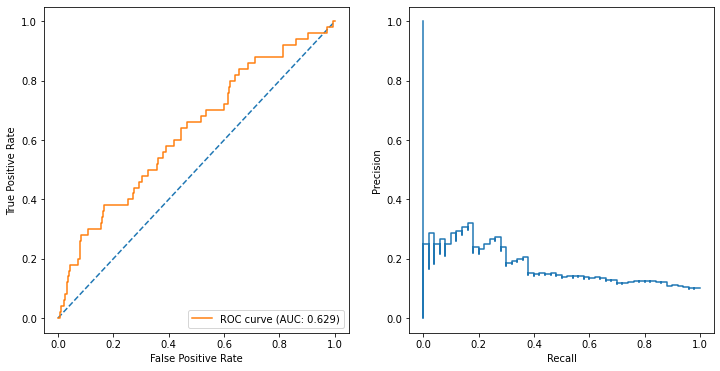

              precision    recall  f1-score   support

           0      0.927     0.422     0.580       450
           1      0.119     0.700     0.203        50

    accuracy                          0.450       500
   macro avg      0.523     0.561     0.392       500
weighted avg      0.846     0.450     0.542       500



[]

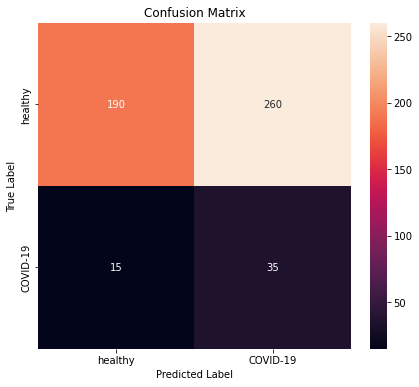

In [28]:
# choose best model
gs_model_2 = grid_search_2.best_estimator_.model

# make predictions on test data
y_test_pred = gs_model_2.predict_classes(X_test).reshape(-1)
y_test_probs = gs_model_2.predict_proba(X_test).reshape(-1)

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC: {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot()

## MFCC

In [29]:
X_train = train_mfccs
X_test = test_mfccs

In [30]:
def build_mlp(n_hidden = 1,
    hidden_dim = 16,
    loss_func = 'binary_crossentropy',
    kernel_initialiser = 'he_normal',
    hidden_activation = 'leaky_relu',
    final_activation = 'sigmoid',
    input_shape = (20, 431),
    dropout = False,
    dropout_p = 0.3,
    optimiser = 'SGD',
    learning_rate = 0.0001):

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))

    if hidden_activation == 'leaky_relu':
        model.add(keras.layers.Dense(hidden_dim, kernel_initializer="he_normal"))
        keras.layers.LeakyReLU(alpha=0.2)
    elif hidden_activation == 'selu':
        model.add(keras.layers.Dense(hidden_dim, kernel_initializer="lecun_normal"))
    else:
        model.add(keras.layers.Dense(hidden_dim, activation=hidden_activation, kernel_initializer=kernel_initialiser))

    if dropout:
        model.add(keras.layers.Dropout(dropout_p))

    if n_hidden > 1:
        for layer in range(n_hidden - 1):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Dense(hidden_dim, kernel_initializer="he_normal"))
                keras.layers.LeakyReLU(alpha=0.2)
            elif hidden_activation == 'selu':
                model.add(keras.layers.Dense(hidden_dim, kernel_initializer="lecun_normal"))
            else:
                model.add(keras.layers.Dense(hidden_dim, activation=hidden_activation, kernel_initializer=kernel_initialiser))

            if dropout:
                model.add(keras.layers.Dropout(dropout_p))

    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)
    
    model.compile(loss = loss_func, optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

mlp = keras.wrappers.scikit_learn.KerasClassifier(build_mlp)



### Baseline Model

In [ ]:
param_dist= {
    'n_hidden' : [1, 2, 3],
    'hidden_dim' : [4, 8, 16, 32], #remove 64
    'batch_size' : [16, 32], #removed 64
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal', 'lecun_normal'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'leaky_relu'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['momentum', 'Adam', 'Adamax'] #, # removed SGD
}

rnd_search_cv = model_selection.RandomizedSearchCV(mlp, param_dist, n_iter = 12, scoring =['roc_auc', 'recall'], refit = 'roc_auc',
                                                   cv=5, random_state = random_state, return_train_score = True)
rnd_search_cv.fit(X_train, y_train, epochs = 275)

In [41]:
rnd_search_cv.best_params_

{'optimiser': 'Adam',
 'n_hidden': 3,
 'loss_func': 'binary_crossentropy',
 'kernel_initialiser': 'he_normal',
 'input_shape': (20, 431),
 'hidden_dim': 32,
 'hidden_activation': 'selu',
 'final_activation': 'sigmoid',
 'batch_size': 32}

In [32]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([53.88324065]),
 'std_fit_time': array([0.29367998]),
 'mean_score_time': array([0.19184799]),
 'std_score_time': array([0.00932147]),
 'param_optimiser': masked_array(data=['Adam'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_hidden': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_loss_func': masked_array(data=['binary_crossentropy'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_normal'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_input_shape': masked_array(data=[(20, 431)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_dim': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['

### Fine-tuning baseline model

In [34]:
param_grid= {
    'n_hidden' : [2, 3, 4],
    'hidden_dim' : [16, 24, 32],
    'batch_size' : [16, 32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'dropout' : [False],
    'dropout_p': [0.3],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adam']
}

grid_search_1 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = "roc_auc", cv=5,
                                            return_train_score = True)
grid_search_1.fit(X_train, y_train, epochs = 275)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 8620)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                137936    
_________________________________________________________________
dense_25 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 17        
Total params: 138,225
Trainable params: 138,225
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/275
1600/1600 [==============================] - 1s 572us/sample - loss: 0.7478 - AUC: 0.4874
Epoch 2/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.7208 - AUC: 0.4967
Epoch 3/275
16

1600/1600 [==============================] - 0s 192us/sample - loss: 0.5470 - AUC: 0.7869
Epoch 72/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.5762 - AUC: 0.7598
Epoch 73/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.5642 - AUC: 0.7638
Epoch 74/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5615 - AUC: 0.7662
Epoch 75/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.5820 - AUC: 0.7493
Epoch 76/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.5328 - AUC: 0.8019
Epoch 77/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5377 - AUC: 0.7936
Epoch 78/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5363 - AUC: 0.7946
Epoch 79/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5429 - AUC: 0.7865
Epoch 80/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.59

1600/1600 [==============================] - 0s 196us/sample - loss: 0.4647 - AUC: 0.8542
Epoch 151/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4236 - AUC: 0.8788
Epoch 152/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4406 - AUC: 0.8655
Epoch 153/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4189 - AUC: 0.8812
Epoch 154/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4184 - AUC: 0.8845
Epoch 155/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4531 - AUC: 0.8567
Epoch 156/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4276 - AUC: 0.8762
Epoch 157/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4042 - AUC: 0.8930
Epoch 158/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4093 - AUC: 0.8896
Epoch 159/275
1600/1600 [==============================] - 0s 199us/sample - l

1600/1600 [==============================] - 0s 192us/sample - loss: 0.3365 - AUC: 0.9264
Epoch 229/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3099 - AUC: 0.9416
Epoch 230/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4073 - AUC: 0.8930
Epoch 231/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3111 - AUC: 0.9420
Epoch 232/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.2894 - AUC: 0.9532
Epoch 233/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3464 - AUC: 0.9202
Epoch 234/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3132 - AUC: 0.9394
Epoch 235/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3028 - AUC: 0.9437
Epoch 236/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4316 - AUC: 0.8889
Epoch 237/275
1600/1600 [==============================] - 0s 191us/sample - l

1600/1600 [==============================] - 0s 191us/sample - loss: 0.6466 - AUC: 0.6743
Epoch 24/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6561 - AUC: 0.6461
Epoch 25/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6704 - AUC: 0.6243
Epoch 26/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6745 - AUC: 0.6140
Epoch 27/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6476 - AUC: 0.6642
Epoch 28/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6389 - AUC: 0.6870
Epoch 29/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6452 - AUC: 0.6680
Epoch 30/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6555 - AUC: 0.6574
Epoch 31/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6559 - AUC: 0.6527
Epoch 32/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.64

1600/1600 [==============================] - 0s 190us/sample - loss: 0.4745 - AUC: 0.8499
Epoch 103/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4992 - AUC: 0.8256
Epoch 104/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.5032 - AUC: 0.8214
Epoch 105/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5506 - AUC: 0.7879
Epoch 106/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4723 - AUC: 0.8508
Epoch 107/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4987 - AUC: 0.8257
Epoch 108/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4932 - AUC: 0.8288
Epoch 109/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4683 - AUC: 0.8548
Epoch 110/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5238 - AUC: 0.8071
Epoch 111/275
1600/1600 [==============================] - 0s 189us/sample - l

1600/1600 [==============================] - 0s 193us/sample - loss: 0.3696 - AUC: 0.9133
Epoch 181/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4275 - AUC: 0.8791
Epoch 182/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.4033 - AUC: 0.8938
Epoch 183/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.4813 - AUC: 0.8496
Epoch 184/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4162 - AUC: 0.8829
Epoch 185/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.3648 - AUC: 0.9198
Epoch 186/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4066 - AUC: 0.8900
Epoch 187/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.4281 - AUC: 0.8784
Epoch 188/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3775 - AUC: 0.9086
Epoch 189/275
1600/1600 [==============================] - 0s 192us/sample - l

1600/1600 [==============================] - 0s 188us/sample - loss: 0.3224 - AUC: 0.9334
Epoch 259/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3125 - AUC: 0.9396
Epoch 260/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3241 - AUC: 0.9336
Epoch 261/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.2822 - AUC: 0.9545
Epoch 262/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.2979 - AUC: 0.9458
Epoch 263/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.2984 - AUC: 0.9460
Epoch 264/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3553 - AUC: 0.9187
Epoch 265/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2810 - AUC: 0.9537
Epoch 266/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2605 - AUC: 0.9615
Epoch 267/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 0s 188us/sample - loss: 0.6071 - AUC: 0.7155
Epoch 54/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5914 - AUC: 0.7427
Epoch 55/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6074 - AUC: 0.7191
Epoch 56/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5827 - AUC: 0.7547
Epoch 57/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5947 - AUC: 0.7327
Epoch 58/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5837 - AUC: 0.7487
Epoch 59/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5785 - AUC: 0.7538
Epoch 60/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.5857 - AUC: 0.7430
Epoch 61/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5853 - AUC: 0.7424
Epoch 62/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.56

1600/1600 [==============================] - 0s 188us/sample - loss: 0.4455 - AUC: 0.8658
Epoch 133/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4578 - AUC: 0.8581
Epoch 134/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4790 - AUC: 0.8414
Epoch 135/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4505 - AUC: 0.8609
Epoch 136/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4450 - AUC: 0.8666
Epoch 137/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4646 - AUC: 0.8492
Epoch 138/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5230 - AUC: 0.8182
Epoch 139/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4653 - AUC: 0.8527
Epoch 140/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4661 - AUC: 0.8513
Epoch 141/275
1600/1600 [==============================] - 0s 185us/sample - l

1600/1600 [==============================] - 0s 188us/sample - loss: 0.3454 - AUC: 0.9222
Epoch 211/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3425 - AUC: 0.9253
Epoch 212/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3811 - AUC: 0.9052
Epoch 213/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3404 - AUC: 0.9248
Epoch 214/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3326 - AUC: 0.9292
Epoch 215/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3495 - AUC: 0.9207
Epoch 216/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4040 - AUC: 0.8939
Epoch 217/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3229 - AUC: 0.9345
Epoch 218/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3442 - AUC: 0.9237
Epoch 219/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 0s 192us/sample - loss: 0.6977 - AUC: 0.5409
Epoch 6/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.7018 - AUC: 0.5349
Epoch 7/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6995 - AUC: 0.5423
Epoch 8/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.7085 - AUC: 0.5457
Epoch 9/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.7166 - AUC: 0.5344
Epoch 10/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.6949 - AUC: 0.5587
Epoch 11/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.7095 - AUC: 0.5420
Epoch 12/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6850 - AUC: 0.5815
Epoch 13/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6760 - AUC: 0.6066
Epoch 14/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6947 -

1600/1600 [==============================] - 0s 191us/sample - loss: 0.5284 - AUC: 0.8033
Epoch 85/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.5048 - AUC: 0.8234
Epoch 86/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5917 - AUC: 0.7504
Epoch 87/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.5048 - AUC: 0.8278
Epoch 88/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5373 - AUC: 0.7944
Epoch 89/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4946 - AUC: 0.8376
Epoch 90/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.5290 - AUC: 0.8002
Epoch 91/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4851 - AUC: 0.8469
Epoch 92/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5001 - AUC: 0.8262
Epoch 93/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.49

1600/1600 [==============================] - 0s 192us/sample - loss: 0.4078 - AUC: 0.8891
Epoch 164/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4266 - AUC: 0.8777
Epoch 165/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.3802 - AUC: 0.9085
Epoch 166/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4586 - AUC: 0.8637
Epoch 167/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.4169 - AUC: 0.8840
Epoch 168/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.3960 - AUC: 0.8971
Epoch 169/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4069 - AUC: 0.8896
Epoch 170/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3898 - AUC: 0.9000
Epoch 171/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4127 - AUC: 0.8894
Epoch 172/275
1600/1600 [==============================] - 0s 193us/sample - l

1600/1600 [==============================] - 0s 190us/sample - loss: 0.2835 - AUC: 0.9562
Epoch 242/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3212 - AUC: 0.9348
Epoch 243/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3540 - AUC: 0.9195
Epoch 244/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.2913 - AUC: 0.9509
Epoch 245/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.3795 - AUC: 0.9127
Epoch 246/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3662 - AUC: 0.9144
Epoch 247/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3130 - AUC: 0.9387
Epoch 248/275
1600/1600 [==============================] - ETA: 0s - loss: 0.3035 - AUC: 0.943 - 0s 192us/sample - loss: 0.3022 - AUC: 0.9441
Epoch 249/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3526 - AUC: 0.9201
Epoch 250/275
1600/1600 [===============

1600/1600 [==============================] - 0s 190us/sample - loss: 0.6580 - AUC: 0.6569
Epoch 36/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6315 - AUC: 0.6847
Epoch 37/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6368 - AUC: 0.6719
Epoch 38/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6170 - AUC: 0.7072
Epoch 39/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.6099 - AUC: 0.7300
Epoch 40/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6332 - AUC: 0.6885
Epoch 41/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6044 - AUC: 0.7312
Epoch 42/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6296 - AUC: 0.6963
Epoch 43/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.6091 - AUC: 0.7225
Epoch 44/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.65

1600/1600 [==============================] - 0s 203us/sample - loss: 0.5037 - AUC: 0.8221
Epoch 115/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4651 - AUC: 0.8543
Epoch 116/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4948 - AUC: 0.8267
Epoch 117/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4749 - AUC: 0.8444
Epoch 118/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4465 - AUC: 0.8699
Epoch 119/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.4482 - AUC: 0.8658
Epoch 120/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.5096 - AUC: 0.8204
Epoch 121/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4829 - AUC: 0.8384
Epoch 122/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4881 - AUC: 0.8360
Epoch 123/275
1600/1600 [==============================] - 0s 196us/sample - l

1600/1600 [==============================] - 0s 189us/sample - loss: 0.4188 - AUC: 0.8866
Epoch 193/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3624 - AUC: 0.9160
Epoch 194/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3888 - AUC: 0.9010
Epoch 195/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3749 - AUC: 0.9073
Epoch 196/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3759 - AUC: 0.9081
Epoch 197/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3364 - AUC: 0.9299
Epoch 198/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3860 - AUC: 0.9010
Epoch 199/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3676 - AUC: 0.9134
Epoch 200/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4836 - AUC: 0.8562
Epoch 201/275
1600/1600 [==============================] - 0s 193us/sample - l

1600/1600 [==============================] - 0s 189us/sample - loss: 0.2863 - AUC: 0.9482
Epoch 271/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2681 - AUC: 0.9555
Epoch 272/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.2718 - AUC: 0.9548
Epoch 273/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3571 - AUC: 0.9240
Epoch 274/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.2419 - AUC: 0.9667
Epoch 275/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.2868 - AUC: 0.9484
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 8620)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                137936    
_____________________________________

1600/1600 [==============================] - 0s 202us/sample - loss: 0.5794 - AUC: 0.7489
Epoch 65/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5586 - AUC: 0.7683
Epoch 66/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.6271 - AUC: 0.7084
Epoch 67/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5632 - AUC: 0.7662
Epoch 68/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5712 - AUC: 0.7596
Epoch 69/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5916 - AUC: 0.7340
Epoch 70/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.5598 - AUC: 0.7666
Epoch 71/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5512 - AUC: 0.7810
Epoch 72/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5462 - AUC: 0.7814
Epoch 73/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.53

1600/1600 [==============================] - 0s 202us/sample - loss: 0.4350 - AUC: 0.8722
Epoch 144/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4497 - AUC: 0.8583
Epoch 145/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4571 - AUC: 0.8523
Epoch 146/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4523 - AUC: 0.8588
Epoch 147/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4600 - AUC: 0.8586
Epoch 148/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4314 - AUC: 0.8743
Epoch 149/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4168 - AUC: 0.8856
Epoch 150/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4292 - AUC: 0.8748
Epoch 151/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4641 - AUC: 0.8530
Epoch 152/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 203us/sample - loss: 0.3372 - AUC: 0.9265
Epoch 222/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2977 - AUC: 0.9459
Epoch 223/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.2944 - AUC: 0.9469
Epoch 224/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3120 - AUC: 0.9376
Epoch 225/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3839 - AUC: 0.9052
Epoch 226/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3358 - AUC: 0.9277
Epoch 227/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3032 - AUC: 0.9424
Epoch 228/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3759 - AUC: 0.9107
Epoch 229/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3522 - AUC: 0.9190
Epoch 230/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 200us/sample - loss: 0.6883 - AUC: 0.5623
Epoch 16/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6892 - AUC: 0.5543
Epoch 17/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6812 - AUC: 0.6063
Epoch 18/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6785 - AUC: 0.6166
Epoch 19/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.6851 - AUC: 0.5830
Epoch 20/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6806 - AUC: 0.5886
Epoch 21/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.6781 - AUC: 0.5960
Epoch 22/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6787 - AUC: 0.5971
Epoch 23/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6818 - AUC: 0.5849
Epoch 24/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.67

1600/1600 [==============================] - 0s 201us/sample - loss: 0.5087 - AUC: 0.8149
Epoch 95/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.5371 - AUC: 0.7939
Epoch 96/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4925 - AUC: 0.8308
Epoch 97/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4928 - AUC: 0.8299
Epoch 98/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.5280 - AUC: 0.8062
Epoch 99/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4813 - AUC: 0.8430
Epoch 100/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5275 - AUC: 0.8021
Epoch 101/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5261 - AUC: 0.8134
Epoch 102/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5069 - AUC: 0.8218
Epoch 103/275
1600/1600 [==============================] - 0s 199us/sample - loss: 

Epoch 173/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3709 - AUC: 0.9124
Epoch 174/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3841 - AUC: 0.9023
Epoch 175/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.4579 - AUC: 0.8668
Epoch 176/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.4037 - AUC: 0.8918
Epoch 177/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3939 - AUC: 0.8975
Epoch 178/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4478 - AUC: 0.8703
Epoch 179/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3713 - AUC: 0.9136
Epoch 180/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3731 - AUC: 0.9097
Epoch 181/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3772 - AUC: 0.9071
Epoch 182/275
1600/1600 [==============================] - 0s 19

1600/1600 [==============================] - 0s 198us/sample - loss: 0.3114 - AUC: 0.9385
Epoch 252/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.2919 - AUC: 0.9469
Epoch 253/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3063 - AUC: 0.9400
Epoch 254/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.2484 - AUC: 0.9672
Epoch 255/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3864 - AUC: 0.9093
Epoch 256/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3523 - AUC: 0.9222
Epoch 257/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.2703 - AUC: 0.9571
Epoch 258/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.2892 - AUC: 0.9475
Epoch 259/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3995 - AUC: 0.9058
Epoch 260/275
1600/1600 [==============================] - 0s 199us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.6246 - AUC: 0.7104
Epoch 46/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.6185 - AUC: 0.7189
Epoch 47/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.6316 - AUC: 0.6879
Epoch 48/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6550 - AUC: 0.6592
Epoch 49/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6283 - AUC: 0.6881
Epoch 50/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.6264 - AUC: 0.6938
Epoch 51/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.5989 - AUC: 0.7471
Epoch 52/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6206 - AUC: 0.7049
Epoch 53/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.6166 - AUC: 0.7051
Epoch 54/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.59

1600/1600 [==============================] - 0s 201us/sample - loss: 0.4480 - AUC: 0.8616
Epoch 125/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4373 - AUC: 0.8724
Epoch 126/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4673 - AUC: 0.8483
Epoch 127/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4653 - AUC: 0.8477
Epoch 128/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4571 - AUC: 0.8531
Epoch 129/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4800 - AUC: 0.8405
Epoch 130/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4204 - AUC: 0.8875
Epoch 131/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4223 - AUC: 0.8828
Epoch 132/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4776 - AUC: 0.8432
Epoch 133/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 199us/sample - loss: 0.3537 - AUC: 0.9182
Epoch 203/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3856 - AUC: 0.9031
Epoch 204/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3784 - AUC: 0.9079
Epoch 205/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3641 - AUC: 0.9142
Epoch 206/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3491 - AUC: 0.9202
Epoch 207/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3356 - AUC: 0.9308
Epoch 208/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3347 - AUC: 0.9273
Epoch 209/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3388 - AUC: 0.9274
Epoch 210/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3588 - AUC: 0.9159
Epoch 211/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 1s 620us/sample - loss: 0.7322 - AUC: 0.5383
Epoch 2/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.7284 - AUC: 0.4895
Epoch 3/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6971 - AUC: 0.5454
Epoch 4/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.7097 - AUC: 0.5165
Epoch 5/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.6965 - AUC: 0.5413
Epoch 6/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6903 - AUC: 0.5587
Epoch 7/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.6915 - AUC: 0.5493
Epoch 8/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.6934 - AUC: 0.5261
Epoch 9/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.6907 - AUC: 0.5641
Epoch 10/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6890 - AUC

1600/1600 [==============================] - 0s 203us/sample - loss: 0.5055 - AUC: 0.8244
Epoch 81/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.5537 - AUC: 0.7854
Epoch 82/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5257 - AUC: 0.7991
Epoch 83/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5293 - AUC: 0.8005
Epoch 84/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.5132 - AUC: 0.8126
Epoch 85/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5301 - AUC: 0.7947
Epoch 86/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5370 - AUC: 0.7902
Epoch 87/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4982 - AUC: 0.8289
Epoch 88/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4931 - AUC: 0.8306
Epoch 89/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.47

1600/1600 [==============================] - 0s 203us/sample - loss: 0.4050 - AUC: 0.8908
Epoch 160/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4276 - AUC: 0.8756
Epoch 161/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4486 - AUC: 0.8657
Epoch 162/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3928 - AUC: 0.9022
Epoch 163/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4562 - AUC: 0.8597
Epoch 164/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4245 - AUC: 0.8800
Epoch 165/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3951 - AUC: 0.8987
Epoch 166/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4120 - AUC: 0.8855
Epoch 167/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.3773 - AUC: 0.9110
Epoch 168/275
1600/1600 [==============================] - 0s 204us/sample - l

1600/1600 [==============================] - 0s 203us/sample - loss: 0.3434 - AUC: 0.9249
Epoch 238/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3219 - AUC: 0.9336
Epoch 239/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4169 - AUC: 0.8949
Epoch 240/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4230 - AUC: 0.8896
Epoch 241/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3214 - AUC: 0.9364
Epoch 242/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.2805 - AUC: 0.9572
Epoch 243/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3030 - AUC: 0.9445
Epoch 244/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3312 - AUC: 0.9299
Epoch 245/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3696 - AUC: 0.9132
Epoch 246/275
1600/1600 [==============================] - 0s 203us/sample - l

1600/1600 [==============================] - 0s 199us/sample - loss: 0.6787 - AUC: 0.5920
Epoch 32/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6837 - AUC: 0.5792
Epoch 33/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6717 - AUC: 0.6247
Epoch 34/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.6776 - AUC: 0.6056
Epoch 35/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6720 - AUC: 0.6096
Epoch 36/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6675 - AUC: 0.6452
Epoch 37/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6694 - AUC: 0.6198
Epoch 38/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.6626 - AUC: 0.6333
Epoch 39/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6674 - AUC: 0.6260
Epoch 40/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.65

1600/1600 [==============================] - 0s 199us/sample - loss: 0.4468 - AUC: 0.8699
Epoch 111/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4845 - AUC: 0.8345
Epoch 112/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4672 - AUC: 0.8476
Epoch 113/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.5069 - AUC: 0.8206
Epoch 114/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4593 - AUC: 0.8569
Epoch 115/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4863 - AUC: 0.8355
Epoch 116/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4742 - AUC: 0.8452
Epoch 117/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4521 - AUC: 0.8652
Epoch 118/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4469 - AUC: 0.8653
Epoch 119/275
1600/1600 [==============================] - 0s 199us/sample - l

1600/1600 [==============================] - 0s 201us/sample - loss: 0.4590 - AUC: 0.8674
Epoch 189/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3980 - AUC: 0.8959
Epoch 190/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3554 - AUC: 0.9205
Epoch 191/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3686 - AUC: 0.9134
Epoch 192/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3922 - AUC: 0.8967
Epoch 193/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.3542 - AUC: 0.9200
Epoch 194/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3371 - AUC: 0.9294
Epoch 195/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.3664 - AUC: 0.9137
Epoch 196/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3748 - AUC: 0.9097
Epoch 197/275
1600/1600 [==============================] - 0s 206us/sample - l

1600/1600 [==============================] - 0s 206us/sample - loss: 0.2891 - AUC: 0.9473
Epoch 267/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2717 - AUC: 0.9545
Epoch 268/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2444 - AUC: 0.9652
Epoch 269/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3267 - AUC: 0.9330
Epoch 270/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2537 - AUC: 0.9617
Epoch 271/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2421 - AUC: 0.9645
Epoch 272/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3592 - AUC: 0.9206
Epoch 273/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3197 - AUC: 0.9363
Epoch 274/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2802 - AUC: 0.9503
Epoch 275/275
1600/1600 [==============================] - 0s 202us/sample - l

1600/1600 [==============================] - 0s 210us/sample - loss: 0.5806 - AUC: 0.7472
Epoch 60/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6007 - AUC: 0.7200
Epoch 61/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5621 - AUC: 0.7734
Epoch 62/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.5501 - AUC: 0.7837
Epoch 63/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5615 - AUC: 0.7632
Epoch 64/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.6025 - AUC: 0.7264
Epoch 65/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.5986 - AUC: 0.7224
Epoch 66/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5798 - AUC: 0.7430
Epoch 67/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5645 - AUC: 0.7639
Epoch 68/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.53

1600/1600 [==============================] - 0s 212us/sample - loss: 0.4658 - AUC: 0.8475
Epoch 139/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4395 - AUC: 0.8732
Epoch 140/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4336 - AUC: 0.8678
Epoch 141/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4465 - AUC: 0.8604
Epoch 142/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4701 - AUC: 0.8448
Epoch 143/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4125 - AUC: 0.8893
Epoch 144/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4725 - AUC: 0.8463
Epoch 145/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4273 - AUC: 0.8760
Epoch 146/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4732 - AUC: 0.8466
Epoch 147/275
1600/1600 [==============================] - 0s 208us/sample - l

1600/1600 [==============================] - 0s 209us/sample - loss: 0.3331 - AUC: 0.9277
Epoch 217/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3141 - AUC: 0.9375
Epoch 218/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3859 - AUC: 0.9057
Epoch 219/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4004 - AUC: 0.8968
Epoch 220/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3853 - AUC: 0.9036
Epoch 221/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3335 - AUC: 0.9282
Epoch 222/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3073 - AUC: 0.9428
Epoch 223/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3239 - AUC: 0.9333
Epoch 224/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3552 - AUC: 0.9170
Epoch 225/275
1600/1600 [==============================] - 0s 213us/sample - l

1600/1600 [==============================] - 0s 212us/sample - loss: 0.6975 - AUC: 0.5446
Epoch 9/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6949 - AUC: 0.5441
Epoch 10/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6956 - AUC: 0.5426
Epoch 11/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6866 - AUC: 0.5777
Epoch 12/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6861 - AUC: 0.5716
Epoch 13/275
1600/1600 [==============================] - 0s 220us/sample - loss: 0.6888 - AUC: 0.5583
Epoch 14/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6915 - AUC: 0.5514
Epoch 15/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.6833 - AUC: 0.5781
Epoch 16/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6852 - AUC: 0.5720
Epoch 17/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.685

1600/1600 [==============================] - 0s 211us/sample - loss: 0.5441 - AUC: 0.7909
Epoch 88/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.5203 - AUC: 0.8083
Epoch 89/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.5112 - AUC: 0.8157
Epoch 90/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5016 - AUC: 0.8227
Epoch 91/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.5263 - AUC: 0.8001
Epoch 92/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5864 - AUC: 0.7597
Epoch 93/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5527 - AUC: 0.7782
Epoch 94/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4926 - AUC: 0.8398
Epoch 95/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4896 - AUC: 0.8373
Epoch 96/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.49

1600/1600 [==============================] - 0s 214us/sample - loss: 0.3763 - AUC: 0.9107
Epoch 167/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3712 - AUC: 0.9117
Epoch 168/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3676 - AUC: 0.9114
Epoch 169/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4101 - AUC: 0.8885
Epoch 170/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3842 - AUC: 0.9025
Epoch 171/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3495 - AUC: 0.9242
Epoch 172/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4270 - AUC: 0.8837
Epoch 173/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3853 - AUC: 0.9021
Epoch 174/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3520 - AUC: 0.9217
Epoch 175/275
1600/1600 [==============================] - 0s 209us/sample - l

1600/1600 [==============================] - 0s 209us/sample - loss: 0.3252 - AUC: 0.9337
Epoch 245/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3264 - AUC: 0.9324
Epoch 246/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3332 - AUC: 0.9298
Epoch 247/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.2739 - AUC: 0.9575
Epoch 248/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.2722 - AUC: 0.9553
Epoch 249/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3688 - AUC: 0.9160
Epoch 250/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.2947 - AUC: 0.9463
Epoch 251/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.2868 - AUC: 0.9502
Epoch 252/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3488 - AUC: 0.9232
Epoch 253/275
1600/1600 [==============================] - 0s 211us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.6538 - AUC: 0.6467
Epoch 38/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.7095 - AUC: 0.5780
Epoch 39/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.6658 - AUC: 0.6235
Epoch 40/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6734 - AUC: 0.6130
Epoch 41/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6440 - AUC: 0.6923
Epoch 42/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6375 - AUC: 0.6861
Epoch 43/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6401 - AUC: 0.6773
Epoch 44/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6346 - AUC: 0.6839
Epoch 45/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.6361 - AUC: 0.6760
Epoch 46/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.62

1600/1600 [==============================] - 0s 216us/sample - loss: 0.4478 - AUC: 0.8649
Epoch 117/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4657 - AUC: 0.8483
Epoch 118/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4941 - AUC: 0.8327
Epoch 119/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.4892 - AUC: 0.8332
Epoch 120/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4750 - AUC: 0.8445
Epoch 121/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4783 - AUC: 0.8373
Epoch 122/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4819 - AUC: 0.8416
Epoch 123/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.4505 - AUC: 0.8669
Epoch 124/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4467 - AUC: 0.8623
Epoch 125/275
1600/1600 [==============================] - 0s 216us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.3408 - AUC: 0.9245
Epoch 195/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3396 - AUC: 0.9258
Epoch 196/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3941 - AUC: 0.8997
Epoch 197/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4087 - AUC: 0.8898
Epoch 198/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4265 - AUC: 0.8802
Epoch 199/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3314 - AUC: 0.9331
Epoch 200/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3388 - AUC: 0.9272
Epoch 201/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3259 - AUC: 0.9330
Epoch 202/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3333 - AUC: 0.9283
Epoch 203/275
1600/1600 [==============================] - 0s 211us/sample - l

1600/1600 [==============================] - 0s 216us/sample - loss: 0.2955 - AUC: 0.9453
Epoch 273/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2451 - AUC: 0.9633
Epoch 274/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2922 - AUC: 0.9466
Epoch 275/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2736 - AUC: 0.9529
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 8620)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 16)                137936    
_________________________________________________________________
dense_75 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_76 (Dense)             (None, 16)        

1600/1600 [==============================] - 0s 211us/sample - loss: 0.5803 - AUC: 0.7486
Epoch 66/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.5478 - AUC: 0.7872
Epoch 67/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6071 - AUC: 0.7269
Epoch 68/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5630 - AUC: 0.7696
Epoch 69/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5785 - AUC: 0.7541
Epoch 70/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5218 - AUC: 0.8240
Epoch 71/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5273 - AUC: 0.8033
Epoch 72/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5581 - AUC: 0.7710
Epoch 73/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.5816 - AUC: 0.7519
Epoch 74/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.55

1600/1600 [==============================] - 0s 214us/sample - loss: 0.4188 - AUC: 0.8828
Epoch 145/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4090 - AUC: 0.8891
Epoch 146/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4065 - AUC: 0.8896
Epoch 147/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4654 - AUC: 0.8557
Epoch 148/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4818 - AUC: 0.8450
Epoch 149/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4561 - AUC: 0.8580
Epoch 150/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4140 - AUC: 0.8874
Epoch 151/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4112 - AUC: 0.8884
Epoch 152/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4317 - AUC: 0.8708
Epoch 153/275
1600/1600 [==============================] - 0s 216us/sample - l

1600/1600 [==============================] - 0s 215us/sample - loss: 0.3171 - AUC: 0.9386
Epoch 223/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3286 - AUC: 0.9315
Epoch 224/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3329 - AUC: 0.9298
Epoch 225/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4640 - AUC: 0.8749
Epoch 226/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3035 - AUC: 0.9488
Epoch 227/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3253 - AUC: 0.9331
Epoch 228/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3009 - AUC: 0.9451
Epoch 229/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3512 - AUC: 0.9199
Epoch 230/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3275 - AUC: 0.9316
Epoch 231/275
1600/1600 [==============================] - 0s 208us/sample - l

1600/1600 [==============================] - 0s 206us/sample - loss: 0.6881 - AUC: 0.5629
Epoch 15/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.6875 - AUC: 0.5615
Epoch 16/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.6900 - AUC: 0.5586
Epoch 17/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.6868 - AUC: 0.5638
Epoch 18/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.6855 - AUC: 0.5746
Epoch 19/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.6848 - AUC: 0.5728
Epoch 20/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.6836 - AUC: 0.5841
Epoch 21/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.6810 - AUC: 0.5912
Epoch 22/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.6894 - AUC: 0.5633
Epoch 23/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.67

1600/1600 [==============================] - 0s 207us/sample - loss: 0.4944 - AUC: 0.8295
Epoch 94/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5079 - AUC: 0.8169
Epoch 95/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4964 - AUC: 0.8273
Epoch 96/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5073 - AUC: 0.8161
Epoch 97/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5280 - AUC: 0.8038
Epoch 98/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5057 - AUC: 0.8192
Epoch 99/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4918 - AUC: 0.8315
Epoch 100/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5577 - AUC: 0.7813
Epoch 101/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.5225 - AUC: 0.8082
Epoch 102/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3674 - AUC: 0.9149
Epoch 173/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3737 - AUC: 0.9090
Epoch 174/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3822 - AUC: 0.9034
Epoch 175/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.3672 - AUC: 0.9112
Epoch 176/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.3941 - AUC: 0.8972
Epoch 177/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4105 - AUC: 0.8893
Epoch 178/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3527 - AUC: 0.9219
Epoch 179/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4035 - AUC: 0.8906
Epoch 180/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3670 - AUC: 0.9120
Epoch 181/275
1600/1600 [==============================] - 0s 20

1600/1600 [==============================] - 0s 206us/sample - loss: 0.3513 - AUC: 0.9204
Epoch 251/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2775 - AUC: 0.9555
Epoch 252/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2952 - AUC: 0.9459
Epoch 253/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.2658 - AUC: 0.9587
Epoch 254/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3410 - AUC: 0.9250
Epoch 255/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.2691 - AUC: 0.9561
Epoch 256/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3032 - AUC: 0.9408
Epoch 257/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2683 - AUC: 0.9563
Epoch 258/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2701 - AUC: 0.9553
Epoch 259/275
1600/1600 [==============================] - 0s 209us/sample - l

1600/1600 [==============================] - 0s 186us/sample - loss: 0.6462 - AUC: 0.6642
Epoch 46/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6294 - AUC: 0.6964
Epoch 47/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6413 - AUC: 0.6732
Epoch 48/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.6125 - AUC: 0.7256
Epoch 49/275
1600/1600 [==============================] - 0s 184us/sample - loss: 0.6266 - AUC: 0.6882
Epoch 50/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.6218 - AUC: 0.6955
Epoch 51/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.6096 - AUC: 0.7144
Epoch 52/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5992 - AUC: 0.7297
Epoch 53/275
1600/1600 [==============================] - 0s 185us/sample - loss: 0.5890 - AUC: 0.7476
Epoch 54/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.60

1600/1600 [==============================] - 0s 190us/sample - loss: 0.4593 - AUC: 0.8547
Epoch 125/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4577 - AUC: 0.8570
Epoch 126/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4820 - AUC: 0.8354
Epoch 127/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4423 - AUC: 0.8657
Epoch 128/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4543 - AUC: 0.8573
Epoch 129/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4916 - AUC: 0.8343
Epoch 130/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4525 - AUC: 0.8583
Epoch 131/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4694 - AUC: 0.8464
Epoch 132/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4798 - AUC: 0.8413
Epoch 133/275
1600/1600 [==============================] - 0s 184us/sample - l

1600/1600 [==============================] - 0s 186us/sample - loss: 0.3757 - AUC: 0.9049
Epoch 203/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4140 - AUC: 0.8863
Epoch 204/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3726 - AUC: 0.9075
Epoch 205/275
1600/1600 [==============================] - 0s 184us/sample - loss: 0.4066 - AUC: 0.8901
Epoch 206/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3373 - AUC: 0.9321
Epoch 207/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3357 - AUC: 0.9301
Epoch 208/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3486 - AUC: 0.9222
Epoch 209/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3348 - AUC: 0.9297
Epoch 210/275
1600/1600 [==============================] - 0s 185us/sample - loss: 0.4186 - AUC: 0.8877
Epoch 211/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 1s 576us/sample - loss: 0.7592 - AUC: 0.5072
Epoch 2/275
1600/1600 [==============================] - 0s 185us/sample - loss: 0.7160 - AUC: 0.5006
Epoch 3/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.7318 - AUC: 0.5453
Epoch 4/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.7096 - AUC: 0.5239
Epoch 5/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.7058 - AUC: 0.5371
Epoch 6/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6972 - AUC: 0.5523
Epoch 7/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.7024 - AUC: 0.5654
Epoch 8/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6926 - AUC: 0.5679
Epoch 9/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.7225 - AUC: 0.5453
Epoch 10/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6874 - AUC

1600/1600 [==============================] - 0s 189us/sample - loss: 0.5485 - AUC: 0.7886
Epoch 81/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.5437 - AUC: 0.7873
Epoch 82/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5719 - AUC: 0.7622
Epoch 83/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5471 - AUC: 0.7844
Epoch 84/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5478 - AUC: 0.7839
Epoch 85/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5364 - AUC: 0.7939
Epoch 86/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.5685 - AUC: 0.7616
Epoch 87/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.5420 - AUC: 0.7886
Epoch 88/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5455 - AUC: 0.7793
Epoch 89/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.53

1600/1600 [==============================] - 0s 185us/sample - loss: 0.4003 - AUC: 0.9005
Epoch 160/275
1600/1600 [==============================] - 0s 184us/sample - loss: 0.4385 - AUC: 0.8703
Epoch 161/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4191 - AUC: 0.8820
Epoch 162/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4161 - AUC: 0.8853
Epoch 163/275
1600/1600 [==============================] - 0s 185us/sample - loss: 0.4350 - AUC: 0.8730
Epoch 164/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4800 - AUC: 0.8483
Epoch 165/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4242 - AUC: 0.8806
Epoch 166/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4314 - AUC: 0.8791
Epoch 167/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4034 - AUC: 0.8953
Epoch 168/275
1600/1600 [==============================] - 0s 187us/sample - l

1600/1600 [==============================] - 0s 186us/sample - loss: 0.3458 - AUC: 0.9230
Epoch 238/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4640 - AUC: 0.8785
Epoch 239/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3423 - AUC: 0.9250
Epoch 240/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3036 - AUC: 0.9451
Epoch 241/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3002 - AUC: 0.9455
Epoch 242/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.2993 - AUC: 0.9459
Epoch 243/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2732 - AUC: 0.9585
Epoch 244/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3309 - AUC: 0.9303
Epoch 245/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3855 - AUC: 0.9062
Epoch 246/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 0s 186us/sample - loss: 0.6824 - AUC: 0.6078
Epoch 33/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6628 - AUC: 0.6317
Epoch 34/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6386 - AUC: 0.6995
Epoch 35/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6310 - AUC: 0.6908
Epoch 36/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6216 - AUC: 0.7323
Epoch 37/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6393 - AUC: 0.6765
Epoch 38/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6674 - AUC: 0.6450
Epoch 39/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6457 - AUC: 0.6686
Epoch 40/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6940 - AUC: 0.6046
Epoch 41/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.63

1600/1600 [==============================] - 0s 188us/sample - loss: 0.5216 - AUC: 0.8065
Epoch 112/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.5337 - AUC: 0.7980
Epoch 113/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4609 - AUC: 0.8606
Epoch 114/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4678 - AUC: 0.8516
Epoch 115/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4700 - AUC: 0.8463
Epoch 116/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4861 - AUC: 0.8349
Epoch 117/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4568 - AUC: 0.8591
Epoch 118/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4901 - AUC: 0.8296
Epoch 119/275
1600/1600 [==============================] - 0s 185us/sample - loss: 0.4606 - AUC: 0.8505
Epoch 120/275
1600/1600 [==============================] - 0s 186us/sample - l

1600/1600 [==============================] - 0s 186us/sample - loss: 0.4020 - AUC: 0.8926
Epoch 190/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3515 - AUC: 0.9254
Epoch 191/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4478 - AUC: 0.8707
Epoch 192/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3539 - AUC: 0.9247
Epoch 193/275
1600/1600 [==============================] - 0s 184us/sample - loss: 0.3310 - AUC: 0.9393
Epoch 194/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3599 - AUC: 0.9179
Epoch 195/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3608 - AUC: 0.9168
Epoch 196/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3622 - AUC: 0.9151
Epoch 197/275
1600/1600 [==============================] - 0s 184us/sample - loss: 0.3617 - AUC: 0.9140
Epoch 198/275
1600/1600 [==============================] - 0s 189us/sample - l

1600/1600 [==============================] - 0s 195us/sample - loss: 0.2686 - AUC: 0.9563
Epoch 268/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.2863 - AUC: 0.9477
Epoch 269/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.2825 - AUC: 0.9499
Epoch 270/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3152 - AUC: 0.9366
Epoch 271/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3467 - AUC: 0.9237
Epoch 272/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2450 - AUC: 0.9663
Epoch 273/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.2397 - AUC: 0.9664
Epoch 274/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.2693 - AUC: 0.9552
Epoch 275/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3195 - AUC: 0.9352
Model: "sequential_30"
_______________________________________________________

1600/1600 [==============================] - 0s 187us/sample - loss: 0.5530 - AUC: 0.7843
Epoch 63/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.5473 - AUC: 0.7841
Epoch 64/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5389 - AUC: 0.7945
Epoch 65/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5479 - AUC: 0.7786
Epoch 66/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6063 - AUC: 0.7385
Epoch 67/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5606 - AUC: 0.7682
Epoch 68/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5453 - AUC: 0.7886
Epoch 69/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5631 - AUC: 0.7642
Epoch 70/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.5327 - AUC: 0.7990
Epoch 71/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.55

1600/1600 [==============================] - 0s 186us/sample - loss: 0.4797 - AUC: 0.8465
Epoch 142/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4655 - AUC: 0.8544
Epoch 143/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4626 - AUC: 0.8510
Epoch 144/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4231 - AUC: 0.8828
Epoch 145/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3930 - AUC: 0.9084
Epoch 146/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4467 - AUC: 0.8634
Epoch 147/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3974 - AUC: 0.9008
Epoch 148/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4558 - AUC: 0.8616
Epoch 149/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4701 - AUC: 0.8525
Epoch 150/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 0s 185us/sample - loss: 0.3413 - AUC: 0.9243
Epoch 220/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3473 - AUC: 0.9221
Epoch 221/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3186 - AUC: 0.9385
Epoch 222/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3359 - AUC: 0.9281
Epoch 223/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4079 - AUC: 0.8968
Epoch 224/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3749 - AUC: 0.9089
Epoch 225/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3846 - AUC: 0.9045
Epoch 226/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3214 - AUC: 0.9371
Epoch 227/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3161 - AUC: 0.9397
Epoch 228/275
1600/1600 [==============================] - 0s 186us/sample - l

1600/1600 [==============================] - 0s 188us/sample - loss: 0.6823 - AUC: 0.5791
Epoch 15/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6869 - AUC: 0.5714
Epoch 16/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6723 - AUC: 0.6492
Epoch 17/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6667 - AUC: 0.6310
Epoch 18/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.6780 - AUC: 0.5941
Epoch 19/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6694 - AUC: 0.6235
Epoch 20/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6719 - AUC: 0.6130
Epoch 21/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6640 - AUC: 0.6351
Epoch 22/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6556 - AUC: 0.6557
Epoch 23/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.65

1600/1600 [==============================] - 0s 186us/sample - loss: 0.5349 - AUC: 0.7951
Epoch 94/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5050 - AUC: 0.8259
Epoch 95/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4991 - AUC: 0.8278
Epoch 96/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4936 - AUC: 0.8327
Epoch 97/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5037 - AUC: 0.8214
Epoch 98/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5603 - AUC: 0.7895
Epoch 99/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5182 - AUC: 0.8112
Epoch 100/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5019 - AUC: 0.8215
Epoch 101/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.4898 - AUC: 0.8389
Epoch 102/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.4037 - AUC: 0.8933
Epoch 173/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3889 - AUC: 0.9012
Epoch 174/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3938 - AUC: 0.8973
Epoch 175/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3636 - AUC: 0.9191
Epoch 176/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3954 - AUC: 0.8977
Epoch 177/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4547 - AUC: 0.8616
Epoch 178/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3602 - AUC: 0.9209
Epoch 179/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.4522 - AUC: 0.8632
Epoch 180/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4099 - AUC: 0.8919
Epoch 181/275
1600/1600 [==============================] - 0s 19

1600/1600 [==============================] - 0s 187us/sample - loss: 0.3262 - AUC: 0.9317
Epoch 251/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3265 - AUC: 0.9323
Epoch 252/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.2939 - AUC: 0.9461
Epoch 253/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3230 - AUC: 0.9323
Epoch 254/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3142 - AUC: 0.9374
Epoch 255/275
1600/1600 [==============================] - 0s 185us/sample - loss: 0.2667 - AUC: 0.9592
Epoch 256/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3155 - AUC: 0.9369
Epoch 257/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3733 - AUC: 0.9125
Epoch 258/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.2698 - AUC: 0.9579
Epoch 259/275
1600/1600 [==============================] - 0s 187us/sample - l

1600/1600 [==============================] - 0s 198us/sample - loss: 0.6643 - AUC: 0.6386
Epoch 45/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6386 - AUC: 0.6800
Epoch 46/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6410 - AUC: 0.6852
Epoch 47/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6390 - AUC: 0.6760
Epoch 48/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.6308 - AUC: 0.6895
Epoch 49/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6175 - AUC: 0.7053
Epoch 50/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.6064 - AUC: 0.7233
Epoch 51/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.6196 - AUC: 0.7026
Epoch 52/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.6110 - AUC: 0.7158
Epoch 53/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.59

1600/1600 [==============================] - 0s 198us/sample - loss: 0.4511 - AUC: 0.8605
Epoch 124/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4549 - AUC: 0.8533
Epoch 125/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4425 - AUC: 0.8653
Epoch 126/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5089 - AUC: 0.8273
Epoch 127/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4401 - AUC: 0.8707
Epoch 128/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4684 - AUC: 0.8474
Epoch 129/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4998 - AUC: 0.8259
Epoch 130/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4634 - AUC: 0.8513
Epoch 131/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4393 - AUC: 0.8701
Epoch 132/275
1600/1600 [==============================] - 0s 198us/sample - l

1600/1600 [==============================] - 0s 198us/sample - loss: 0.3584 - AUC: 0.9153
Epoch 202/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4468 - AUC: 0.8711
Epoch 203/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.3411 - AUC: 0.9266
Epoch 204/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4567 - AUC: 0.8709
Epoch 205/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3523 - AUC: 0.9224
Epoch 206/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3678 - AUC: 0.9116
Epoch 207/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3579 - AUC: 0.9176
Epoch 208/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3876 - AUC: 0.9019
Epoch 209/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3394 - AUC: 0.9276
Epoch 210/275
1600/1600 [==============================] - 0s 198us/sample - l

1600/1600 [==============================] - 1s 640us/sample - loss: 0.7434 - AUC: 0.4967
Epoch 2/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.7193 - AUC: 0.4957
Epoch 3/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.7070 - AUC: 0.5221
Epoch 4/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.7148 - AUC: 0.5127
Epoch 5/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.7016 - AUC: 0.5261
Epoch 6/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6925 - AUC: 0.5475
Epoch 7/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6940 - AUC: 0.5355
Epoch 8/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6943 - AUC: 0.5502
Epoch 9/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6922 - AUC: 0.5427
Epoch 10/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6958 - AUC

1600/1600 [==============================] - 0s 198us/sample - loss: 0.5683 - AUC: 0.7617
Epoch 81/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.5492 - AUC: 0.7816
Epoch 82/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5576 - AUC: 0.7738
Epoch 83/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5679 - AUC: 0.7634
Epoch 84/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.5283 - AUC: 0.8076
Epoch 85/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.5224 - AUC: 0.8089
Epoch 86/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5152 - AUC: 0.8132
Epoch 87/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6170 - AUC: 0.7394
Epoch 88/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.5162 - AUC: 0.8172
Epoch 89/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.53

1600/1600 [==============================] - 0s 198us/sample - loss: 0.4715 - AUC: 0.8506
Epoch 160/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3950 - AUC: 0.9035
Epoch 161/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4145 - AUC: 0.8867
Epoch 162/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4686 - AUC: 0.8571
Epoch 163/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.4007 - AUC: 0.8985
Epoch 164/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4364 - AUC: 0.8717
Epoch 165/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4320 - AUC: 0.8774
Epoch 166/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4304 - AUC: 0.8758
Epoch 167/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.4118 - AUC: 0.8892
Epoch 168/275
1600/1600 [==============================] - 0s 198us/sample - l

1600/1600 [==============================] - 0s 200us/sample - loss: 0.3510 - AUC: 0.9209
Epoch 238/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3439 - AUC: 0.9244
Epoch 239/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3133 - AUC: 0.9421
Epoch 240/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3365 - AUC: 0.9266
Epoch 241/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3858 - AUC: 0.9061
Epoch 242/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.3310 - AUC: 0.9307
Epoch 243/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3069 - AUC: 0.9431
Epoch 244/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3294 - AUC: 0.9304
Epoch 245/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.3917 - AUC: 0.9040
Epoch 246/275
1600/1600 [==============================] - 0s 196us/sample - l

1600/1600 [==============================] - 0s 198us/sample - loss: 0.6651 - AUC: 0.6234
Epoch 32/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.6555 - AUC: 0.6583
Epoch 33/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.6647 - AUC: 0.6276
Epoch 34/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.6506 - AUC: 0.6604
Epoch 35/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6810 - AUC: 0.6080
Epoch 36/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6576 - AUC: 0.6472
Epoch 37/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6521 - AUC: 0.6542
Epoch 38/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6602 - AUC: 0.6379
Epoch 39/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6519 - AUC: 0.6619
Epoch 40/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.64

1600/1600 [==============================] - 0s 203us/sample - loss: 0.4685 - AUC: 0.8478
Epoch 111/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4770 - AUC: 0.8420
Epoch 112/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.5292 - AUC: 0.8009
Epoch 113/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4725 - AUC: 0.8424
Epoch 114/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4639 - AUC: 0.8554
Epoch 115/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.4934 - AUC: 0.8242
Epoch 116/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4510 - AUC: 0.8616
Epoch 117/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4966 - AUC: 0.8261
Epoch 118/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5040 - AUC: 0.8204
Epoch 119/275
1600/1600 [==============================] - 0s 204us/sample - l

1600/1600 [==============================] - 0s 202us/sample - loss: 0.4433 - AUC: 0.8768
Epoch 189/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3526 - AUC: 0.9213
Epoch 190/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3653 - AUC: 0.9141
Epoch 191/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4271 - AUC: 0.8840
Epoch 192/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3812 - AUC: 0.9028
Epoch 193/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.3601 - AUC: 0.9160
Epoch 194/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4018 - AUC: 0.8923
Epoch 195/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3846 - AUC: 0.9013
Epoch 196/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3664 - AUC: 0.9117
Epoch 197/275
1600/1600 [==============================] - 0s 199us/sample - l

1600/1600 [==============================] - 0s 201us/sample - loss: 0.2990 - AUC: 0.9440
Epoch 267/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2745 - AUC: 0.9524
Epoch 268/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.2637 - AUC: 0.9572
Epoch 269/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3208 - AUC: 0.9365
Epoch 270/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2672 - AUC: 0.9554
Epoch 271/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2548 - AUC: 0.9594
Epoch 272/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.2680 - AUC: 0.9548
Epoch 273/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2952 - AUC: 0.9455
Epoch 274/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.2737 - AUC: 0.9526
Epoch 275/275
1600/1600 [==============================] - 0s 203us/sample - l

1600/1600 [==============================] - 0s 204us/sample - loss: 0.5990 - AUC: 0.7316
Epoch 61/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.5631 - AUC: 0.7712
Epoch 62/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.5558 - AUC: 0.7791
Epoch 63/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.5564 - AUC: 0.7756
Epoch 64/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5613 - AUC: 0.7699
Epoch 65/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.5583 - AUC: 0.7763
Epoch 66/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5540 - AUC: 0.7775
Epoch 67/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5784 - AUC: 0.7512
Epoch 68/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5375 - AUC: 0.7966
Epoch 69/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.53

1600/1600 [==============================] - 0s 200us/sample - loss: 0.4419 - AUC: 0.8721
Epoch 140/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4763 - AUC: 0.8482
Epoch 141/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4227 - AUC: 0.8826
Epoch 142/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4317 - AUC: 0.8745
Epoch 143/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4012 - AUC: 0.8969
Epoch 144/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4184 - AUC: 0.8813
Epoch 145/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4539 - AUC: 0.8612
Epoch 146/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4504 - AUC: 0.8630
Epoch 147/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4584 - AUC: 0.8573
Epoch 148/275
1600/1600 [==============================] - 0s 202us/sample - l

1600/1600 [==============================] - 0s 203us/sample - loss: 0.3802 - AUC: 0.9057
Epoch 218/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3293 - AUC: 0.9334
Epoch 219/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3625 - AUC: 0.9148
Epoch 220/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3287 - AUC: 0.9320
Epoch 221/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3877 - AUC: 0.9038
Epoch 222/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3188 - AUC: 0.9376
Epoch 223/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3595 - AUC: 0.9166
Epoch 224/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4256 - AUC: 0.8881
Epoch 225/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3261 - AUC: 0.9352
Epoch 226/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 201us/sample - loss: 0.6979 - AUC: 0.5231
Epoch 12/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6880 - AUC: 0.5580
Epoch 13/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6847 - AUC: 0.5735
Epoch 14/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6844 - AUC: 0.5706
Epoch 15/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6893 - AUC: 0.5584
Epoch 16/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6837 - AUC: 0.5720
Epoch 17/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6830 - AUC: 0.5782
Epoch 18/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6847 - AUC: 0.5705
Epoch 19/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6813 - AUC: 0.5914
Epoch 20/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.68

1600/1600 [==============================] - 0s 199us/sample - loss: 0.5516 - AUC: 0.7819
Epoch 91/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.5034 - AUC: 0.8230
Epoch 92/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.5218 - AUC: 0.8061
Epoch 93/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5165 - AUC: 0.8083
Epoch 94/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4716 - AUC: 0.8553
Epoch 95/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.5388 - AUC: 0.7939
Epoch 96/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.5329 - AUC: 0.7980
Epoch 97/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4853 - AUC: 0.8420
Epoch 98/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4783 - AUC: 0.8484
Epoch 99/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.52

Epoch 169/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4133 - AUC: 0.8854
Epoch 170/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.3749 - AUC: 0.9106
Epoch 171/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.3996 - AUC: 0.8934
Epoch 172/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4751 - AUC: 0.8549
Epoch 173/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4210 - AUC: 0.8853
Epoch 174/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3939 - AUC: 0.8976
Epoch 175/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3728 - AUC: 0.9124
Epoch 176/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4013 - AUC: 0.8938
Epoch 177/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4078 - AUC: 0.8902
Epoch 178/275
1600/1600 [==============================] - 0s 20

1600/1600 [==============================] - 0s 201us/sample - loss: 0.2767 - AUC: 0.9556
Epoch 248/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3097 - AUC: 0.9389
Epoch 249/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.2851 - AUC: 0.9509
Epoch 250/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3122 - AUC: 0.9377
Epoch 251/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.2749 - AUC: 0.9551
Epoch 252/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.3530 - AUC: 0.9228
Epoch 253/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.3023 - AUC: 0.9421
Epoch 254/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3027 - AUC: 0.9423
Epoch 255/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.2686 - AUC: 0.9567
Epoch 256/275
1600/1600 [==============================] - 0s 198us/sample - l

1600/1600 [==============================] - 0s 212us/sample - loss: 0.6675 - AUC: 0.6231
Epoch 41/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6546 - AUC: 0.6529
Epoch 42/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6724 - AUC: 0.6184
Epoch 43/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.6456 - AUC: 0.6732
Epoch 44/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6543 - AUC: 0.6536
Epoch 45/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.6418 - AUC: 0.6684
Epoch 46/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6353 - AUC: 0.6844
Epoch 47/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6310 - AUC: 0.6890
Epoch 48/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6299 - AUC: 0.6944
Epoch 49/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.63

1600/1600 [==============================] - 0s 214us/sample - loss: 0.4606 - AUC: 0.8562
Epoch 120/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4690 - AUC: 0.8447
Epoch 121/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5123 - AUC: 0.8143
Epoch 122/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4579 - AUC: 0.8581
Epoch 123/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4369 - AUC: 0.8737
Epoch 124/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4629 - AUC: 0.8509
Epoch 125/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4311 - AUC: 0.8757
Epoch 126/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5135 - AUC: 0.8207
Epoch 127/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5284 - AUC: 0.8073
Epoch 128/275
1600/1600 [==============================] - 0s 211us/sample - l

1600/1600 [==============================] - 0s 212us/sample - loss: 0.3653 - AUC: 0.9127
Epoch 198/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3792 - AUC: 0.9054
Epoch 199/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3581 - AUC: 0.9163
Epoch 200/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4205 - AUC: 0.8820
Epoch 201/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3742 - AUC: 0.9069
Epoch 202/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4291 - AUC: 0.8794
Epoch 203/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3497 - AUC: 0.9224
Epoch 204/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3742 - AUC: 0.9069
Epoch 205/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4519 - AUC: 0.8630
Epoch 206/275
1600/1600 [==============================] - 0s 213us/sample - l

1600/1600 [==============================] - 0s 214us/sample - loss: 0.2970 - AUC: 0.9436
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 8620)              0         
_________________________________________________________________
dense_124 (Dense)            (None, 24)                206904    
_________________________________________________________________
dense_125 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_126 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_127 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 25        
Total params: 208,729
Trainab

1600/1600 [==============================] - 0s 215us/sample - loss: 0.5404 - AUC: 0.8014
Epoch 69/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.5745 - AUC: 0.7571
Epoch 70/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5508 - AUC: 0.7792
Epoch 71/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5529 - AUC: 0.7731
Epoch 72/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5565 - AUC: 0.7759
Epoch 73/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5474 - AUC: 0.7792
Epoch 74/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.5386 - AUC: 0.7873
Epoch 75/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5294 - AUC: 0.7961
Epoch 76/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5546 - AUC: 0.7762
Epoch 77/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.54

1600/1600 [==============================] - 0s 212us/sample - loss: 0.4661 - AUC: 0.8518
Epoch 148/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4546 - AUC: 0.8597
Epoch 149/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4433 - AUC: 0.8667
Epoch 150/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4068 - AUC: 0.8942
Epoch 151/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4087 - AUC: 0.8913
Epoch 152/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3940 - AUC: 0.8987
Epoch 153/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4859 - AUC: 0.8443
Epoch 154/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4396 - AUC: 0.8678
Epoch 155/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4475 - AUC: 0.8671
Epoch 156/275
1600/1600 [==============================] - 0s 215us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.3873 - AUC: 0.9047
Epoch 226/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2913 - AUC: 0.9519
Epoch 227/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2995 - AUC: 0.9444
Epoch 228/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3089 - AUC: 0.9388
Epoch 229/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4059 - AUC: 0.8973
Epoch 230/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3983 - AUC: 0.8979
Epoch 231/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3518 - AUC: 0.9222
Epoch 232/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3173 - AUC: 0.9370
Epoch 233/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3259 - AUC: 0.9328
Epoch 234/275
1600/1600 [==============================] - 0s 211us/sample - l

1600/1600 [==============================] - 0s 212us/sample - loss: 0.6874 - AUC: 0.5742
Epoch 18/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6879 - AUC: 0.5613
Epoch 19/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6884 - AUC: 0.5600
Epoch 20/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6886 - AUC: 0.5558
Epoch 21/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6851 - AUC: 0.5759
Epoch 22/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.6928 - AUC: 0.5535
Epoch 23/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6874 - AUC: 0.5630
Epoch 24/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6842 - AUC: 0.5753
Epoch 25/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6831 - AUC: 0.5850
Epoch 26/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.68

1600/1600 [==============================] - 0s 212us/sample - loss: 0.4777 - AUC: 0.8416
Epoch 97/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4804 - AUC: 0.8380
Epoch 98/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4642 - AUC: 0.8534
Epoch 99/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5238 - AUC: 0.8116
Epoch 100/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5411 - AUC: 0.7914
Epoch 101/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.5031 - AUC: 0.8220
Epoch 102/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5098 - AUC: 0.8127
Epoch 103/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4873 - AUC: 0.8347
Epoch 104/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4660 - AUC: 0.8527
Epoch 105/275
1600/1600 [==============================] - 0s 212us/sample - loss

Epoch 175/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4474 - AUC: 0.8703
Epoch 176/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4444 - AUC: 0.8674
Epoch 177/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3533 - AUC: 0.9244
Epoch 178/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3590 - AUC: 0.9175
Epoch 179/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3917 - AUC: 0.8989
Epoch 180/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3468 - AUC: 0.9235
Epoch 181/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3781 - AUC: 0.9066
Epoch 182/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4080 - AUC: 0.8895
Epoch 183/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3950 - AUC: 0.8969
Epoch 184/275
1600/1600 [==============================] - 0s 21

1600/1600 [==============================] - 0s 219us/sample - loss: 0.3632 - AUC: 0.9166
Epoch 254/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3729 - AUC: 0.9117
Epoch 255/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2818 - AUC: 0.9533
Epoch 256/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.2826 - AUC: 0.9517
Epoch 257/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2690 - AUC: 0.9560
Epoch 258/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3027 - AUC: 0.9416
Epoch 259/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2984 - AUC: 0.9443
Epoch 260/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3252 - AUC: 0.9331
Epoch 261/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3252 - AUC: 0.9333
Epoch 262/275
1600/1600 [==============================] - 0s 212us/sample - l

1600/1600 [==============================] - 0s 210us/sample - loss: 0.5999 - AUC: 0.7335
Epoch 47/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.6404 - AUC: 0.6794
Epoch 48/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6099 - AUC: 0.7205
Epoch 49/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6102 - AUC: 0.7106
Epoch 50/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5840 - AUC: 0.7493
Epoch 51/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5804 - AUC: 0.7520
Epoch 52/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6243 - AUC: 0.7224
Epoch 53/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5977 - AUC: 0.7283
Epoch 54/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.5856 - AUC: 0.7434
Epoch 55/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.59

1600/1600 [==============================] - 0s 216us/sample - loss: 0.4490 - AUC: 0.8618
Epoch 126/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4454 - AUC: 0.8653
Epoch 127/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4219 - AUC: 0.8823
Epoch 128/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.4841 - AUC: 0.8388
Epoch 129/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.4689 - AUC: 0.8493
Epoch 130/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4173 - AUC: 0.8861
Epoch 131/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4415 - AUC: 0.8654
Epoch 132/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4337 - AUC: 0.8739
Epoch 133/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4959 - AUC: 0.8324
Epoch 134/275
1600/1600 [==============================] - 0s 214us/sample - l

1600/1600 [==============================] - 0s 216us/sample - loss: 0.3465 - AUC: 0.9229
Epoch 204/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.3539 - AUC: 0.9188
Epoch 205/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3519 - AUC: 0.9200
Epoch 206/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3680 - AUC: 0.9123
Epoch 207/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3302 - AUC: 0.9312
Epoch 208/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3654 - AUC: 0.9148
Epoch 209/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3574 - AUC: 0.9185
Epoch 210/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3338 - AUC: 0.9289
Epoch 211/275
1600/1600 [==============================] - 0s 247us/sample - loss: 0.3850 - AUC: 0.9050
Epoch 212/275
1600/1600 [==============================] - 0s 236us/sample - l

1600/1600 [==============================] - 1s 655us/sample - loss: 0.7577 - AUC: 0.5149
Epoch 2/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.7147 - AUC: 0.4968
Epoch 3/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.7065 - AUC: 0.5256
Epoch 4/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.7036 - AUC: 0.5204
Epoch 5/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6948 - AUC: 0.5334
Epoch 6/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6930 - AUC: 0.5445
Epoch 7/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6960 - AUC: 0.5306
Epoch 8/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6881 - AUC: 0.5565
Epoch 9/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6884 - AUC: 0.5593
Epoch 10/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6913 - AUC

1600/1600 [==============================] - 0s 211us/sample - loss: 0.5388 - AUC: 0.7911
Epoch 81/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5303 - AUC: 0.7989
Epoch 82/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5277 - AUC: 0.7991
Epoch 83/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5039 - AUC: 0.8199
Epoch 84/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.5063 - AUC: 0.8202
Epoch 85/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.5894 - AUC: 0.7512
Epoch 86/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5006 - AUC: 0.8324
Epoch 87/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5673 - AUC: 0.7762
Epoch 88/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5161 - AUC: 0.8124
Epoch 89/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.52

1600/1600 [==============================] - 0s 214us/sample - loss: 0.4799 - AUC: 0.8459
Epoch 160/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3833 - AUC: 0.9087
Epoch 161/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.3949 - AUC: 0.8977
Epoch 162/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3878 - AUC: 0.9020
Epoch 163/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3936 - AUC: 0.8970
Epoch 164/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4069 - AUC: 0.8882
Epoch 165/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4208 - AUC: 0.8818
Epoch 166/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4223 - AUC: 0.8808
Epoch 167/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3891 - AUC: 0.9023
Epoch 168/275
1600/1600 [==============================] - 0s 214us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.3596 - AUC: 0.9170
Epoch 238/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2743 - AUC: 0.9591
Epoch 239/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.3264 - AUC: 0.9307
Epoch 240/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.2649 - AUC: 0.9587
Epoch 241/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3593 - AUC: 0.9164
Epoch 242/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3017 - AUC: 0.9426
Epoch 243/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3146 - AUC: 0.9378
Epoch 244/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2902 - AUC: 0.9475
Epoch 245/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3029 - AUC: 0.9417
Epoch 246/275
1600/1600 [==============================] - 0s 209us/sample - l

1600/1600 [==============================] - 0s 192us/sample - loss: 0.6562 - AUC: 0.6517
Epoch 33/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6349 - AUC: 0.6842
Epoch 34/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.6541 - AUC: 0.6552
Epoch 35/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6616 - AUC: 0.6472
Epoch 36/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.6499 - AUC: 0.6617
Epoch 37/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6181 - AUC: 0.7184
Epoch 38/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.6104 - AUC: 0.7220
Epoch 39/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6282 - AUC: 0.6950
Epoch 40/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6128 - AUC: 0.7188
Epoch 41/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.64

1600/1600 [==============================] - 0s 190us/sample - loss: 0.4661 - AUC: 0.8514
Epoch 112/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4571 - AUC: 0.8553
Epoch 113/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4746 - AUC: 0.8430
Epoch 114/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4597 - AUC: 0.8544
Epoch 115/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4496 - AUC: 0.8639
Epoch 116/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.5030 - AUC: 0.8252
Epoch 117/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4288 - AUC: 0.8801
Epoch 118/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4899 - AUC: 0.8333
Epoch 119/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.4682 - AUC: 0.8483
Epoch 120/275
1600/1600 [==============================] - 0s 189us/sample - l

1600/1600 [==============================] - 0s 191us/sample - loss: 0.3690 - AUC: 0.9105
Epoch 190/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.3737 - AUC: 0.9070
Epoch 191/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3600 - AUC: 0.9148
Epoch 192/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3371 - AUC: 0.9275
Epoch 193/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3895 - AUC: 0.9002
Epoch 194/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3726 - AUC: 0.9064
Epoch 195/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3754 - AUC: 0.9081
Epoch 196/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3241 - AUC: 0.9352
Epoch 197/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4294 - AUC: 0.8843
Epoch 198/275
1600/1600 [==============================] - 0s 191us/sample - l

1600/1600 [==============================] - 0s 191us/sample - loss: 0.2926 - AUC: 0.9451
Epoch 268/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3138 - AUC: 0.9366
Epoch 269/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.2689 - AUC: 0.9560
Epoch 270/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3817 - AUC: 0.9142
Epoch 271/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.2662 - AUC: 0.9561
Epoch 272/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.2563 - AUC: 0.9604
Epoch 273/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.5091 - AUC: 0.8781
Epoch 274/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.2520 - AUC: 0.9651
Epoch 275/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.2414 - AUC: 0.9693
Model: "sequential_43"
_______________________________________________________

1600/1600 [==============================] - 0s 189us/sample - loss: 0.5860 - AUC: 0.7451
Epoch 63/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5729 - AUC: 0.7619
Epoch 64/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6013 - AUC: 0.7252
Epoch 65/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5648 - AUC: 0.7730
Epoch 66/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5749 - AUC: 0.7548
Epoch 67/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5605 - AUC: 0.7758
Epoch 68/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6081 - AUC: 0.7227
Epoch 69/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.6003 - AUC: 0.7342
Epoch 70/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5913 - AUC: 0.7408
Epoch 71/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.56

Epoch 141/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4200 - AUC: 0.8876
Epoch 142/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4246 - AUC: 0.8812
Epoch 143/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4264 - AUC: 0.8783
Epoch 144/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4894 - AUC: 0.8433
Epoch 145/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5065 - AUC: 0.8414
Epoch 146/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4913 - AUC: 0.8374
Epoch 147/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4224 - AUC: 0.8887
Epoch 148/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4633 - AUC: 0.8552
Epoch 149/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4378 - AUC: 0.8692
Epoch 150/275
1600/1600 [==============================] - 0s 19

1600/1600 [==============================] - 0s 190us/sample - loss: 0.3263 - AUC: 0.9341
Epoch 220/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3875 - AUC: 0.9035
Epoch 221/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3522 - AUC: 0.9203
Epoch 222/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3034 - AUC: 0.9473
Epoch 223/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3827 - AUC: 0.9063
Epoch 224/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3262 - AUC: 0.9340
Epoch 225/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3166 - AUC: 0.9381
Epoch 226/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3588 - AUC: 0.9161
Epoch 227/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3183 - AUC: 0.9384
Epoch 228/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 0s 191us/sample - loss: 0.6875 - AUC: 0.5725
Epoch 15/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.6881 - AUC: 0.5799
Epoch 16/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6826 - AUC: 0.5855
Epoch 17/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.6688 - AUC: 0.6200
Epoch 18/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6834 - AUC: 0.5804
Epoch 19/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.6721 - AUC: 0.6095
Epoch 20/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6739 - AUC: 0.6041
Epoch 21/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6642 - AUC: 0.6307
Epoch 22/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.6675 - AUC: 0.6199
Epoch 23/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.66

1600/1600 [==============================] - 0s 199us/sample - loss: 0.5071 - AUC: 0.8259
Epoch 94/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.5071 - AUC: 0.8185
Epoch 95/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5219 - AUC: 0.8116
Epoch 96/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.5217 - AUC: 0.8075
Epoch 97/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.5256 - AUC: 0.8029
Epoch 98/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.5283 - AUC: 0.8033
Epoch 99/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.5243 - AUC: 0.8001
Epoch 100/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.5151 - AUC: 0.8127
Epoch 101/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4859 - AUC: 0.8382
Epoch 102/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0

Epoch 172/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4040 - AUC: 0.8919
Epoch 173/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.3744 - AUC: 0.9108
Epoch 174/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.3601 - AUC: 0.9209
Epoch 175/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3758 - AUC: 0.9070
Epoch 176/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4122 - AUC: 0.8849
Epoch 177/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.4010 - AUC: 0.8934
Epoch 178/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.3992 - AUC: 0.8943
Epoch 179/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.4052 - AUC: 0.8908
Epoch 180/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3958 - AUC: 0.8970
Epoch 181/275
1600/1600 [==============================] - 0s 19

1600/1600 [==============================] - 0s 191us/sample - loss: 0.2858 - AUC: 0.9492
Epoch 251/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.3940 - AUC: 0.9052
Epoch 252/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3648 - AUC: 0.9153
Epoch 253/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2756 - AUC: 0.9567
Epoch 254/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2823 - AUC: 0.9516
Epoch 255/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2516 - AUC: 0.9664
Epoch 256/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.3325 - AUC: 0.9305
Epoch 257/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2753 - AUC: 0.9543
Epoch 258/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.2914 - AUC: 0.9463
Epoch 259/275
1600/1600 [==============================] - 0s 192us/sample - l

1600/1600 [==============================] - 0s 192us/sample - loss: 0.6045 - AUC: 0.7339
Epoch 46/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6335 - AUC: 0.6883
Epoch 47/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.6252 - AUC: 0.6914
Epoch 48/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6273 - AUC: 0.6964
Epoch 49/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6368 - AUC: 0.6846
Epoch 50/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5893 - AUC: 0.7576
Epoch 51/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.6243 - AUC: 0.6998
Epoch 52/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.5982 - AUC: 0.7324
Epoch 53/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6011 - AUC: 0.7281
Epoch 54/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.58

1600/1600 [==============================] - 0s 194us/sample - loss: 0.5597 - AUC: 0.7934
Epoch 125/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4825 - AUC: 0.8403
Epoch 126/275
1600/1600 [==============================] - 0s 190us/sample - loss: 0.4891 - AUC: 0.8321
Epoch 127/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4415 - AUC: 0.8746
Epoch 128/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4683 - AUC: 0.8478
Epoch 129/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4723 - AUC: 0.8444
Epoch 130/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4398 - AUC: 0.8740
Epoch 131/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.4842 - AUC: 0.8375
Epoch 132/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4303 - AUC: 0.8814
Epoch 133/275
1600/1600 [==============================] - 0s 191us/sample - l

1600/1600 [==============================] - 0s 194us/sample - loss: 0.3642 - AUC: 0.9173
Epoch 203/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.3501 - AUC: 0.9253
Epoch 204/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.3586 - AUC: 0.9187
Epoch 205/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.4369 - AUC: 0.8787
Epoch 206/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3753 - AUC: 0.9073
Epoch 207/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.4025 - AUC: 0.8938
Epoch 208/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.3459 - AUC: 0.9279
Epoch 209/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.3636 - AUC: 0.9148
Epoch 210/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.3462 - AUC: 0.9247
Epoch 211/275
1600/1600 [==============================] - 0s 195us/sample - l

1600/1600 [==============================] - 2s 953us/sample - loss: 0.7640 - AUC: 0.5060
Epoch 2/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.7339 - AUC: 0.5178
Epoch 3/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.7371 - AUC: 0.5155
Epoch 4/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.7059 - AUC: 0.5171
Epoch 5/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.7626 - AUC: 0.5060
Epoch 6/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6995 - AUC: 0.5630
Epoch 7/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.7038 - AUC: 0.5504
Epoch 8/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6900 - AUC: 0.5484
Epoch 9/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6969 - AUC: 0.5475
Epoch 10/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.6775 - AUC

1600/1600 [==============================] - 0s 201us/sample - loss: 0.5314 - AUC: 0.7972
Epoch 81/275
1600/1600 [==============================] - 0s 193us/sample - loss: 0.5602 - AUC: 0.7721
Epoch 82/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5492 - AUC: 0.7809
Epoch 83/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5323 - AUC: 0.7982
Epoch 84/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5405 - AUC: 0.7901
Epoch 85/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.5168 - AUC: 0.8123
Epoch 86/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5150 - AUC: 0.8130
Epoch 87/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.5477 - AUC: 0.7839
Epoch 88/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.5457 - AUC: 0.7864
Epoch 89/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.52

1600/1600 [==============================] - 0s 188us/sample - loss: 0.4434 - AUC: 0.8669
Epoch 160/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4251 - AUC: 0.8770
Epoch 161/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3973 - AUC: 0.8977
Epoch 162/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4208 - AUC: 0.8817
Epoch 163/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.4162 - AUC: 0.8838
Epoch 164/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4190 - AUC: 0.8836
Epoch 165/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3673 - AUC: 0.9189
Epoch 166/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.4061 - AUC: 0.8886
Epoch 167/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.4121 - AUC: 0.8855
Epoch 168/275
1600/1600 [==============================] - 0s 187us/sample - l

1600/1600 [==============================] - 0s 187us/sample - loss: 0.3233 - AUC: 0.9352
Epoch 238/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.3355 - AUC: 0.9273
Epoch 239/275
1600/1600 [==============================] - 0s 187us/sample - loss: 0.3213 - AUC: 0.9353
Epoch 240/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.3671 - AUC: 0.9127
Epoch 241/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.2959 - AUC: 0.9490
Epoch 242/275
1600/1600 [==============================] - 0s 191us/sample - loss: 0.3805 - AUC: 0.9083
Epoch 243/275
1600/1600 [==============================] - 0s 188us/sample - loss: 0.2773 - AUC: 0.9576
Epoch 244/275
1600/1600 [==============================] - 0s 186us/sample - loss: 0.3446 - AUC: 0.9239
Epoch 245/275
1600/1600 [==============================] - 0s 189us/sample - loss: 0.2818 - AUC: 0.9525
Epoch 246/275
1600/1600 [==============================] - 0s 188us/sample - l

1600/1600 [==============================] - 0s 196us/sample - loss: 0.6613 - AUC: 0.6392
Epoch 32/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.6744 - AUC: 0.6075
Epoch 33/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6835 - AUC: 0.5964
Epoch 34/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6580 - AUC: 0.6574
Epoch 35/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.6514 - AUC: 0.6659
Epoch 36/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6465 - AUC: 0.6680
Epoch 37/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6521 - AUC: 0.6522
Epoch 38/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6535 - AUC: 0.6595
Epoch 39/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6547 - AUC: 0.6563
Epoch 40/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.64

1600/1600 [==============================] - 0s 200us/sample - loss: 0.4423 - AUC: 0.8712
Epoch 111/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4858 - AUC: 0.8372
Epoch 112/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4596 - AUC: 0.8532
Epoch 113/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.4872 - AUC: 0.8324
Epoch 114/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4768 - AUC: 0.8375
Epoch 115/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4408 - AUC: 0.8678
Epoch 116/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4881 - AUC: 0.8318
Epoch 117/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4986 - AUC: 0.8252
Epoch 118/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4681 - AUC: 0.8488
Epoch 119/275
1600/1600 [==============================] - 0s 203us/sample - l

1600/1600 [==============================] - 0s 198us/sample - loss: 0.3746 - AUC: 0.9062
Epoch 189/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.3932 - AUC: 0.8972
Epoch 190/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3419 - AUC: 0.9269
Epoch 191/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3671 - AUC: 0.9112
Epoch 192/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3284 - AUC: 0.9323
Epoch 193/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.4143 - AUC: 0.8907
Epoch 194/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3694 - AUC: 0.9132
Epoch 195/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.4547 - AUC: 0.8691
Epoch 196/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3689 - AUC: 0.9124
Epoch 197/275
1600/1600 [==============================] - 0s 195us/sample - l

1600/1600 [==============================] - 0s 196us/sample - loss: 0.2648 - AUC: 0.9569
Epoch 267/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.2570 - AUC: 0.9594
Epoch 268/275
1600/1600 [==============================] - 0s 195us/sample - loss: 0.3526 - AUC: 0.9232
Epoch 269/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.3751 - AUC: 0.9150
Epoch 270/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.2416 - AUC: 0.9698
Epoch 271/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.2931 - AUC: 0.9450
Epoch 272/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.2938 - AUC: 0.9443
Epoch 273/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.3261 - AUC: 0.9324
Epoch 274/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3385 - AUC: 0.9282
Epoch 275/275
1600/1600 [==============================] - 0s 196us/sample - l

1600/1600 [==============================] - 0s 198us/sample - loss: 0.6060 - AUC: 0.7175
Epoch 61/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.5855 - AUC: 0.7440
Epoch 62/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6259 - AUC: 0.7031
Epoch 63/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5670 - AUC: 0.7843
Epoch 64/275
1600/1600 [==============================] - 0s 194us/sample - loss: 0.5923 - AUC: 0.7325
Epoch 65/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.5768 - AUC: 0.7558
Epoch 66/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.5477 - AUC: 0.7917
Epoch 67/275
1600/1600 [==============================] - 0s 192us/sample - loss: 0.5448 - AUC: 0.7880
Epoch 68/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.5884 - AUC: 0.7368
Epoch 69/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.56

1600/1600 [==============================] - 0s 198us/sample - loss: 0.5011 - AUC: 0.8270
Epoch 140/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.4908 - AUC: 0.8314
Epoch 141/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4445 - AUC: 0.8688
Epoch 142/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4165 - AUC: 0.8925
Epoch 143/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.4172 - AUC: 0.8850
Epoch 144/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4135 - AUC: 0.8876
Epoch 145/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4420 - AUC: 0.8640
Epoch 146/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4205 - AUC: 0.8820
Epoch 147/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.4426 - AUC: 0.8718
Epoch 148/275
1600/1600 [==============================] - 0s 202us/sample - l

1600/1600 [==============================] - 0s 205us/sample - loss: 0.3173 - AUC: 0.9370
Epoch 218/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.3507 - AUC: 0.9201
Epoch 219/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3795 - AUC: 0.9080
Epoch 220/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3436 - AUC: 0.9232
Epoch 221/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3587 - AUC: 0.9176
Epoch 222/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3364 - AUC: 0.9288
Epoch 223/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3038 - AUC: 0.9444
Epoch 224/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4025 - AUC: 0.8990
Epoch 225/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3201 - AUC: 0.9365
Epoch 226/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 196us/sample - loss: 0.6819 - AUC: 0.5824
Epoch 12/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.6864 - AUC: 0.5720
Epoch 13/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.7028 - AUC: 0.5546
Epoch 14/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.6902 - AUC: 0.5742
Epoch 15/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6808 - AUC: 0.5879
Epoch 16/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.6810 - AUC: 0.5833
Epoch 17/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.6752 - AUC: 0.6309
Epoch 18/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6742 - AUC: 0.6092
Epoch 19/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6685 - AUC: 0.6379
Epoch 20/275
1600/1600 [==============================] - 0s 197us/sample - loss: 0.67

1600/1600 [==============================] - 0s 201us/sample - loss: 0.4992 - AUC: 0.8259
Epoch 91/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5141 - AUC: 0.8119
Epoch 92/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.4744 - AUC: 0.8494
Epoch 93/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4925 - AUC: 0.8291
Epoch 94/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5130 - AUC: 0.8173
Epoch 95/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.5380 - AUC: 0.7943
Epoch 96/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.5005 - AUC: 0.8237
Epoch 97/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.4796 - AUC: 0.8434
Epoch 98/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.4766 - AUC: 0.8425
Epoch 99/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.50

Epoch 169/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3511 - AUC: 0.9233
Epoch 170/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3916 - AUC: 0.8986
Epoch 171/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4173 - AUC: 0.8836
Epoch 172/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.3678 - AUC: 0.9127
Epoch 173/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4487 - AUC: 0.8669
Epoch 174/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.3577 - AUC: 0.9202
Epoch 175/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.3778 - AUC: 0.9059
Epoch 176/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4082 - AUC: 0.8888
Epoch 177/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3451 - AUC: 0.9248
Epoch 178/275
1600/1600 [==============================] - 0s 19

1600/1600 [==============================] - 0s 196us/sample - loss: 0.2953 - AUC: 0.9449
Epoch 248/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.2404 - AUC: 0.9686
Epoch 249/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.3500 - AUC: 0.9233
Epoch 250/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.2457 - AUC: 0.9662
Epoch 251/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4816 - AUC: 0.8833
Epoch 252/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.3304 - AUC: 0.9302
Epoch 253/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.2739 - AUC: 0.9562
Epoch 254/275
1600/1600 [==============================] - 0s 196us/sample - loss: 0.2641 - AUC: 0.9606
Epoch 255/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.3095 - AUC: 0.9391
Epoch 256/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 200us/sample - loss: 0.6613 - AUC: 0.6367
Epoch 42/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.6542 - AUC: 0.6520
Epoch 43/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.6488 - AUC: 0.6594
Epoch 44/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.6359 - AUC: 0.6847
Epoch 45/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.6338 - AUC: 0.6900
Epoch 46/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.6161 - AUC: 0.7161
Epoch 47/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6271 - AUC: 0.6907
Epoch 48/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.6263 - AUC: 0.6907
Epoch 49/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.6097 - AUC: 0.7197
Epoch 50/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.65

1600/1600 [==============================] - 0s 202us/sample - loss: 0.4614 - AUC: 0.8512
Epoch 121/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.4754 - AUC: 0.8436
Epoch 122/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5176 - AUC: 0.8127
Epoch 123/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.4662 - AUC: 0.8518
Epoch 124/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.4722 - AUC: 0.8439
Epoch 125/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4420 - AUC: 0.8719
Epoch 126/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.4500 - AUC: 0.8591
Epoch 127/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.4446 - AUC: 0.8627
Epoch 128/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4892 - AUC: 0.8373
Epoch 129/275
1600/1600 [==============================] - 0s 201us/sample - l

1600/1600 [==============================] - 0s 205us/sample - loss: 0.3784 - AUC: 0.9072
Epoch 199/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3653 - AUC: 0.9141
Epoch 200/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3805 - AUC: 0.9044
Epoch 201/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.5192 - AUC: 0.8458
Epoch 202/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.3824 - AUC: 0.9045
Epoch 203/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.4153 - AUC: 0.8866
Epoch 204/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.4045 - AUC: 0.8917
Epoch 205/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3485 - AUC: 0.9264
Epoch 206/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.3819 - AUC: 0.9052
Epoch 207/275
1600/1600 [==============================] - 0s 199us/sample - l

1600/1600 [==============================] - 2s 999us/sample - loss: 0.7589 - AUC: 0.4861
Epoch 2/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.7161 - AUC: 0.5186
Epoch 3/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.7036 - AUC: 0.5172
Epoch 4/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.7163 - AUC: 0.4874
Epoch 5/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.6988 - AUC: 0.5296
Epoch 6/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.7027 - AUC: 0.5295
Epoch 7/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6998 - AUC: 0.5311
Epoch 8/275
1600/1600 [==============================] - 0s 198us/sample - loss: 0.6890 - AUC: 0.5553
Epoch 9/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.6899 - AUC: 0.5504
Epoch 10/275
1600/1600 [==============================] - 0s 201us/sample - loss: 0.6901 - AUC

1600/1600 [==============================] - 0s 203us/sample - loss: 0.5540 - AUC: 0.7788
Epoch 81/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5170 - AUC: 0.8081
Epoch 82/275
1600/1600 [==============================] - 0s 200us/sample - loss: 0.5330 - AUC: 0.8000
Epoch 83/275
1600/1600 [==============================] - 0s 203us/sample - loss: 0.5114 - AUC: 0.8148
Epoch 84/275
1600/1600 [==============================] - 0s 204us/sample - loss: 0.5001 - AUC: 0.8275
Epoch 85/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.5181 - AUC: 0.8100
Epoch 86/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.5963 - AUC: 0.7555
Epoch 87/275
1600/1600 [==============================] - 0s 202us/sample - loss: 0.5150 - AUC: 0.8142
Epoch 88/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.5192 - AUC: 0.8158
Epoch 89/275
1600/1600 [==============================] - 0s 199us/sample - loss: 0.50

1600/1600 [==============================] - 0s 217us/sample - loss: 0.4355 - AUC: 0.8708
Epoch 160/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4191 - AUC: 0.8827
Epoch 161/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.4018 - AUC: 0.8938
Epoch 162/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.4285 - AUC: 0.8771
Epoch 163/275
1600/1600 [==============================] - 0s 207us/sample - loss: 0.4072 - AUC: 0.8892
Epoch 164/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3812 - AUC: 0.9070
Epoch 165/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.4478 - AUC: 0.8671
Epoch 166/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3925 - AUC: 0.8992
Epoch 167/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.3626 - AUC: 0.9175
Epoch 168/275
1600/1600 [==============================] - 0s 208us/sample - l

1600/1600 [==============================] - 0s 206us/sample - loss: 0.2946 - AUC: 0.9451
Epoch 238/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.3062 - AUC: 0.9400
Epoch 239/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.3229 - AUC: 0.9331
Epoch 240/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3370 - AUC: 0.9289
Epoch 241/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3020 - AUC: 0.9425
Epoch 242/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.3326 - AUC: 0.9297
Epoch 243/275
1600/1600 [==============================] - 0s 206us/sample - loss: 0.2809 - AUC: 0.9527
Epoch 244/275
1600/1600 [==============================] - 0s 208us/sample - loss: 0.2833 - AUC: 0.9493
Epoch 245/275
1600/1600 [==============================] - 0s 205us/sample - loss: 0.2525 - AUC: 0.9621
Epoch 246/275
1600/1600 [==============================] - 0s 204us/sample - l

Epoch 30/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6725 - AUC: 0.6132
Epoch 31/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.6818 - AUC: 0.5870
Epoch 32/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6763 - AUC: 0.6032
Epoch 33/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6733 - AUC: 0.6090
Epoch 34/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.6647 - AUC: 0.6317
Epoch 35/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6928 - AUC: 0.5726
Epoch 36/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6634 - AUC: 0.6534
Epoch 37/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.6701 - AUC: 0.6230
Epoch 38/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6720 - AUC: 0.6105
Epoch 39/275
1600/1600 [==============================] - 0s 215us/sample

1600/1600 [==============================] - 0s 213us/sample - loss: 0.4801 - AUC: 0.8350
Epoch 110/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4783 - AUC: 0.8348
Epoch 111/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4649 - AUC: 0.8502
Epoch 112/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4767 - AUC: 0.8398
Epoch 113/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.5000 - AUC: 0.8208
Epoch 114/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4696 - AUC: 0.8450
Epoch 115/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.4645 - AUC: 0.8458
Epoch 116/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4735 - AUC: 0.8425
Epoch 117/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4810 - AUC: 0.8374
Epoch 118/275
1600/1600 [==============================] - 0s 219us/sample - l

1600/1600 [==============================] - 0s 211us/sample - loss: 0.3664 - AUC: 0.9164
Epoch 188/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.3682 - AUC: 0.9130
Epoch 189/275
1600/1600 [==============================] - 0s 210us/sample - loss: 0.4017 - AUC: 0.8907
Epoch 190/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3719 - AUC: 0.9113
Epoch 191/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4066 - AUC: 0.8898
Epoch 192/275
1600/1600 [==============================] - 0s 209us/sample - loss: 0.4003 - AUC: 0.8938
Epoch 193/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.3637 - AUC: 0.9127
Epoch 194/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4146 - AUC: 0.8842
Epoch 195/275
1600/1600 [==============================] - 0s 224us/sample - loss: 0.3623 - AUC: 0.9149
Epoch 196/275
1600/1600 [==============================] - 0s 214us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.3059 - AUC: 0.9395
Epoch 266/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2883 - AUC: 0.9474
Epoch 267/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.3204 - AUC: 0.9349
Epoch 268/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.3283 - AUC: 0.9306
Epoch 269/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.2649 - AUC: 0.9563
Epoch 270/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2793 - AUC: 0.9500
Epoch 271/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2891 - AUC: 0.9474
Epoch 272/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3052 - AUC: 0.9419
Epoch 273/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3200 - AUC: 0.9339
Epoch 274/275
1600/1600 [==============================] - 0s 213us/sample - l

1600/1600 [==============================] - 0s 214us/sample - loss: 0.6006 - AUC: 0.7315
Epoch 59/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6199 - AUC: 0.7007
Epoch 60/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.5781 - AUC: 0.7549
Epoch 61/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6164 - AUC: 0.7038
Epoch 62/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.5756 - AUC: 0.7558
Epoch 63/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5886 - AUC: 0.7411
Epoch 64/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.5675 - AUC: 0.7640
Epoch 65/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5905 - AUC: 0.7395
Epoch 66/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5784 - AUC: 0.7512
Epoch 67/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.52

1600/1600 [==============================] - 0s 213us/sample - loss: 0.5136 - AUC: 0.8204
Epoch 138/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4368 - AUC: 0.8733
Epoch 139/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4582 - AUC: 0.8584
Epoch 140/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4222 - AUC: 0.8808
Epoch 141/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4250 - AUC: 0.8794
Epoch 142/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4482 - AUC: 0.8652
Epoch 143/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4250 - AUC: 0.8805
Epoch 144/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4445 - AUC: 0.8662
Epoch 145/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4424 - AUC: 0.8676
Epoch 146/275
1600/1600 [==============================] - 0s 215us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.3488 - AUC: 0.9239
Epoch 216/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.3311 - AUC: 0.9313
Epoch 217/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.3529 - AUC: 0.9192
Epoch 218/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4406 - AUC: 0.8789
Epoch 219/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3971 - AUC: 0.8972
Epoch 220/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.3445 - AUC: 0.9267
Epoch 221/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3494 - AUC: 0.9217
Epoch 222/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.3229 - AUC: 0.9349
Epoch 223/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.3884 - AUC: 0.9032
Epoch 224/275
1600/1600 [==============================] - 0s 213us/sample - l

1600/1600 [==============================] - 0s 214us/sample - loss: 0.6961 - AUC: 0.5366
Epoch 8/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6905 - AUC: 0.5464
Epoch 9/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6922 - AUC: 0.5344
Epoch 10/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.6935 - AUC: 0.5223
Epoch 11/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6950 - AUC: 0.5302
Epoch 12/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6926 - AUC: 0.5268
Epoch 13/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.6891 - AUC: 0.5620
Epoch 14/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.6898 - AUC: 0.5480
Epoch 15/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6937 - AUC: 0.5386
Epoch 16/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.6931

1600/1600 [==============================] - 0s 219us/sample - loss: 0.4875 - AUC: 0.8356
Epoch 87/275
1600/1600 [==============================] - 0s 221us/sample - loss: 0.5033 - AUC: 0.8200
Epoch 88/275
1600/1600 [==============================] - 0s 222us/sample - loss: 0.5006 - AUC: 0.8238
Epoch 89/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.5071 - AUC: 0.8159
Epoch 90/275
1600/1600 [==============================] - 0s 223us/sample - loss: 0.4811 - AUC: 0.8383
Epoch 91/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4891 - AUC: 0.8289
Epoch 92/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.4919 - AUC: 0.8303
Epoch 93/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.5041 - AUC: 0.8197
Epoch 94/275
1600/1600 [==============================] - 0s 222us/sample - loss: 0.5214 - AUC: 0.8038
Epoch 95/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.49

1600/1600 [==============================] - 0s 217us/sample - loss: 0.3725 - AUC: 0.9142
Epoch 166/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.3806 - AUC: 0.9068
Epoch 167/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4335 - AUC: 0.8752
Epoch 168/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.3929 - AUC: 0.8981
Epoch 169/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.3610 - AUC: 0.9168
Epoch 170/275
1600/1600 [==============================] - 0s 222us/sample - loss: 0.4640 - AUC: 0.8559
Epoch 171/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.4003 - AUC: 0.8916
Epoch 172/275
1600/1600 [==============================] - 0s 233us/sample - loss: 0.4126 - AUC: 0.8863
Epoch 173/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.4195 - AUC: 0.8858
Epoch 174/275
1600/1600 [==============================] - 0s 222us/sample - l

1600/1600 [==============================] - 0s 215us/sample - loss: 0.2939 - AUC: 0.9499
Epoch 244/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.3307 - AUC: 0.9297
Epoch 245/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3170 - AUC: 0.9358
Epoch 246/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.3216 - AUC: 0.9321
Epoch 247/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.2960 - AUC: 0.9446
Epoch 248/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3292 - AUC: 0.9311
Epoch 249/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3105 - AUC: 0.9381
Epoch 250/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.2874 - AUC: 0.9490
Epoch 251/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.2585 - AUC: 0.9608
Epoch 252/275
1600/1600 [==============================] - 0s 216us/sample - l

1600/1600 [==============================] - 0s 219us/sample - loss: 0.6705 - AUC: 0.6170
Epoch 37/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6631 - AUC: 0.6359
Epoch 38/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.6426 - AUC: 0.6803
Epoch 39/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.6646 - AUC: 0.6265
Epoch 40/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.6308 - AUC: 0.7104
Epoch 41/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.6340 - AUC: 0.6956
Epoch 42/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.6391 - AUC: 0.6782
Epoch 43/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6308 - AUC: 0.6884
Epoch 44/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.6325 - AUC: 0.6837
Epoch 45/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.60

1600/1600 [==============================] - 0s 216us/sample - loss: 0.4510 - AUC: 0.8666
Epoch 116/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4669 - AUC: 0.8507
Epoch 117/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4569 - AUC: 0.8587
Epoch 118/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.4799 - AUC: 0.8412
Epoch 119/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4717 - AUC: 0.8474
Epoch 120/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.4787 - AUC: 0.8415
Epoch 121/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.4327 - AUC: 0.8760
Epoch 122/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4873 - AUC: 0.8360
Epoch 123/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4491 - AUC: 0.8644
Epoch 124/275
1600/1600 [==============================] - 0s 216us/sample - l

1600/1600 [==============================] - 0s 212us/sample - loss: 0.3534 - AUC: 0.9202
Epoch 194/275
1600/1600 [==============================] - 0s 234us/sample - loss: 0.3609 - AUC: 0.9150
Epoch 195/275
1600/1600 [==============================] - 0s 226us/sample - loss: 0.3846 - AUC: 0.9025
Epoch 196/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3638 - AUC: 0.9134
Epoch 197/275
1600/1600 [==============================] - 0s 239us/sample - loss: 0.3535 - AUC: 0.9198
Epoch 198/275
1600/1600 [==============================] - 0s 252us/sample - loss: 0.3864 - AUC: 0.9041
Epoch 199/275
1600/1600 [==============================] - 0s 241us/sample - loss: 0.4168 - AUC: 0.8856
Epoch 200/275
1600/1600 [==============================] - 0s 232us/sample - loss: 0.3959 - AUC: 0.8986
Epoch 201/275
1600/1600 [==============================] - 0s 231us/sample - loss: 0.3403 - AUC: 0.9298
Epoch 202/275
1600/1600 [==============================] - 0s 223us/sample - l

1600/1600 [==============================] - 0s 221us/sample - loss: 0.3234 - AUC: 0.9347
Epoch 272/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.3528 - AUC: 0.9224
Epoch 273/275
1600/1600 [==============================] - 0s 218us/sample - loss: 0.2883 - AUC: 0.9492
Epoch 274/275
1600/1600 [==============================] - 0s 225us/sample - loss: 0.2501 - AUC: 0.9650
Epoch 275/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.2828 - AUC: 0.9507
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_56 (Flatten)         (None, 8620)              0         
_________________________________________________________________
dense_199 (Dense)            (None, 32)                275872    
_________________________________________________________________
dense_200 (Dense)            (None, 32)                1056      
_________

1600/1600 [==============================] - 0s 216us/sample - loss: 0.5751 - AUC: 0.7570
Epoch 65/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.5496 - AUC: 0.7848
Epoch 66/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.5505 - AUC: 0.7823
Epoch 67/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.5468 - AUC: 0.7851
Epoch 68/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.5595 - AUC: 0.7712
Epoch 69/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.5453 - AUC: 0.7862
Epoch 70/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.5379 - AUC: 0.7960
Epoch 71/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.5612 - AUC: 0.7725
Epoch 72/275
1600/1600 [==============================] - 0s 215us/sample - loss: 0.5304 - AUC: 0.8025
Epoch 73/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.52

1600/1600 [==============================] - 0s 210us/sample - loss: 0.4215 - AUC: 0.8857
Epoch 144/275
1600/1600 [==============================] - 0s 212us/sample - loss: 0.4438 - AUC: 0.8664
Epoch 145/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3914 - AUC: 0.9038
Epoch 146/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.4348 - AUC: 0.8742
Epoch 147/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.4428 - AUC: 0.8664
Epoch 148/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4128 - AUC: 0.8873
Epoch 149/275
1600/1600 [==============================] - 0s 211us/sample - loss: 0.4541 - AUC: 0.8679
Epoch 150/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4435 - AUC: 0.8683
Epoch 151/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.4342 - AUC: 0.8704
Epoch 152/275
1600/1600 [==============================] - 0s 211us/sample - l

1600/1600 [==============================] - 0s 213us/sample - loss: 0.3074 - AUC: 0.9442
Epoch 222/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2858 - AUC: 0.9518
Epoch 223/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.3281 - AUC: 0.9316
Epoch 224/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3315 - AUC: 0.9309
Epoch 225/275
1600/1600 [==============================] - 0s 214us/sample - loss: 0.3314 - AUC: 0.9297
Epoch 226/275
1600/1600 [==============================] - 0s 216us/sample - loss: 0.3095 - AUC: 0.9404
Epoch 227/275
1600/1600 [==============================] - 0s 217us/sample - loss: 0.3157 - AUC: 0.9367
Epoch 228/275
1600/1600 [==============================] - 0s 219us/sample - loss: 0.3474 - AUC: 0.9237
Epoch 229/275
1600/1600 [==============================] - 0s 213us/sample - loss: 0.2881 - AUC: 0.9500
Epoch 230/275
1600/1600 [==============================] - 0s 225us/sample - l

1600/1600 [==============================] - 0s 116us/sample - loss: 0.6814 - AUC: 0.6018
Epoch 17/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6936 - AUC: 0.5746
Epoch 18/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.6797 - AUC: 0.5981
Epoch 19/275
1600/1600 [==============================] - 0s 111us/sample - loss: 0.6722 - AUC: 0.6115
Epoch 20/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6770 - AUC: 0.6005
Epoch 21/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.6623 - AUC: 0.6364
Epoch 22/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.6626 - AUC: 0.6417
Epoch 23/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6744 - AUC: 0.6097
Epoch 24/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.6662 - AUC: 0.6255
Epoch 25/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.65

1600/1600 [==============================] - 0s 113us/sample - loss: 0.5177 - AUC: 0.8124
Epoch 96/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.5247 - AUC: 0.8010
Epoch 97/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.5205 - AUC: 0.8073
Epoch 98/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.5432 - AUC: 0.7868
Epoch 99/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.5565 - AUC: 0.7693
Epoch 100/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.5397 - AUC: 0.7871
Epoch 101/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.5132 - AUC: 0.8176
Epoch 102/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5063 - AUC: 0.8225
Epoch 103/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5093 - AUC: 0.8155
Epoch 104/275
1600/1600 [==============================] - 0s 115us/sample - loss:

Epoch 174/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4551 - AUC: 0.8572
Epoch 175/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4372 - AUC: 0.8703
Epoch 176/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4491 - AUC: 0.8593
Epoch 177/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4147 - AUC: 0.8859
Epoch 178/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4073 - AUC: 0.8892
Epoch 179/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3976 - AUC: 0.8993
Epoch 180/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4526 - AUC: 0.8625
Epoch 181/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4890 - AUC: 0.8391
Epoch 182/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4504 - AUC: 0.8568
Epoch 183/275
1600/1600 [==============================] - 0s 11

1600/1600 [==============================] - 0s 113us/sample - loss: 0.3568 - AUC: 0.9176
Epoch 253/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3803 - AUC: 0.9032
Epoch 254/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3408 - AUC: 0.9247
Epoch 255/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4363 - AUC: 0.8809
Epoch 256/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.3325 - AUC: 0.9290
Epoch 257/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3277 - AUC: 0.9326
Epoch 258/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3295 - AUC: 0.9314
Epoch 259/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3402 - AUC: 0.9254
Epoch 260/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.5143 - AUC: 0.8574
Epoch 261/275
1600/1600 [==============================] - 0s 114us/sample - l

1600/1600 [==============================] - 0s 114us/sample - loss: 0.6363 - AUC: 0.6762
Epoch 48/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6057 - AUC: 0.7472
Epoch 49/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.6288 - AUC: 0.6930
Epoch 50/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6164 - AUC: 0.7131
Epoch 51/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.6155 - AUC: 0.7120
Epoch 52/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6333 - AUC: 0.6847
Epoch 53/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6168 - AUC: 0.7117
Epoch 54/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6172 - AUC: 0.7068
Epoch 55/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.6235 - AUC: 0.7036
Epoch 56/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.60

1600/1600 [==============================] - 0s 115us/sample - loss: 0.5597 - AUC: 0.7811
Epoch 127/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.5413 - AUC: 0.7905
Epoch 128/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4829 - AUC: 0.8385
Epoch 129/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4710 - AUC: 0.8540
Epoch 130/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.4810 - AUC: 0.8407
Epoch 131/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4595 - AUC: 0.8681
Epoch 132/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4624 - AUC: 0.8616
Epoch 133/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4632 - AUC: 0.8568
Epoch 134/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.4604 - AUC: 0.8584
Epoch 135/275
1600/1600 [==============================] - 0s 112us/sample - l

1600/1600 [==============================] - 0s 118us/sample - loss: 0.4730 - AUC: 0.8550
Epoch 205/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4694 - AUC: 0.8568
Epoch 206/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4051 - AUC: 0.8905
Epoch 207/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4317 - AUC: 0.8742
Epoch 208/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3772 - AUC: 0.9096
Epoch 209/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4105 - AUC: 0.8884
Epoch 210/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4963 - AUC: 0.8426
Epoch 211/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3673 - AUC: 0.9184
Epoch 212/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4116 - AUC: 0.8870
Epoch 213/275
1600/1600 [==============================] - 0s 113us/sample - l

1600/1600 [==============================] - 1s 513us/sample - loss: 0.7306 - AUC: 0.4990
Epoch 2/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.7017 - AUC: 0.5093
Epoch 3/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.7130 - AUC: 0.5045
Epoch 4/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.7250 - AUC: 0.5198
Epoch 5/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.7016 - AUC: 0.5365
Epoch 6/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.6832 - AUC: 0.5826
Epoch 7/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6969 - AUC: 0.5517
Epoch 8/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.6826 - AUC: 0.5866
Epoch 9/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.7056 - AUC: 0.5524
Epoch 10/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.7105 - AUC

1600/1600 [==============================] - 0s 114us/sample - loss: 0.6132 - AUC: 0.7221
Epoch 81/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5887 - AUC: 0.7397
Epoch 82/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.5537 - AUC: 0.7777
Epoch 83/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5454 - AUC: 0.7895
Epoch 84/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.5298 - AUC: 0.8202
Epoch 85/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.5290 - AUC: 0.8129
Epoch 86/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5532 - AUC: 0.7771
Epoch 87/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.5466 - AUC: 0.7803
Epoch 88/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.5673 - AUC: 0.7621
Epoch 89/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.51

1600/1600 [==============================] - 0s 120us/sample - loss: 0.4313 - AUC: 0.8750
Epoch 160/275
1600/1600 [==============================] - 0s 111us/sample - loss: 0.4464 - AUC: 0.8632
Epoch 161/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.4097 - AUC: 0.8885
Epoch 162/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3912 - AUC: 0.9063
Epoch 163/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4255 - AUC: 0.8772
Epoch 164/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.4216 - AUC: 0.8798
Epoch 165/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4991 - AUC: 0.8374
Epoch 166/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4295 - AUC: 0.8758
Epoch 167/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4028 - AUC: 0.8955
Epoch 168/275
1600/1600 [==============================] - 0s 114us/sample - l

1600/1600 [==============================] - 0s 113us/sample - loss: 0.2979 - AUC: 0.9530
Epoch 238/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.3478 - AUC: 0.9213
Epoch 239/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3255 - AUC: 0.9357
Epoch 240/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3448 - AUC: 0.9218
Epoch 241/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3115 - AUC: 0.9420
Epoch 242/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3295 - AUC: 0.9315
Epoch 243/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3703 - AUC: 0.9096
Epoch 244/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.3208 - AUC: 0.9360
Epoch 245/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3133 - AUC: 0.9394
Epoch 246/275
1600/1600 [==============================] - 0s 114us/sample - l

1600/1600 [==============================] - 0s 116us/sample - loss: 0.6479 - AUC: 0.6808
Epoch 33/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.6475 - AUC: 0.6752
Epoch 34/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6480 - AUC: 0.6749
Epoch 35/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6442 - AUC: 0.6814
Epoch 36/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.6675 - AUC: 0.6204
Epoch 37/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.6402 - AUC: 0.6844
Epoch 38/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.6727 - AUC: 0.6212
Epoch 39/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.6450 - AUC: 0.6697
Epoch 40/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6554 - AUC: 0.6520
Epoch 41/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.63

1600/1600 [==============================] - 0s 132us/sample - loss: 0.4993 - AUC: 0.8251
Epoch 112/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4971 - AUC: 0.8292
Epoch 113/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.5025 - AUC: 0.8210
Epoch 114/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.4999 - AUC: 0.8280
Epoch 115/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6059 - AUC: 0.7673
Epoch 116/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5040 - AUC: 0.8219
Epoch 117/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5009 - AUC: 0.8255
Epoch 118/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5343 - AUC: 0.8009
Epoch 119/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.5902 - AUC: 0.7627
Epoch 120/275
1600/1600 [==============================] - 0s 113us/sample - l

1600/1600 [==============================] - 0s 113us/sample - loss: 0.4064 - AUC: 0.8926
Epoch 190/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3821 - AUC: 0.9084
Epoch 191/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.3981 - AUC: 0.8954
Epoch 192/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3998 - AUC: 0.8941
Epoch 193/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.3773 - AUC: 0.9099
Epoch 194/275
1600/1600 [==============================] - 0s 111us/sample - loss: 0.3904 - AUC: 0.9004
Epoch 195/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3821 - AUC: 0.9065
Epoch 196/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3911 - AUC: 0.9023
Epoch 197/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4264 - AUC: 0.8774
Epoch 198/275
1600/1600 [==============================] - 0s 115us/sample - l

1600/1600 [==============================] - 0s 114us/sample - loss: 0.3258 - AUC: 0.9338
Epoch 268/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.3593 - AUC: 0.9154
Epoch 269/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3939 - AUC: 0.8999
Epoch 270/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3312 - AUC: 0.9301
Epoch 271/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3865 - AUC: 0.9029
Epoch 272/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3327 - AUC: 0.9301
Epoch 273/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.2997 - AUC: 0.9483
Epoch 274/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3187 - AUC: 0.9369
Epoch 275/275
1600/1600 [==============================] - 0s 112us/sample - loss: 0.3248 - AUC: 0.9331
Model: "sequential_61"
_______________________________________________________

1600/1600 [==============================] - 0s 114us/sample - loss: 0.5680 - AUC: 0.7924
Epoch 63/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.5637 - AUC: 0.7921
Epoch 64/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5566 - AUC: 0.8007
Epoch 65/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.5860 - AUC: 0.7433
Epoch 66/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5683 - AUC: 0.7690
Epoch 67/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5573 - AUC: 0.7890
Epoch 68/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.6153 - AUC: 0.7191
Epoch 69/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.6818 - AUC: 0.6707
Epoch 70/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5739 - AUC: 0.7646
Epoch 71/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.54

1600/1600 [==============================] - 0s 113us/sample - loss: 0.4309 - AUC: 0.8834
Epoch 142/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4483 - AUC: 0.8671
Epoch 143/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5240 - AUC: 0.8105
Epoch 144/275
1600/1600 [==============================] - 0s 115us/sample - loss: 0.4422 - AUC: 0.8726
Epoch 145/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4285 - AUC: 0.8852
Epoch 146/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4300 - AUC: 0.8807
Epoch 147/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4346 - AUC: 0.8781
Epoch 148/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.5318 - AUC: 0.8157
Epoch 149/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.5266 - AUC: 0.8146
Epoch 150/275
1600/1600 [==============================] - 0s 114us/sample - l

1600/1600 [==============================] - 0s 116us/sample - loss: 0.3446 - AUC: 0.9292
Epoch 220/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3471 - AUC: 0.9248
Epoch 221/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3781 - AUC: 0.9063
Epoch 222/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3253 - AUC: 0.9388
Epoch 223/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.4066 - AUC: 0.8901
Epoch 224/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3469 - AUC: 0.9234
Epoch 225/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3314 - AUC: 0.9343
Epoch 226/275
1600/1600 [==============================] - 0s 114us/sample - loss: 0.3841 - AUC: 0.9035
Epoch 227/275
1600/1600 [==============================] - 0s 113us/sample - loss: 0.3569 - AUC: 0.9188
Epoch 228/275
1600/1600 [==============================] - 0s 113us/sample - l

1600/1600 [==============================] - 0s 118us/sample - loss: 0.6821 - AUC: 0.5874
Epoch 14/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.6815 - AUC: 0.5821
Epoch 15/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.6796 - AUC: 0.5953
Epoch 16/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6860 - AUC: 0.5682
Epoch 17/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6880 - AUC: 0.5700
Epoch 18/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6794 - AUC: 0.5928
Epoch 19/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6861 - AUC: 0.5769
Epoch 20/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6775 - AUC: 0.5981
Epoch 21/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.6744 - AUC: 0.6184
Epoch 22/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.68

1600/1600 [==============================] - 0s 118us/sample - loss: 0.5031 - AUC: 0.8198
Epoch 93/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5052 - AUC: 0.8215
Epoch 94/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.5065 - AUC: 0.8155
Epoch 95/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5691 - AUC: 0.7706
Epoch 96/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5049 - AUC: 0.8157
Epoch 97/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4935 - AUC: 0.8267
Epoch 98/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.4893 - AUC: 0.8323
Epoch 99/275
1600/1600 [==============================] - 0s 126us/sample - loss: 0.5517 - AUC: 0.7862
Epoch 100/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4858 - AUC: 0.8388
Epoch 101/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.

Epoch 171/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.3899 - AUC: 0.9008
Epoch 172/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.4063 - AUC: 0.8881
Epoch 173/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3916 - AUC: 0.8992
Epoch 174/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3662 - AUC: 0.9191
Epoch 175/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.4449 - AUC: 0.8681
Epoch 176/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.3918 - AUC: 0.9000
Epoch 177/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4642 - AUC: 0.8548
Epoch 178/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3842 - AUC: 0.9045
Epoch 179/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3825 - AUC: 0.9037
Epoch 180/275
1600/1600 [==============================] - 0s 11

1600/1600 [==============================] - 0s 122us/sample - loss: 0.3430 - AUC: 0.9250
Epoch 250/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.3289 - AUC: 0.9304
Epoch 251/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3267 - AUC: 0.9314
Epoch 252/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3209 - AUC: 0.9338
Epoch 253/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3023 - AUC: 0.9447
Epoch 254/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3210 - AUC: 0.9327
Epoch 255/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.3054 - AUC: 0.9408
Epoch 256/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.2783 - AUC: 0.9552
Epoch 257/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3458 - AUC: 0.9202
Epoch 258/275
1600/1600 [==============================] - 0s 118us/sample - l

1600/1600 [==============================] - 0s 119us/sample - loss: 0.6343 - AUC: 0.6946
Epoch 44/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6318 - AUC: 0.6870
Epoch 45/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6230 - AUC: 0.7129
Epoch 46/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.6541 - AUC: 0.6516
Epoch 47/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.6298 - AUC: 0.6907
Epoch 48/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6178 - AUC: 0.7196
Epoch 49/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6585 - AUC: 0.6550
Epoch 50/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.6190 - AUC: 0.7088
Epoch 51/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6118 - AUC: 0.7269
Epoch 52/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.60

1600/1600 [==============================] - 0s 120us/sample - loss: 0.4799 - AUC: 0.8437
Epoch 123/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4817 - AUC: 0.8439
Epoch 124/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4953 - AUC: 0.8278
Epoch 125/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4735 - AUC: 0.8461
Epoch 126/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.4969 - AUC: 0.8272
Epoch 127/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4716 - AUC: 0.8470
Epoch 128/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.5044 - AUC: 0.8170
Epoch 129/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4859 - AUC: 0.8340
Epoch 130/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.4725 - AUC: 0.8466
Epoch 131/275
1600/1600 [==============================] - 0s 119us/sample - l

1600/1600 [==============================] - 0s 118us/sample - loss: 0.3867 - AUC: 0.9024
Epoch 201/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3932 - AUC: 0.9000
Epoch 202/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3797 - AUC: 0.9064
Epoch 203/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3402 - AUC: 0.9371
Epoch 204/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.3584 - AUC: 0.9198
Epoch 205/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.3791 - AUC: 0.9058
Epoch 206/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3750 - AUC: 0.9095
Epoch 207/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3794 - AUC: 0.9054
Epoch 208/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3946 - AUC: 0.8983
Epoch 209/275
1600/1600 [==============================] - 0s 116us/sample - l

1600/1600 [==============================] - 1s 538us/sample - loss: 0.7209 - AUC: 0.5224
Epoch 2/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.7147 - AUC: 0.4758
Epoch 3/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6972 - AUC: 0.5350
Epoch 4/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.7056 - AUC: 0.5142
Epoch 5/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.6995 - AUC: 0.5308
Epoch 6/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.6942 - AUC: 0.5544
Epoch 7/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.6946 - AUC: 0.5346
Epoch 8/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6969 - AUC: 0.5410
Epoch 9/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6915 - AUC: 0.5439
Epoch 10/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.6879 - AUC

1600/1600 [==============================] - 0s 118us/sample - loss: 0.5161 - AUC: 0.8157
Epoch 81/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5304 - AUC: 0.7928
Epoch 82/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5111 - AUC: 0.8196
Epoch 83/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.5677 - AUC: 0.7659
Epoch 84/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5234 - AUC: 0.8039
Epoch 85/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.5673 - AUC: 0.7691
Epoch 86/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5172 - AUC: 0.8140
Epoch 87/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5041 - AUC: 0.8257
Epoch 88/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.5051 - AUC: 0.8207
Epoch 89/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.49

1600/1600 [==============================] - 0s 118us/sample - loss: 0.4761 - AUC: 0.8446
Epoch 160/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5153 - AUC: 0.8225
Epoch 161/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.4217 - AUC: 0.8882
Epoch 162/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.4120 - AUC: 0.8908
Epoch 163/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3966 - AUC: 0.9037
Epoch 164/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.4260 - AUC: 0.8789
Epoch 165/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.5297 - AUC: 0.8249
Epoch 166/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.4060 - AUC: 0.8980
Epoch 167/275
1600/1600 [==============================] - 0s 126us/sample - loss: 0.3950 - AUC: 0.9049
Epoch 168/275
1600/1600 [==============================] - 0s 120us/sample - l

1600/1600 [==============================] - 0s 119us/sample - loss: 0.3909 - AUC: 0.9009
Epoch 238/275
1600/1600 [==============================] - 0s 124us/sample - loss: 0.3399 - AUC: 0.9248
Epoch 239/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.2940 - AUC: 0.9519
Epoch 240/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3809 - AUC: 0.9025
Epoch 241/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.2994 - AUC: 0.9468
Epoch 242/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.2945 - AUC: 0.9480
Epoch 243/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.2889 - AUC: 0.9501
Epoch 244/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3221 - AUC: 0.9333
Epoch 245/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.3023 - AUC: 0.9432
Epoch 246/275
1600/1600 [==============================] - 0s 118us/sample - l

1600/1600 [==============================] - 0s 119us/sample - loss: 0.6703 - AUC: 0.6399
Epoch 32/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.6635 - AUC: 0.6439
Epoch 33/275
1600/1600 [==============================] - 0s 128us/sample - loss: 0.6598 - AUC: 0.6586
Epoch 34/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.6526 - AUC: 0.6901
Epoch 35/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.6455 - AUC: 0.7049
Epoch 36/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.6492 - AUC: 0.6714
Epoch 37/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.6639 - AUC: 0.6303
Epoch 38/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.6519 - AUC: 0.6588
Epoch 39/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.6390 - AUC: 0.7010
Epoch 40/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.67

1600/1600 [==============================] - 0s 120us/sample - loss: 0.4656 - AUC: 0.8560
Epoch 111/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.4982 - AUC: 0.8241
Epoch 112/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.5197 - AUC: 0.8083
Epoch 113/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.4902 - AUC: 0.8336
Epoch 114/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5032 - AUC: 0.8216
Epoch 115/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.5086 - AUC: 0.8151
Epoch 116/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.4904 - AUC: 0.8311
Epoch 117/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4625 - AUC: 0.8585
Epoch 118/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4450 - AUC: 0.8748
Epoch 119/275
1600/1600 [==============================] - 0s 118us/sample - l

1600/1600 [==============================] - 0s 123us/sample - loss: 0.4363 - AUC: 0.8704
Epoch 189/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.4315 - AUC: 0.8724
Epoch 190/275
1600/1600 [==============================] - 0s 124us/sample - loss: 0.3963 - AUC: 0.8964
Epoch 191/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.4082 - AUC: 0.8887
Epoch 192/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3871 - AUC: 0.9045
Epoch 193/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.3790 - AUC: 0.9090
Epoch 194/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3688 - AUC: 0.9149
Epoch 195/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3882 - AUC: 0.8996
Epoch 196/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4060 - AUC: 0.8912
Epoch 197/275
1600/1600 [==============================] - 0s 123us/sample - l

1600/1600 [==============================] - 0s 121us/sample - loss: 0.3072 - AUC: 0.9422
Epoch 267/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.3878 - AUC: 0.9041
Epoch 268/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3133 - AUC: 0.9388
Epoch 269/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3480 - AUC: 0.9229
Epoch 270/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.3169 - AUC: 0.9367
Epoch 271/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.3104 - AUC: 0.9392
Epoch 272/275
1600/1600 [==============================] - 0s 120us/sample - loss: 0.3331 - AUC: 0.9294
Epoch 273/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3219 - AUC: 0.9350
Epoch 274/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.3307 - AUC: 0.9309
Epoch 275/275
1600/1600 [==============================] - 0s 120us/sample - l

1600/1600 [==============================] - 0s 119us/sample - loss: 0.5884 - AUC: 0.7517
Epoch 61/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.6043 - AUC: 0.7237
Epoch 62/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.5752 - AUC: 0.7762
Epoch 63/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5811 - AUC: 0.7573
Epoch 64/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5866 - AUC: 0.7439
Epoch 65/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.5705 - AUC: 0.7650
Epoch 66/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5786 - AUC: 0.7581
Epoch 67/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5541 - AUC: 0.7939
Epoch 68/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.5880 - AUC: 0.7420
Epoch 69/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.59

1600/1600 [==============================] - 0s 119us/sample - loss: 0.4506 - AUC: 0.8624
Epoch 140/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4921 - AUC: 0.8354
Epoch 141/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.5085 - AUC: 0.8228
Epoch 142/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4372 - AUC: 0.8758
Epoch 143/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4505 - AUC: 0.8638
Epoch 144/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4595 - AUC: 0.8564
Epoch 145/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4846 - AUC: 0.8360
Epoch 146/275
1600/1600 [==============================] - 0s 119us/sample - loss: 0.4279 - AUC: 0.8821
Epoch 147/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.4707 - AUC: 0.8472
Epoch 148/275
1600/1600 [==============================] - 0s 118us/sample - l

1600/1600 [==============================] - 0s 118us/sample - loss: 0.3581 - AUC: 0.9208
Epoch 218/275
1600/1600 [==============================] - 0s 118us/sample - loss: 0.3187 - AUC: 0.9451
Epoch 219/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.4579 - AUC: 0.8633
Epoch 220/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.3333 - AUC: 0.9354
Epoch 221/275
1600/1600 [==============================] - 0s 117us/sample - loss: 0.4218 - AUC: 0.8839
Epoch 222/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3653 - AUC: 0.9136
Epoch 223/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3932 - AUC: 0.8982
Epoch 224/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.4236 - AUC: 0.8813
Epoch 225/275
1600/1600 [==============================] - 0s 116us/sample - loss: 0.3549 - AUC: 0.9210
Epoch 226/275
1600/1600 [==============================] - 0s 118us/sample - l

1600/1600 [==============================] - 0s 128us/sample - loss: 0.6888 - AUC: 0.5615
Epoch 10/275
1600/1600 [==============================] - 0s 124us/sample - loss: 0.6925 - AUC: 0.5378
Epoch 11/275
1600/1600 [==============================] - 0s 124us/sample - loss: 0.6895 - AUC: 0.5462
Epoch 12/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.6874 - AUC: 0.5654
Epoch 13/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.6844 - AUC: 0.5839
Epoch 14/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.6969 - AUC: 0.5402
Epoch 15/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.6910 - AUC: 0.5478
Epoch 16/275
1600/1600 [==============================] - 0s 122us/sample - loss: 0.6888 - AUC: 0.5496
Epoch 17/275
1600/1600 [==============================] - 0s 121us/sample - loss: 0.6846 - AUC: 0.5971
Epoch 18/275
1600/1600 [==============================] - 0s 123us/sample - loss: 0.68

KeyboardInterrupt: 

In [37]:
grid_search_1.best_params_

{'batch_size': 32,
 'dropout': False,
 'dropout_p': 0.3,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'hidden_dim': 16,
 'input_shape': (20, 431),
 'kernel_initialiser': 'he_normal',
 'loss_func': 'binary_crossentropy',
 'n_hidden': 3,
 'optimiser': 'Adam'}

In [39]:
grid_search_1.cv_results_

{'mean_fit_time': array([53.5223846]),
 'std_fit_time': array([0.40476839]),
 'mean_score_time': array([0.18695598]),
 'std_score_time': array([0.00432772]),
 'param_batch_size': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[False],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout_p': masked_array(data=[0.3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_dim': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_input_shape': masked_array(data=[(20, 431)],
              m

In terms of AUC, this model performs as well as the baseline model. But in this context, where recall is important, the performance is significantly worse. We can try regularisation of the best model from this grid search and see whether it improves performance at all...

In [ ]:
param_grid= {
    'n_hidden' : [4],
    'hidden_dim' : [32],
    'batch_size' : [32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'dropout' : [True],
    'dropout_p': [0.2, 0.5],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adam']
}

grid_search_2 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = "roc_auc", cv=5,
                                            return_train_score = True)
grid_search_2.fit(X_train, y_train, epochs = 350)

In [ ]:
grid_search_2.best_params

In [ ]:
grid_search_2.cv_results_

Fine tune regularised model
- Batch size
- Optimisation Algo

In [ ]:
param_grid= {
    'n_hidden' : [4],
    'hidden_dim' : [32],
    'batch_size' : [16, 32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'dropout' : [True],
    'dropout_p': [0.2],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adam', 'Adamax']
}

grid_search_3 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = "roc_auc", cv=5,
                                            return_train_score = True)
grid_search_3.fit(X_train, y_train, epochs = 350)

In [ ]:
grid_search_3.best_params_

In [ ]:
grid_search_3.cv_results_

Fine tuning activation function

In [ ]:
param_grid= {
    'n_hidden' : [4],
    'hidden_dim' : [32],
    'batch_size' : [32],
    'loss_func' : ['binary_crossentropy'],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu', 'relu', 'elu'],
    'final_activation' : ['sigmoid', 'hard_sigmoid'],
    'dropout' : [True],
    'dropout_p': [0.2],
    'input_shape' : [X_train[0].shape],
    'optimiser' : ['Adam']
}

grid_search_4 = model_selection.GridSearchCV(mlp, param_grid, scoring = ["roc_auc", "recall"], refit = "roc_auc", cv=5,
                                            return_train_score = True)
grid_search_4.fit(X_train, y_train, epochs = 350)

In [34]:
grid_search_4.best_params_

{'batch_size': 32,
 'dropout': True,
 'dropout_p': 0.2,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'hidden_dim': 32,
 'input_shape': (20, 431),
 'kernel_initialiser': 'he_normal',
 'loss_func': 'binary_crossentropy',
 'n_hidden': 4,
 'optimiser': 'Adam'}

In [35]:
grid_search_4.cv_results_

{'mean_fit_time': array([75.18486476]),
 'std_fit_time': array([0.53889917]),
 'mean_score_time': array([0.19824462]),
 'std_score_time': array([0.00231712]),
 'param_batch_size': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout_p': masked_array(data=[0.2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_dim': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_input_shape': masked_array(data=[(20, 431)],
              m

### Evaluate best model on test data

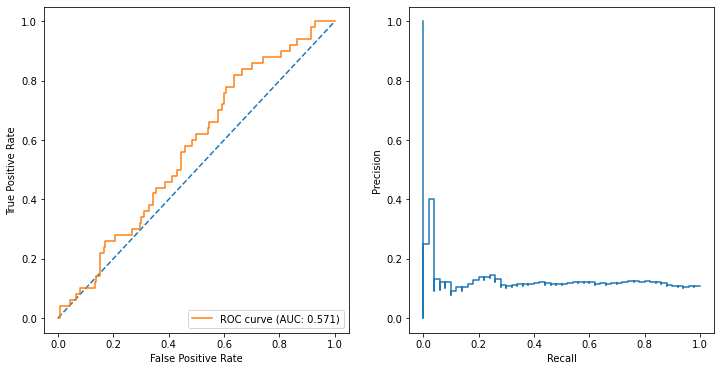

              precision    recall  f1-score   support

           0      0.900     0.858     0.878       450
           1      0.099     0.140     0.116        50

    accuracy                          0.786       500
   macro avg      0.499     0.499     0.497       500
weighted avg      0.820     0.786     0.802       500



[]

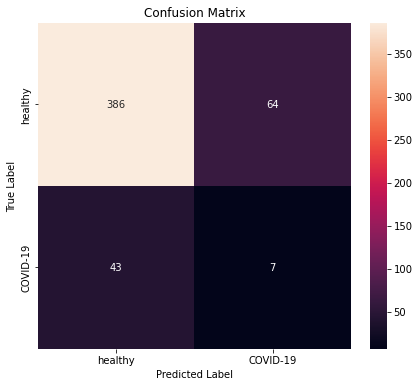

In [36]:
# choose best model from grid search
gs_model_4 = grid_search_4.best_estimator_.model

# make predictions on test data
y_test_pred = gs_model_4.predict_classes(X_test).reshape(-1)
y_test_probs = gs_model_4.predict_proba(X_test).reshape(-1)

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC: {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot()

### Fine-tuning best model